In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']="4"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial
from tqdm import trange

from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm

import time

from timeit import default_timer

from Adam import Adam


#os.environ['CUDA_LAUNCH_BLOCKING']="1"

torch.manual_seed(0)
np.random.seed(0)

In [2]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [3]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [4]:
#comfigs
Resmin, Resmax = [-1000,-1000,0], [80,1000,1000]
masktest = 80
IhbFile = "/home/zqzhong/Dataset/dataset_train_v1/"
ArrFile = "/home/zqzhong/Dataset/dataset_train_v2/"
FigFile = "/home/zqzhong/AI4Science/Pro/Eikonal/FNO4Eik/FigSave/"
###################################
ntrain = 40
ntest = 10
nforecast = 10
batch_size = 1
###################################
learning_rate = 0.001
epochs = 5000
step_size = 500
gamma = 0.5
modes = 20 #? how to judge
width = 40 #? how to pick
r = 5
s = int(Resmax[-1]/r)

In [5]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[1,2,4],[4,5,7]])
print(a)

[[1 2 3]
 [4 5 6]]


In [6]:
def RDevelop(Ihb):
    '''
    To transform the inhibitor distribution into that of development rate
    '''
    n, Mth = 30, 0.5
    Rmax, Rmin = 40, 0.003
    a = (n+1)/(n-1)*(1-Mth)**n
    return Rmin+Rmax*(((a+1)*np.power(1-Ihb,n))/(a+np.power(1-Ihb,n)))


def timepic(save_time):
    timethis = str(save_time.tm_mon).zfill(2) + str(save_time.tm_mday).zfill(2) + str(save_time.tm_hour).zfill(2) + str(save_time.tm_min).zfill(2) 
    return timethis
    

def namepic(k, save_str):
    namethis = str(k+ntrain+ntest).zfill(4) + save_str 
    return namethis

def plotmesh(to_be_plot, name, save_time):
    fig = plt.figure(figsize=(24,12))
    plt.rcParams['font.size'] = '25'
    Resmin, Resmax = [0,-1000,-1000], [80,1000,1000]
    Y = np.arange(0, Resmax[1], r)
    Z = np.arange(0, Resmax[2], r)
    Y, Z = np.meshgrid(Y, Z)

    levels = np.linspace(to_be_plot.min(), to_be_plot.max(),20)
    ax = fig.add_subplot(121)
    cset = ax.contourf(Y, Z, to_be_plot, levels, cmap=cm.jet)    
    ax.set_title(name, fontsize='40')
    plt.xlim(0, 200); plt.ylim(0, 200)
    plt.xticks([0,500,1000]); plt.yticks([0,500,1000])
    position = fig.add_axes([0.55, 0.2, 0.02, 0.6])
    cbar = plt.colorbar(cset, pad=0, fraction=0, cax=position)
    cbar.set_ticks([to_be_plot.min(),0.75*to_be_plot.min(),0.5*to_be_plot.min(),0.25*to_be_plot.min(),0,0.25*to_be_plot.max(),0.5*to_be_plot.max(),0.75*to_be_plot.max(),to_be_plot.max()], FormatStrFormatter('%.1f') )
    #plt.show()
    if not os.path.exists(FigFile + timepic(save_time)):
        os.makedirs(FigFile + timepic(save_time))
    plt.savefig(FigFile + timepic(save_time) + "/" +name)
    
def do_trans(nary):
    ap = np.log(nary+1)
    app = np.log(ap+1)
    return app

def de_trans(nary):
    bpp = np.exp(nary)-1
    bp = np.exp(bpp)-1
    return bp


In [7]:
t1 = time.time()
print("Starttime:",t1)
IhbData = np.load(IhbFile+str(2).zfill(4)+"Inhibitor.npy")
print("IhbData.shape: ", IhbData.shape)
IhbData = IhbData.reshape(Resmax)
IhbData = RDevelop(IhbData)
print("IhbData.shape: ", IhbData.shape)
t2 = time.time()
print("Runtime: ",t2-t1)
ArrData = np.load(ArrFile+str(2).zfill(4)+"Arrival.npy")
ArrData = do_trans(ArrData)
print("ArrData.shape: ", ArrData.shape)
t3 = time.time()
print("Runtime: ",t3-t2)

Starttime: 1669697612.0170233
IhbData.shape:  (80000, 1000)
IhbData.shape:  (80, 1000, 1000)
Runtime:  3.1763153076171875
ArrData.shape:  (1000, 1000, 80)
Runtime:  1.265876293182373


In [8]:
#plotmesh(IhbData[0,::r,::r].transpose())
#plotmesh(ArrData[::r,::r,0])

In [14]:
#Load Data
x_train_list = np.empty([ntrain, s, s])
y_train_list = np.empty([ntrain, s, s])
x_test_list = np.empty([ntest, s, s])
y_test_list = np.empty([ntest, s, s])
x_fc_list = np.empty([nforecast, s, s])
y_fc_list = np.empty([nforecast, s, s])

t3 = time.time()
for k in range(ntrain):
    
    print(k)
    IhbData = np.load(IhbFile+str(k).zfill(4)+"Inhibitor.npy").reshape(Resmax)
    ArrData = np.load(ArrFile+str(k).zfill(4)+"Arrival.npy")
    
    x_train_pre = IhbData[0,::r,::r].transpose()
    #print("IhbData "+str(k).zfill(4)+" already loaded.")
    x_train = RDevelop(x_train_pre)
    #print("IhbData "+str(k).zfill(4)+" already transfered.")
    y_train = do_trans(ArrData[::r,::r,0])
    #print("ArrData "+str(k).zfill(4)+" already loaded.")
    
    # x_normalizer = UnitGaussianNormalizer(x_train)
    # x_train = x_normalizer.encode(x_train)
    x_train = x_train.reshape(1,s,s)
    
    # y_normalizer = UnitGaussianNormalizer(y_train)
    # y_train = y_normalizer.encode(y_train)
    y_train = y_train.reshape(1,s,s)
    
    x_train_list[k] = x_train
    y_train_list[k] = y_train
    
    t4 = time.time()
    print("Runtime: ",t4-t3)
    print("Train set "+str(k).zfill(4)+" already loaded.")

print("x_train_list.shape: ", x_train_list.shape)
print("y_train_list.shape: ", y_train_list.shape) 
for k in range(ntrain, ntrain + ntest):
    
    IhbData = np.load(IhbFile+str(k).zfill(4)+"Inhibitor.npy").reshape(Resmax)
    ArrData = np.load(ArrFile+str(k).zfill(4)+"Arrival.npy")
    
    
    x_test_pre = IhbData[0,::r,::r].transpose()
    x_test = RDevelop(x_test_pre)
    y_test = do_trans(ArrData[::r,::r,0])
    
    # x_normalizer = UnitGaussianNormalizer(x_test)
    # x_test = x_normalizer.encode(x_test)
    x_test = x_test.reshape(1,s,s)
    
    # y_normalizer = UnitGaussianNormalizer(y_test)
    # y_test = y_normalizer.encode(y_test)
    y_test = y_test.reshape(1,s,s)
    
    x_test_list[k-ntrain] = x_test
    y_test_list[k-ntrain] = y_test
    t4 = time.time()
    print("Runtime: ",t4-t3)
    print("Test  set "+str(k).zfill(4)+" already loaded.")

print("x_test_list.shape: ", x_test_list.shape) 
print("y_test_list.shape: ", y_test_list.shape)
for k in range(ntrain + ntest, ntrain + ntest + nforecast):
    
    IhbData = np.load(IhbFile+str(k).zfill(4)+"Inhibitor.npy").reshape(Resmax)
    ArrData = np.load(ArrFile+str(k).zfill(4)+"Arrival.npy")
    
    #print("IhbData.shape: ", IhbData.shape)
    #print("ArrData.shape: ", ArrData.shape)
    
    x_fc_pre = IhbData[0,::r,::r].transpose()
    x_fc = RDevelop(x_fc_pre)
    y_fc = do_trans(ArrData[::r,::r,0])
    
    # x_normalizer = UnitGaussianNormalizer(x_test)
    # x_fc = x_normalizer.encode(x_test)
    x_fc = x_fc.reshape(1,s,s)
    
    # y_normalizer = UnitGaussianNormalizer(y_test)
    # y_test = y_normalizer.encode(y_test)
    y_fc = y_fc.reshape(1,s,s)
    
    x_fc_list[k - ntrain - ntest,:,:] = x_fc
    y_fc_list[k - ntrain - ntest,:,:] = y_fc
    #print("x_fc_list.shape: ", x_fc_list.shape)
    #print("y_fc_list.shape: ", y_fc_list.shape)
    t4 = time.time()
    print("Runtime: ",t4-t3)
    print("Forecastset "+str(k).zfill(4)+" already loaded.")

0
Runtime:  0.32798075675964355
Train set 0000 already loaded.
1
Runtime:  0.6542272567749023
Train set 0001 already loaded.
2
Runtime:  0.9815256595611572
Train set 0002 already loaded.
3
Runtime:  1.3074827194213867
Train set 0003 already loaded.
4
Runtime:  1.6335933208465576
Train set 0004 already loaded.
5
Runtime:  1.9610378742218018
Train set 0005 already loaded.
6
Runtime:  2.287240505218506
Train set 0006 already loaded.
7
Runtime:  2.61330246925354
Train set 0007 already loaded.
8
Runtime:  2.9393606185913086
Train set 0008 already loaded.
9
Runtime:  3.265791654586792
Train set 0009 already loaded.
10
Runtime:  3.5924384593963623
Train set 0010 already loaded.
11
Runtime:  3.9198222160339355
Train set 0011 already loaded.
12
Runtime:  4.24757194519043
Train set 0012 already loaded.
13
Runtime:  4.57932186126709
Train set 0013 already loaded.
14
Runtime:  4.90655255317688
Train set 0014 already loaded.
15
Runtime:  5.2325758934021
Train set 0015 already loaded.
16
Runtime:  5

In [15]:
x_train_list = torch.tensor(x_train_list,dtype=torch.float32)
y_train_list = torch.tensor(y_train_list,dtype=torch.float32)
y_nor = UnitGaussianNormalizer(y_train_list)
y_train_list = y_nor.encode(y_train_list)

x_test_list = torch.tensor(x_test_list,dtype=torch.float32)
y_test_list = torch.tensor(y_test_list,dtype=torch.float32)

x_fc_list = torch.tensor(x_fc_list,dtype=torch.float32)
y_fc_list = torch.tensor(y_fc_list,dtype=torch.float32)


x_train_list = x_train_list.reshape(ntrain, s, s, 1)
x_test_list = x_test_list.reshape(ntest, s, s, 1)
x_fc_list = x_fc_list.reshape(nforecast, s, s, 1)

In [16]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_list, y_train_list), batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_list, y_test_list), batch_size=batch_size, shuffle=False)

In [19]:
# training and evaluation
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
loss_train_log = []
loss_test_log = []
pbar = trange(epochs)

y_train_list.cuda()
y_nor.cuda()
for ep in pbar:
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        out = y_nor.decode(out)
        y = y_nor.decode(y)
        
        # print("x.shape:",x.shape," y.shape:",y.shape," out.shape:",out.shape)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, s)
            out = y_nor.decode(out)
            
            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2/= ntest

    t2 = default_timer()
    loss_train_log.append(train_l2)
    loss_test_log.append(test_l2)
    if ep % 5 == 0:
        pbar.set_postfix({'train_loss': train_l2, 
                    'test_loss' : test_l2})
    #print(ep, t2-t1, train_l2, test_l2)


10252097


 54%|█████▎    | 2680/5000 [26:09<22:12,  1.74it/s, train_loss=0.00253, test_loss=0.0341] 

In [ ]:
SavePath = "/home/zqzhong/AI4Science/Pro/Eikonal/FNO4Eik/trained_model/"
save_time = time.ctime()
struct_time = time.strptime(save_time)
torch.save(model, SavePath + "Trained_Model_" + str(struct_time.tm_mon).zfill(2) + str(struct_time.tm_mday).zfill(2) + str(struct_time.tm_hour).zfill(2) + str(struct_time.tm_min).zfill(2)+".pkl")

In [ ]:
#LoadPath = "/home/zqzhong/AI4Science/Pro/Eikonal/FNO4Eik/trained_model/Trained_Model_11251651.pkl"
#new_model = torch.load(LoadPath)

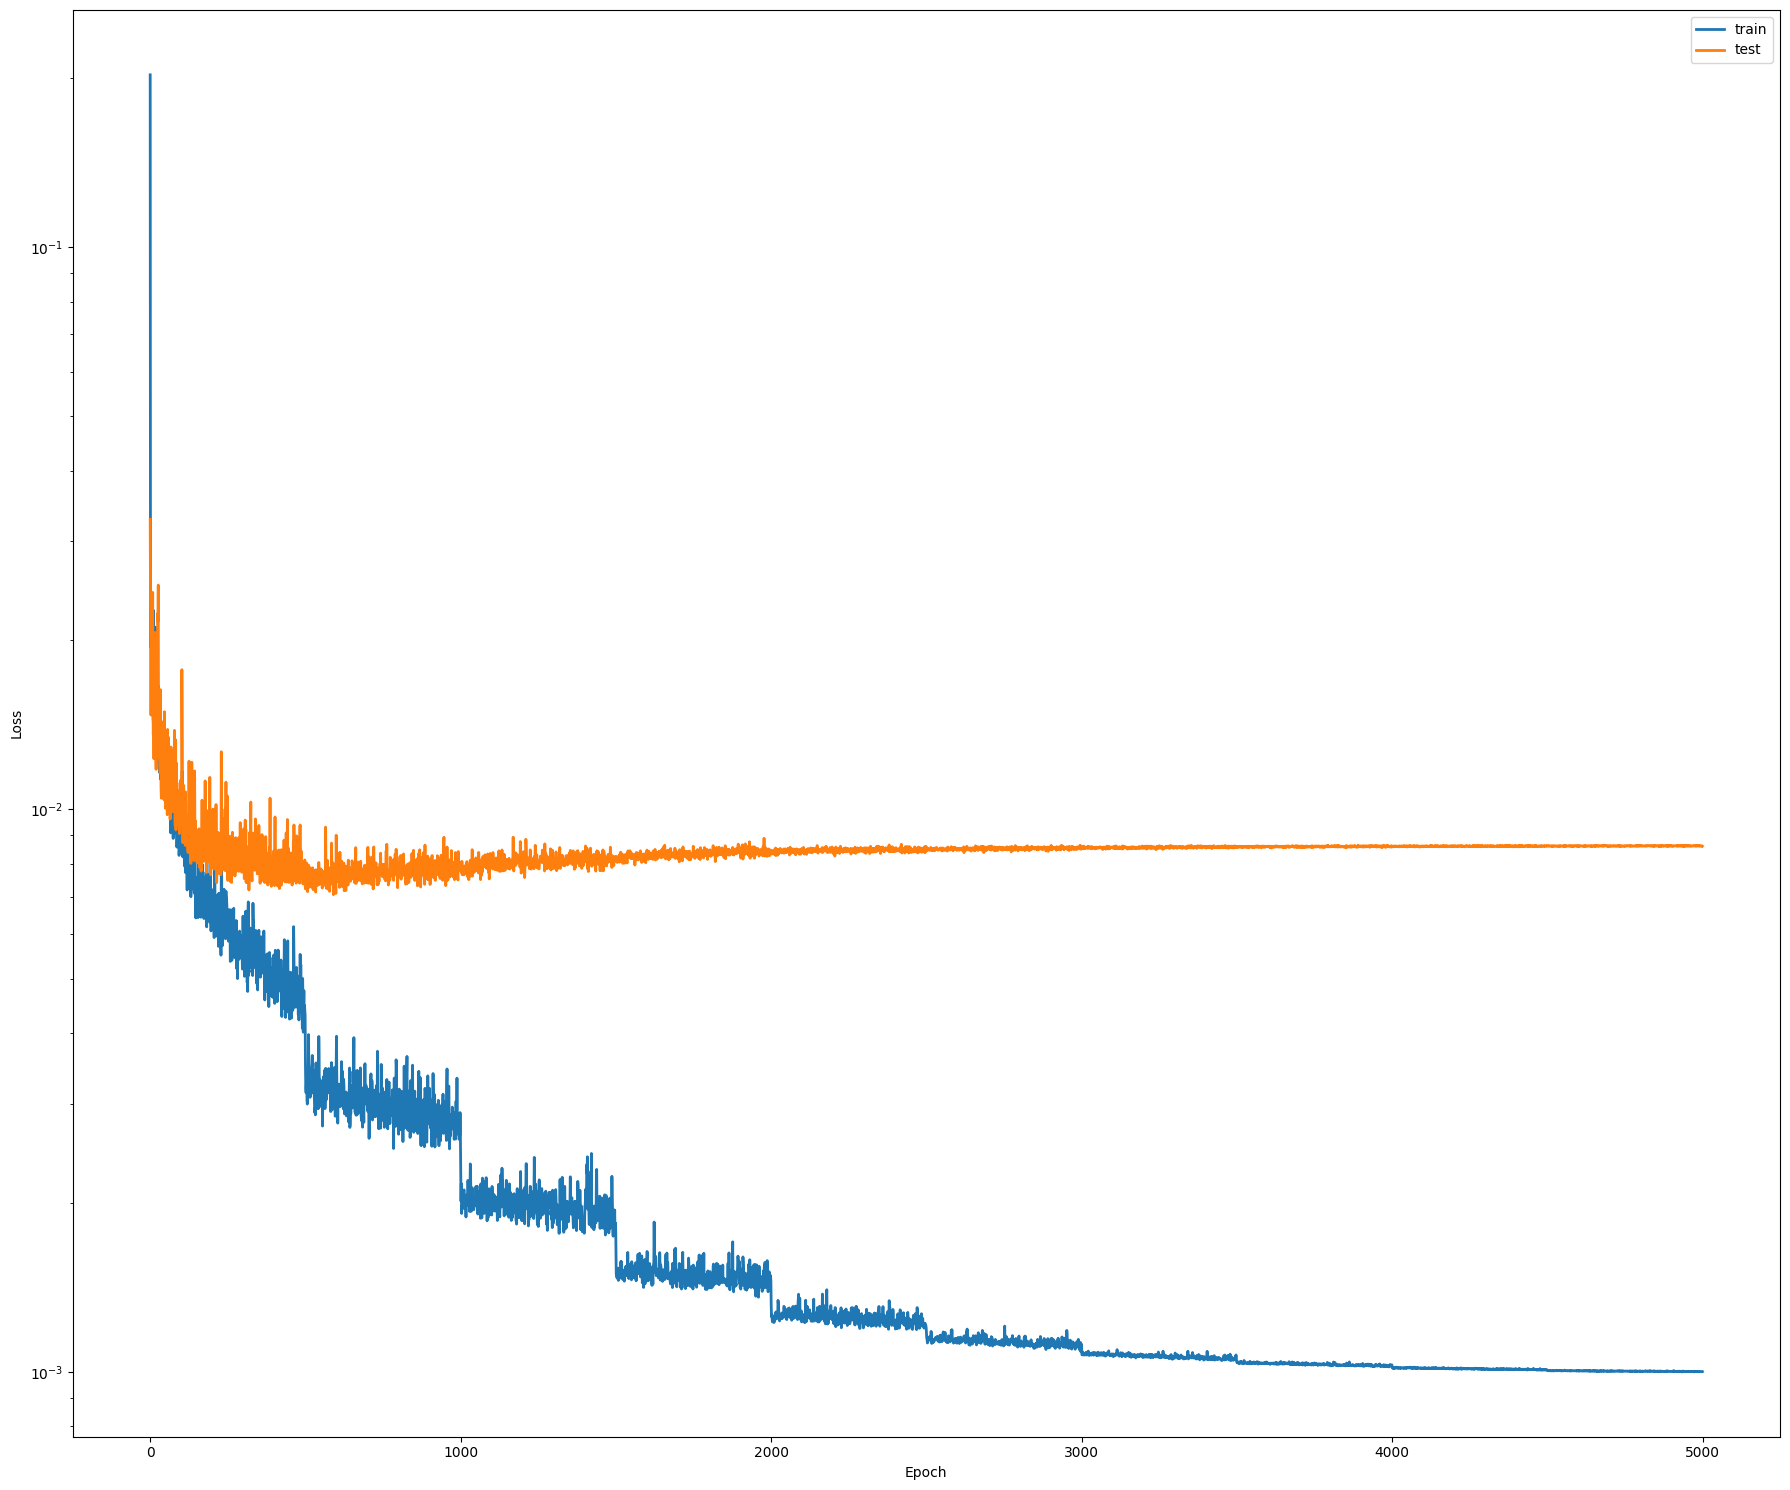

In [ ]:
plt.figure(figsize = (18,15))
plt.plot(loss_train_log, lw=2, label='train')
plt.plot(loss_test_log, lw=2, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(FigFile + timepic(save_time) + "/" + "loss_curve")

(10, 200, 200, 1)
The  50 st Forecast result
True_Arrival_log


/tmp/ipykernel_454717/2161296888.py:36: MatplotlibDeprecationWarning: The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([to_be_plot.min(),0.75*to_be_plot.min(),0.5*to_be_plot.min(),0.25*to_be_plot.min(),0,0.25*to_be_plot.max(),0.5*to_be_plot.max(),0.75*to_be_plot.max(),to_be_plot.max()], FormatStrFormatter('%.1f') )


True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  49391.13856733786
plot_test_err.max():  14464.619500936344
The  51 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  43415.35804288364
plot_test_err.max():  14647.662730383643
The  52 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  49813.583208370714
plot_test_err.max():  53940.027013914354
The  53 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  43438.66276555077
plot_test_err.max():  44830.90385240527
The  54 st Forecast result
True_Arrival_log


/tmp/ipykernel_454717/2161296888.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(24,12))


True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  43660.36481346218
plot_test_err.max():  16648.27365990535
The  55 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  46186.788726996834
plot_test_err.max():  65124.81514933769
The  56 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  47413.946426364
plot_test_err.max():  22747.209291228173
The  57 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  43844.567401935004
plot_test_err.max():  17645.416125694705
The  58 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  51482.89385041581
plot_test_err.max():  31310.072074754098
The  59 st Forecast result
True_Arrival_log
True Arrival
Predict Arrival log
Predict Arrival
Error
plot_test_y_ref.max():  40294.5332132

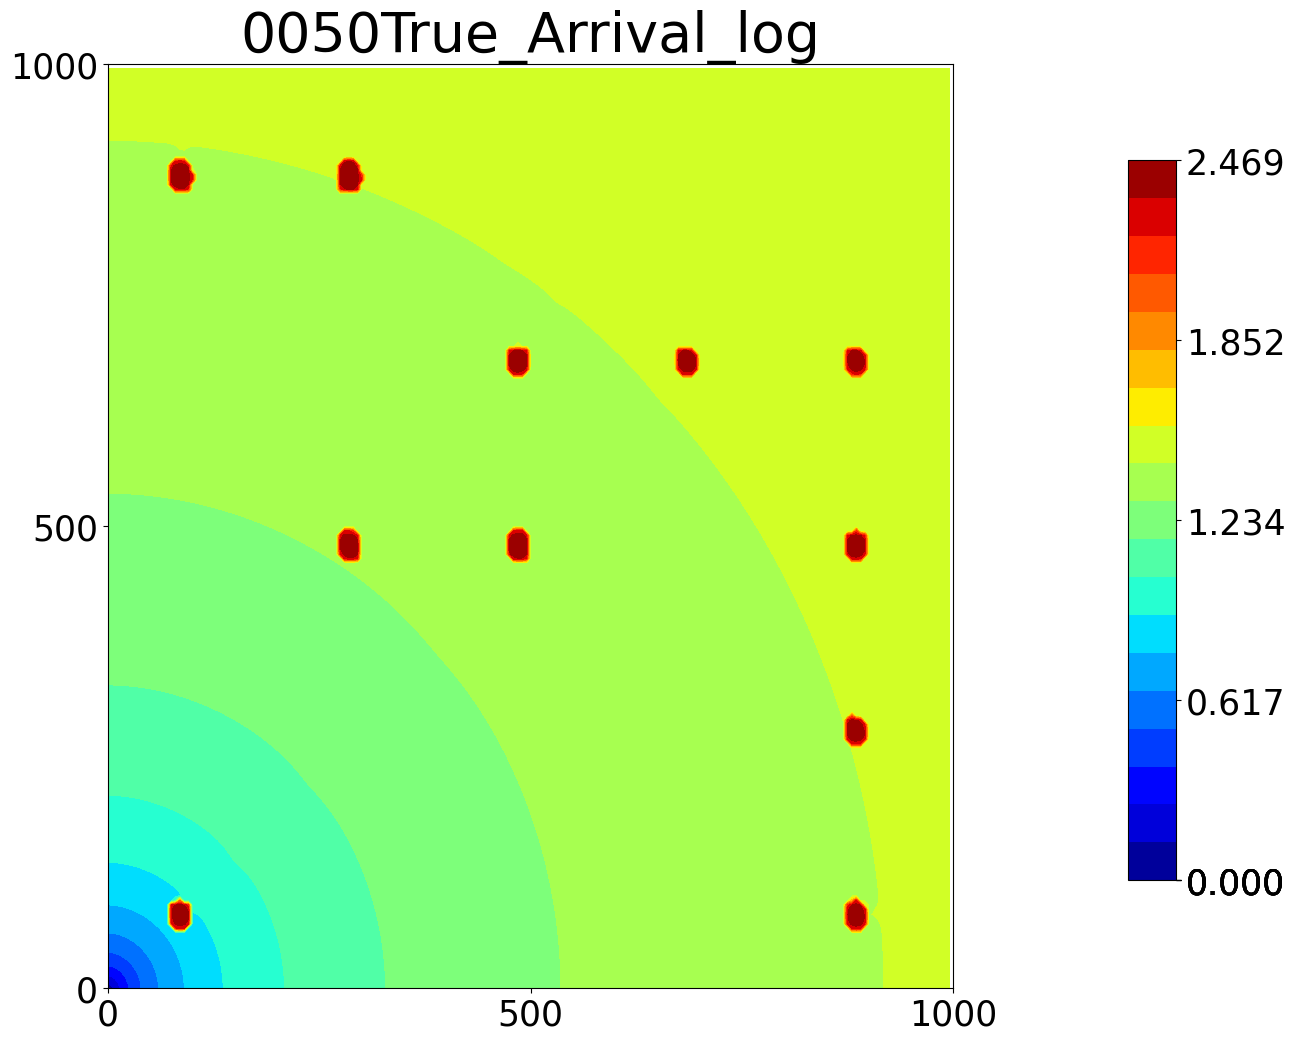

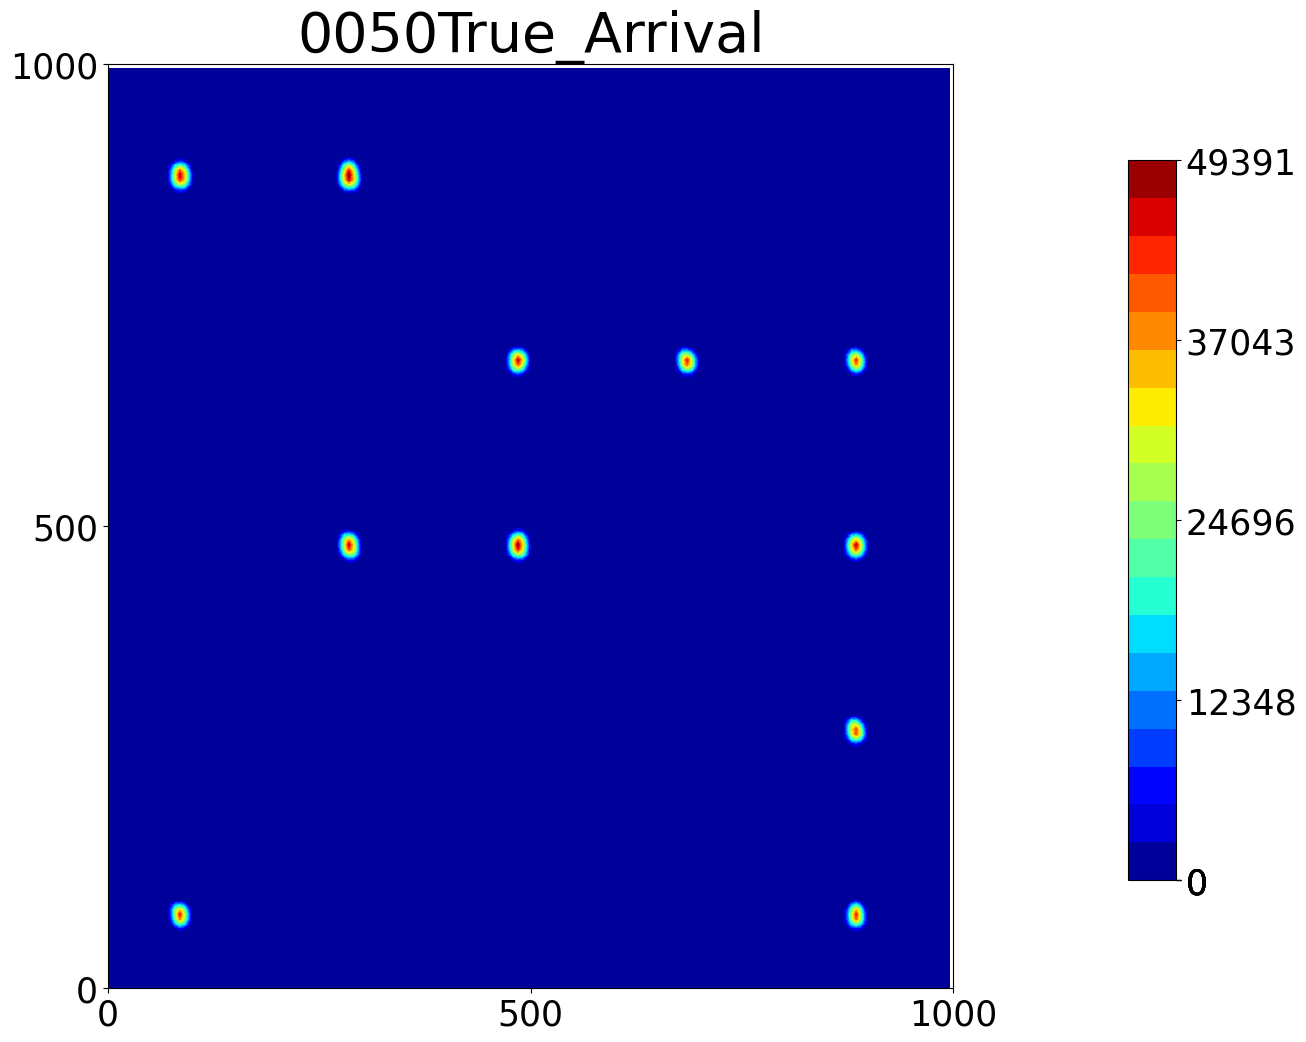

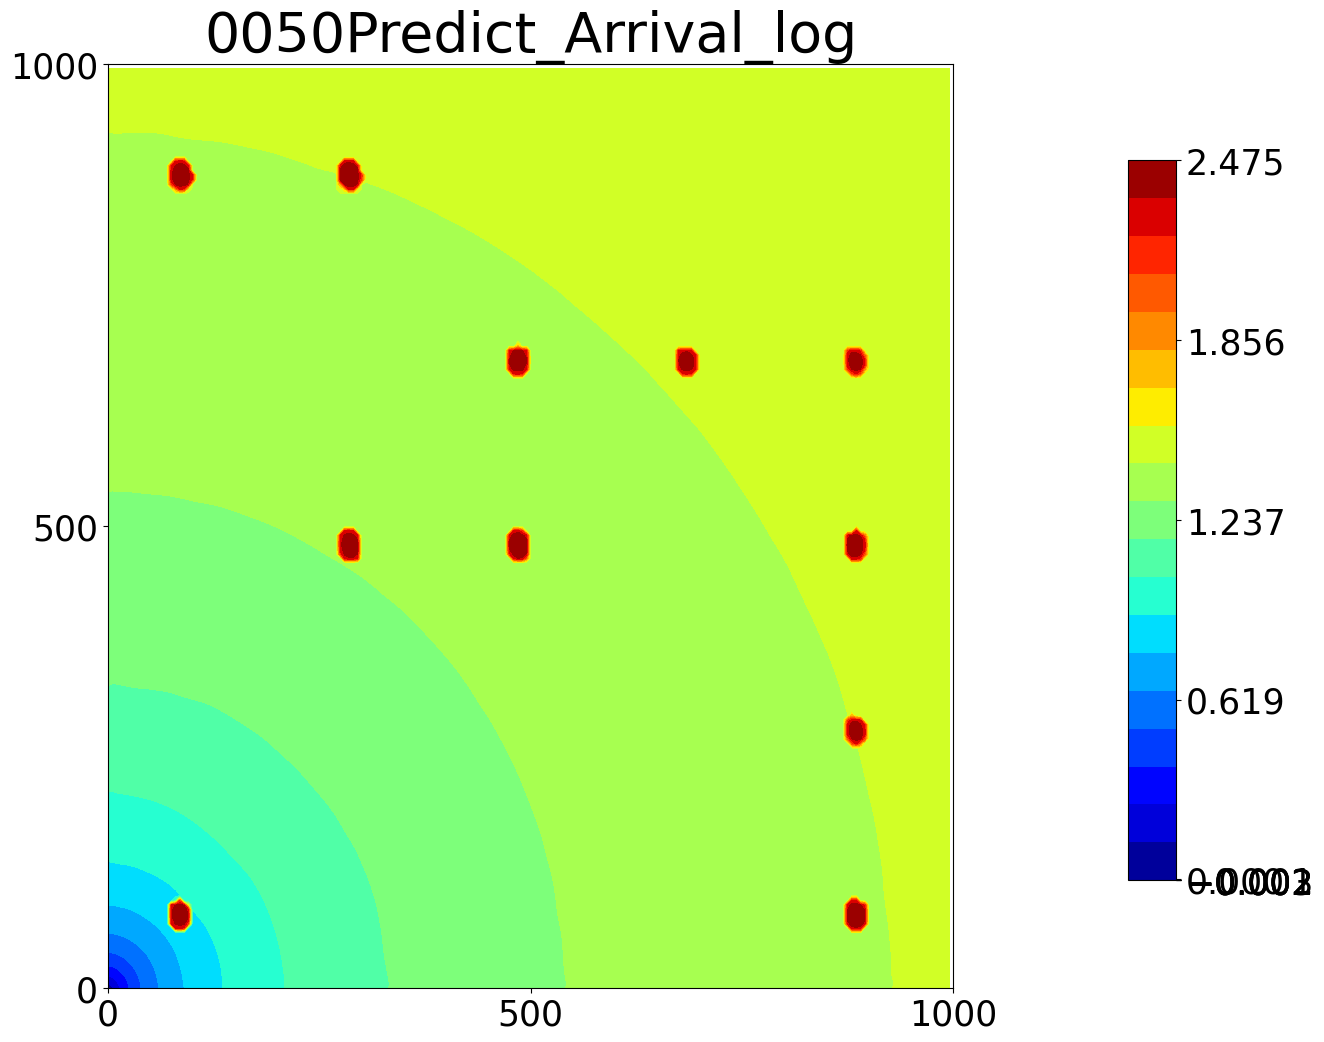

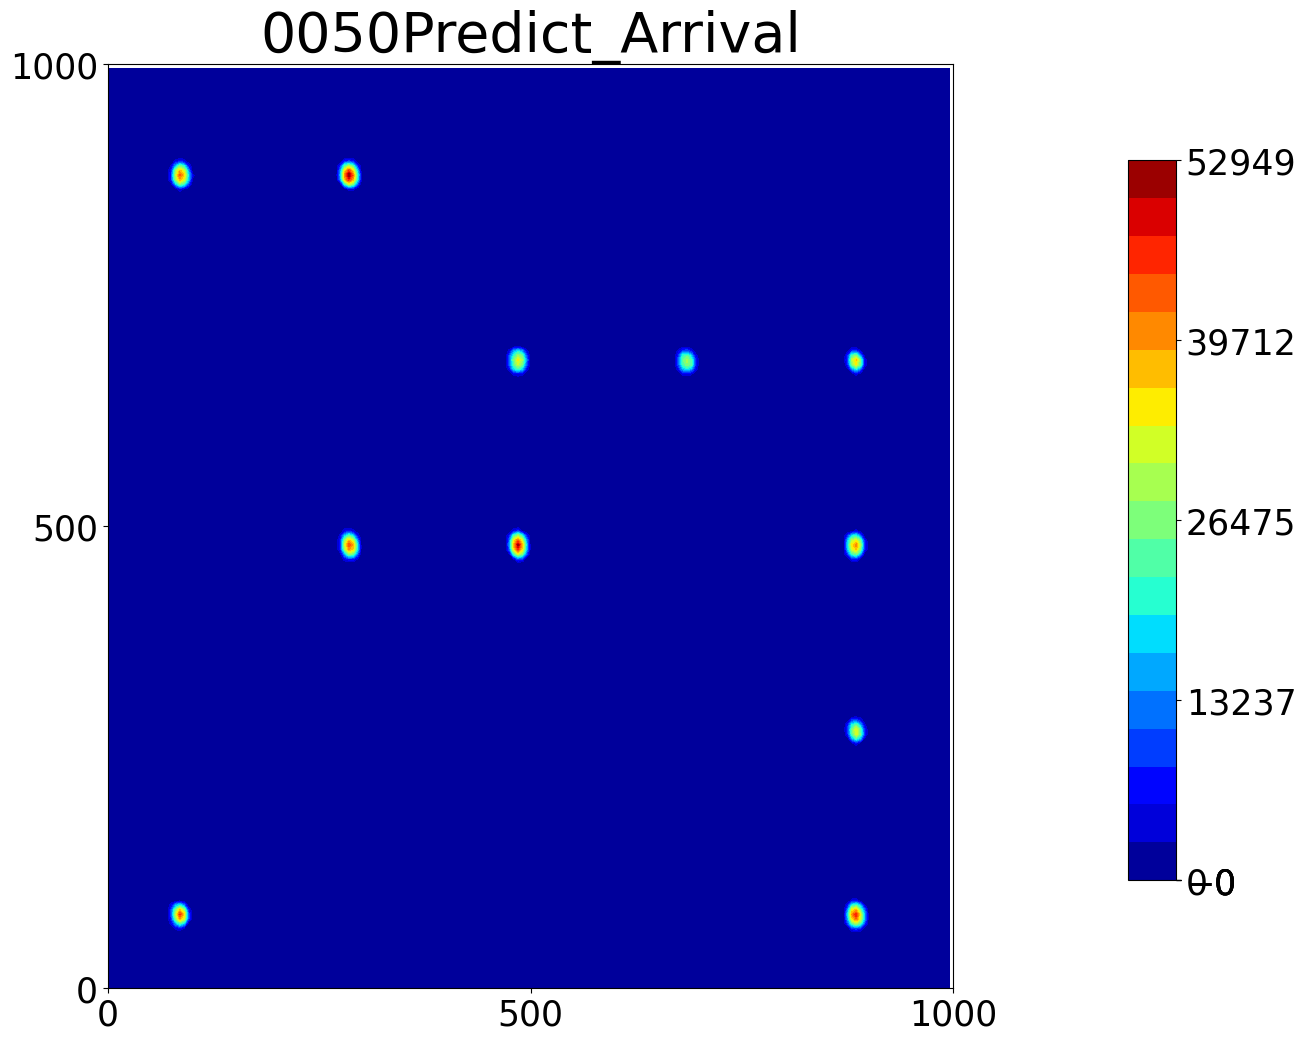

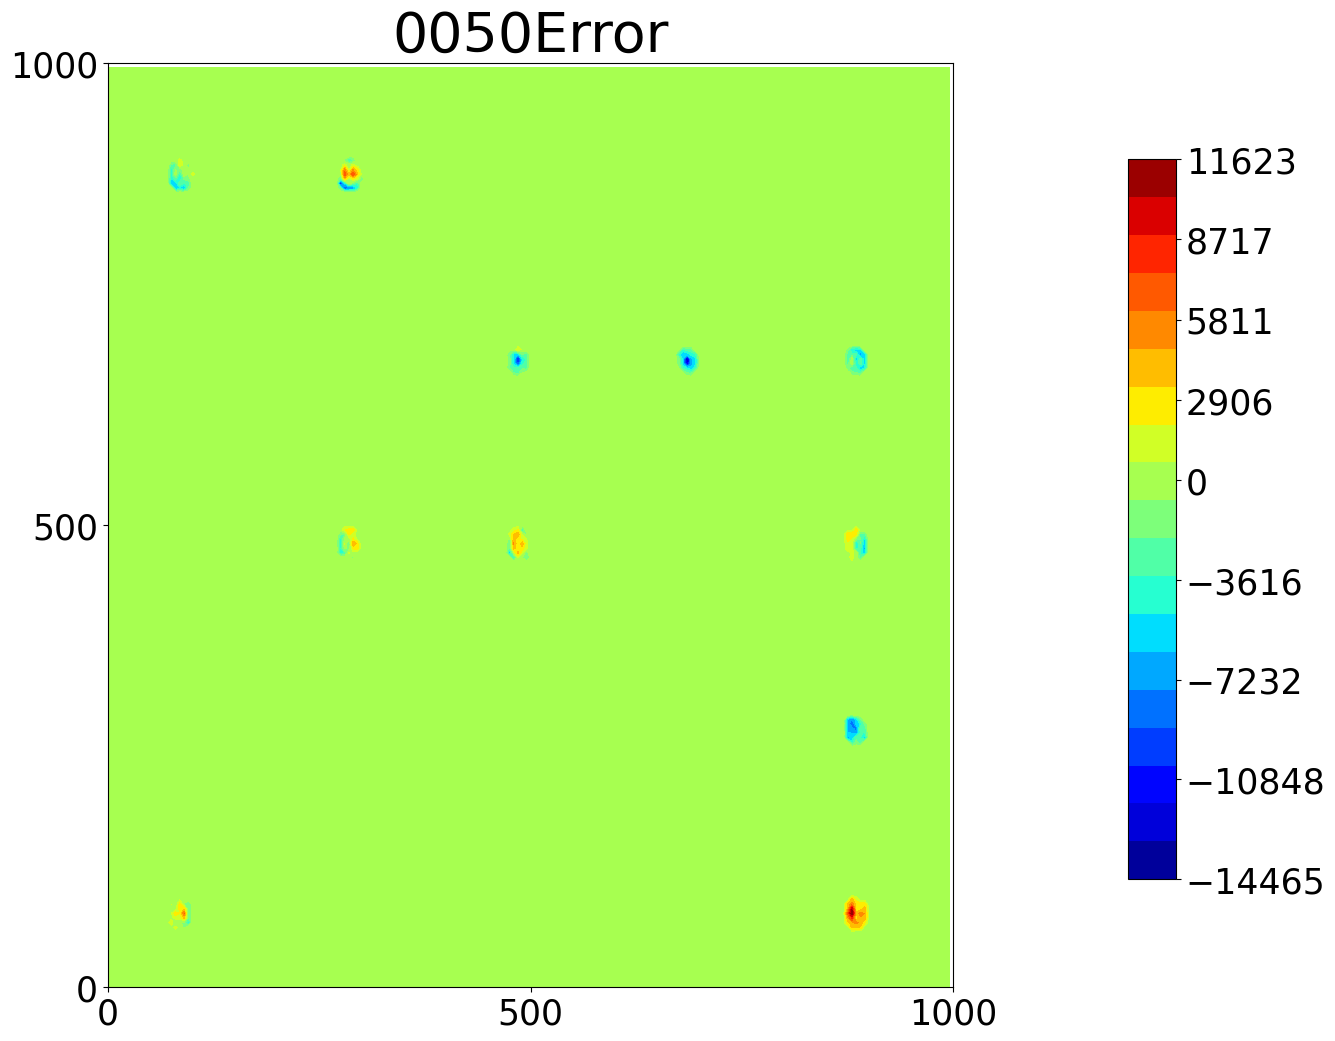

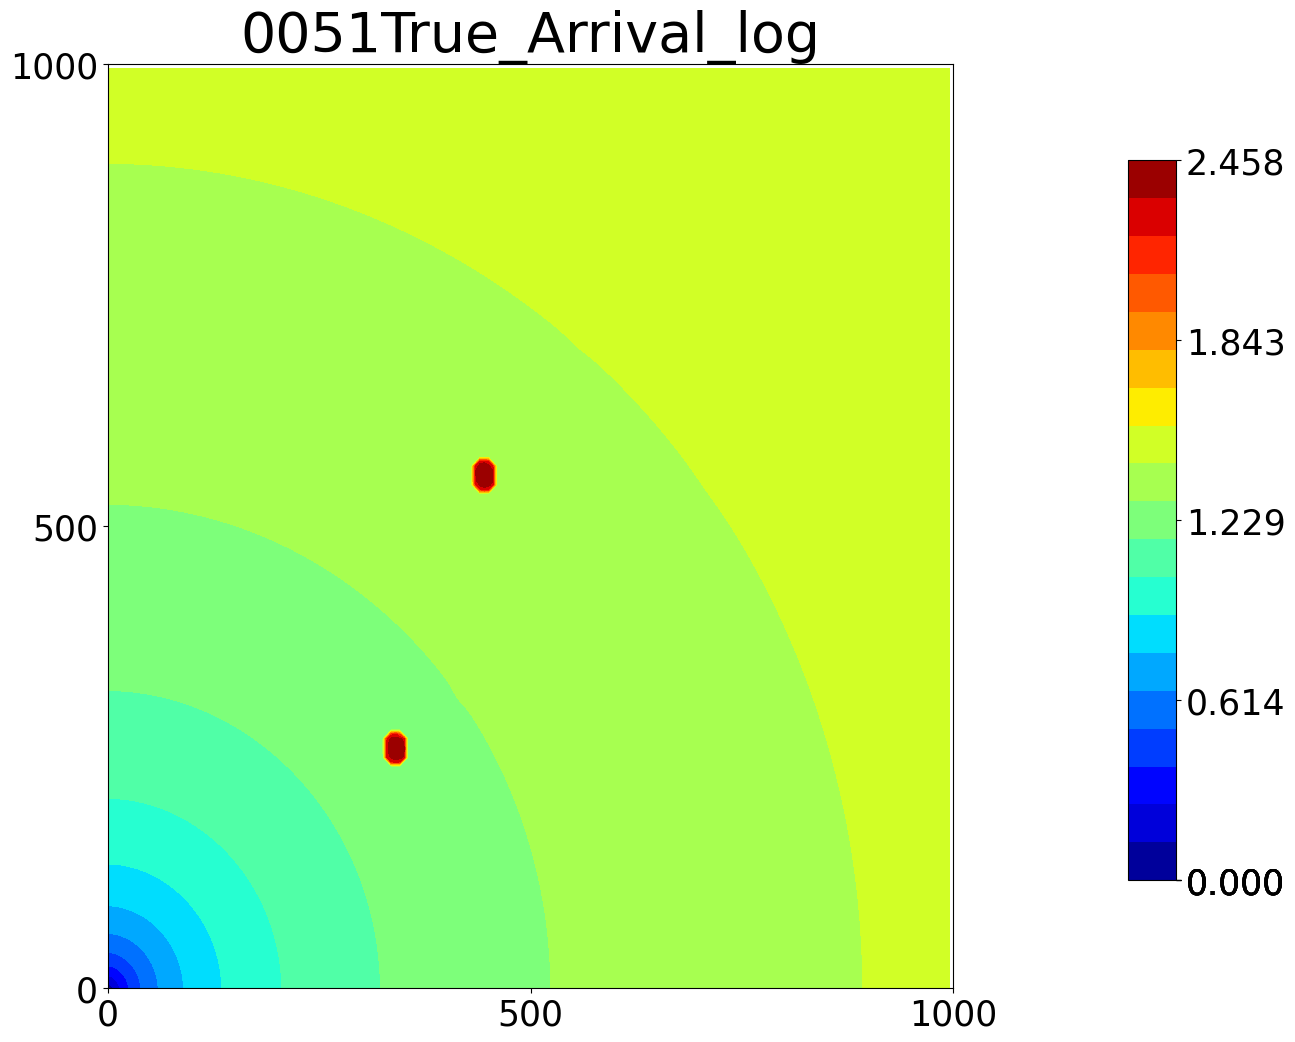

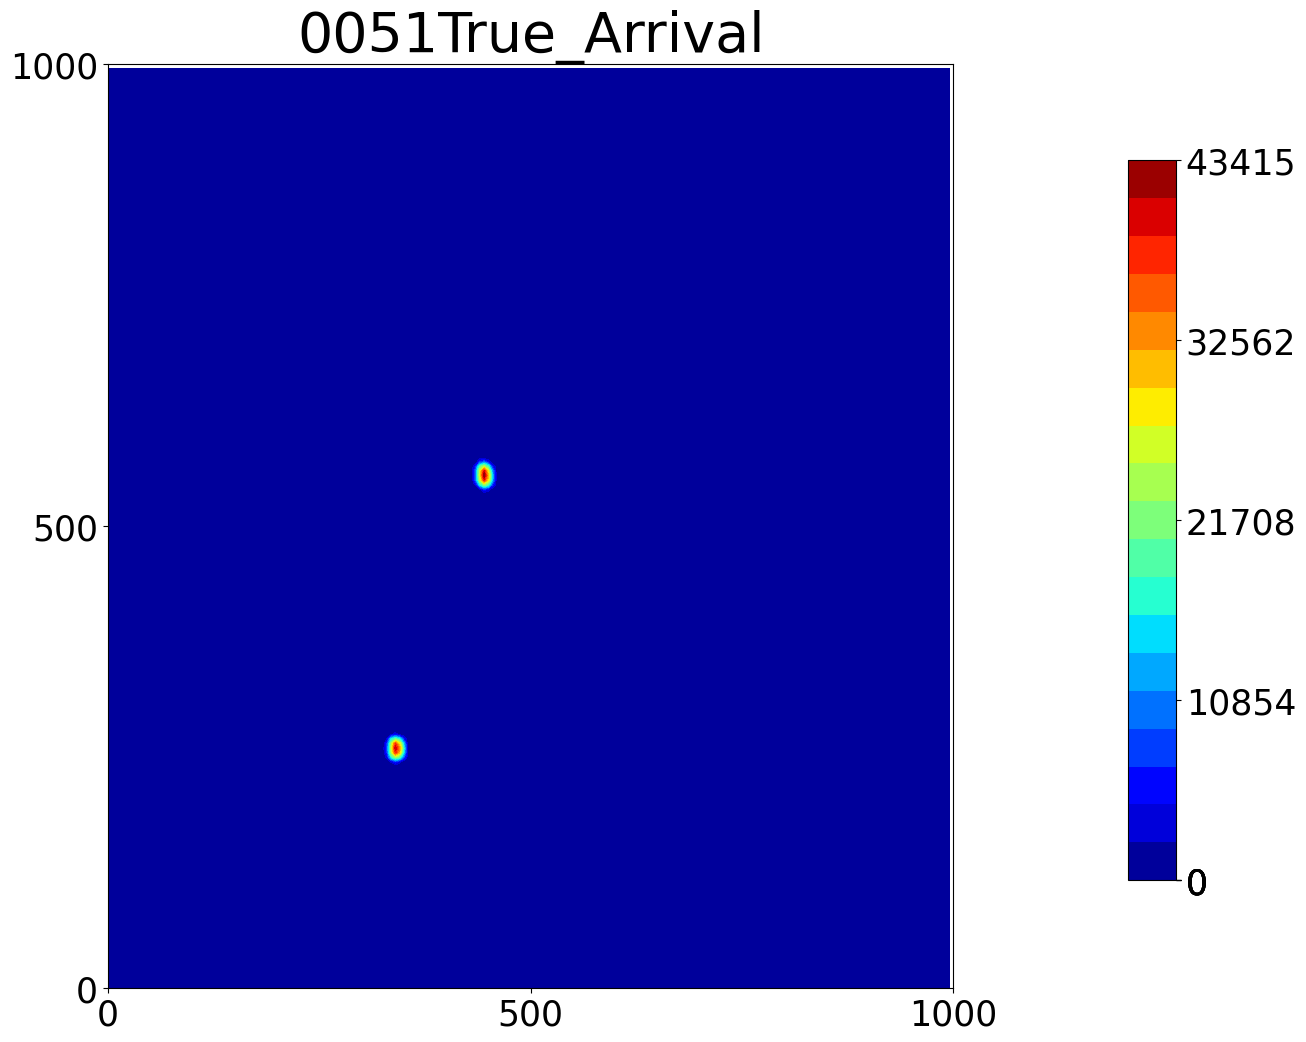

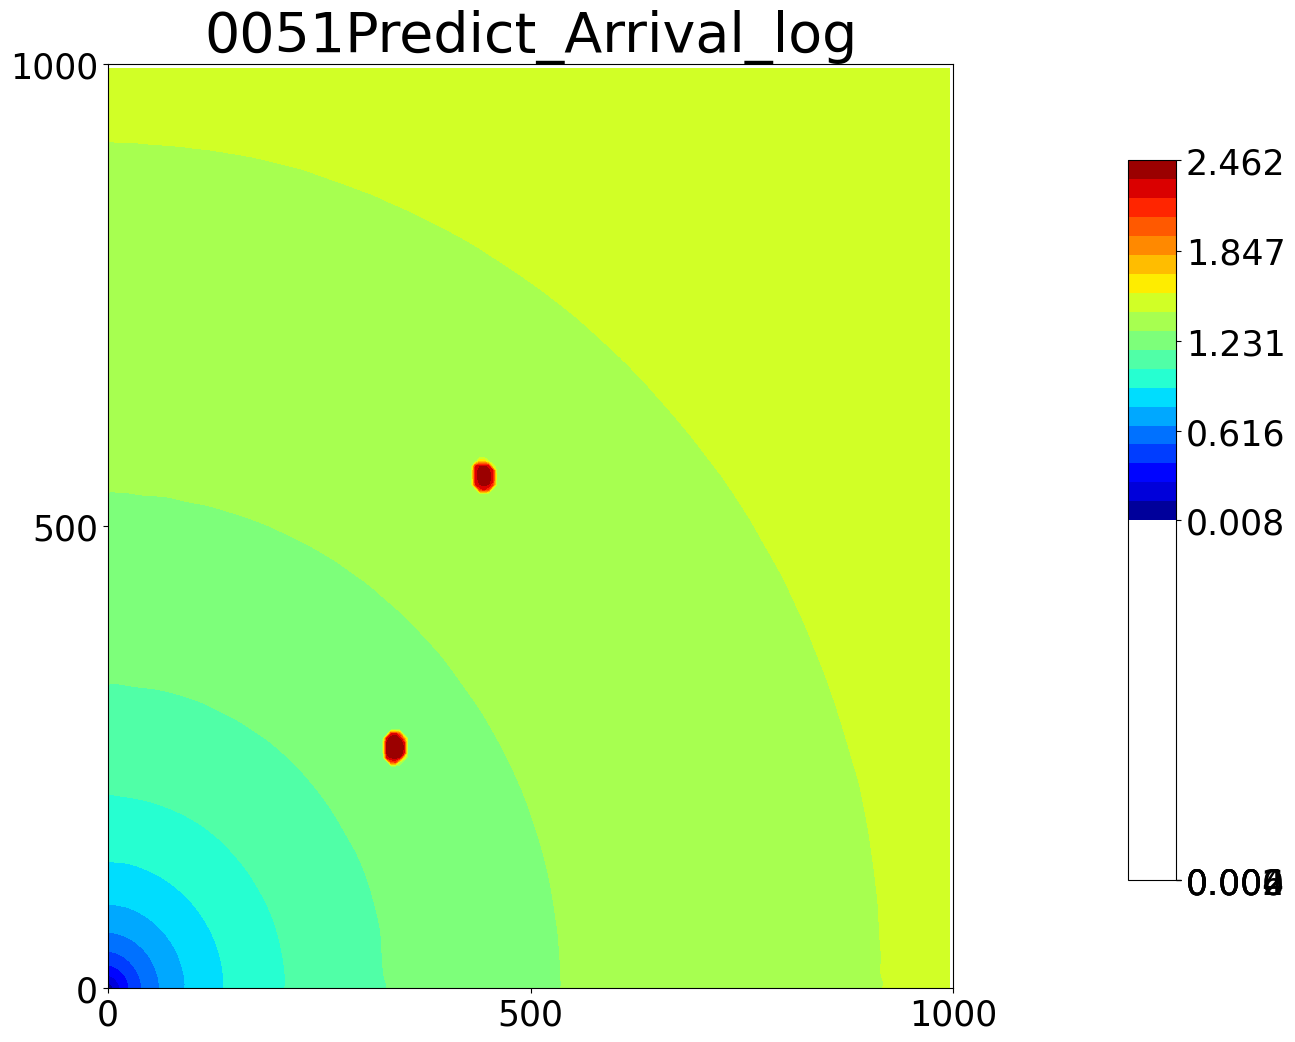

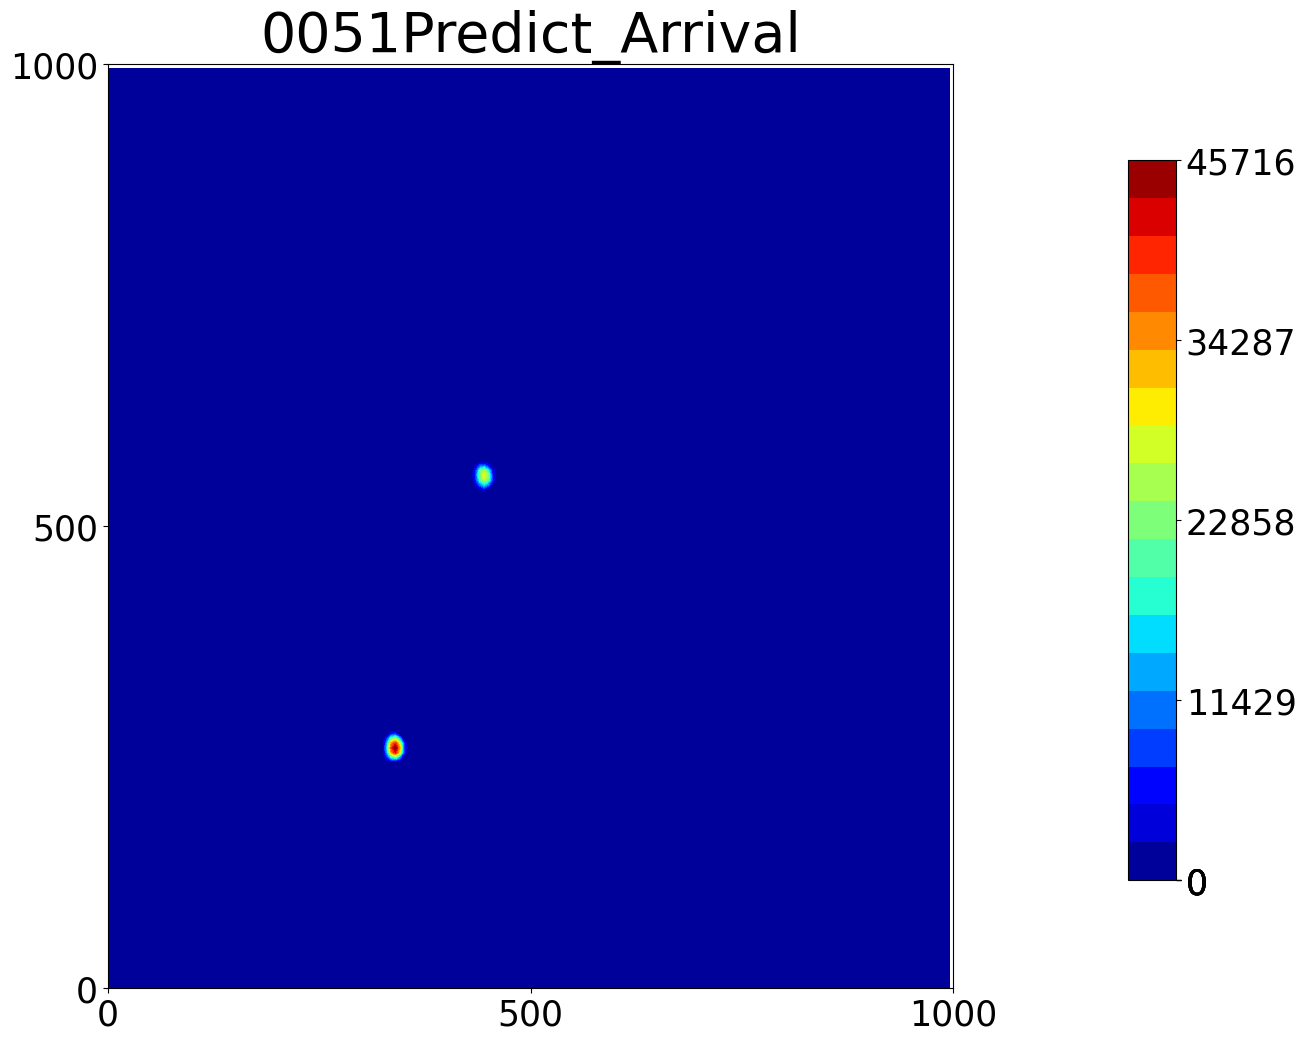

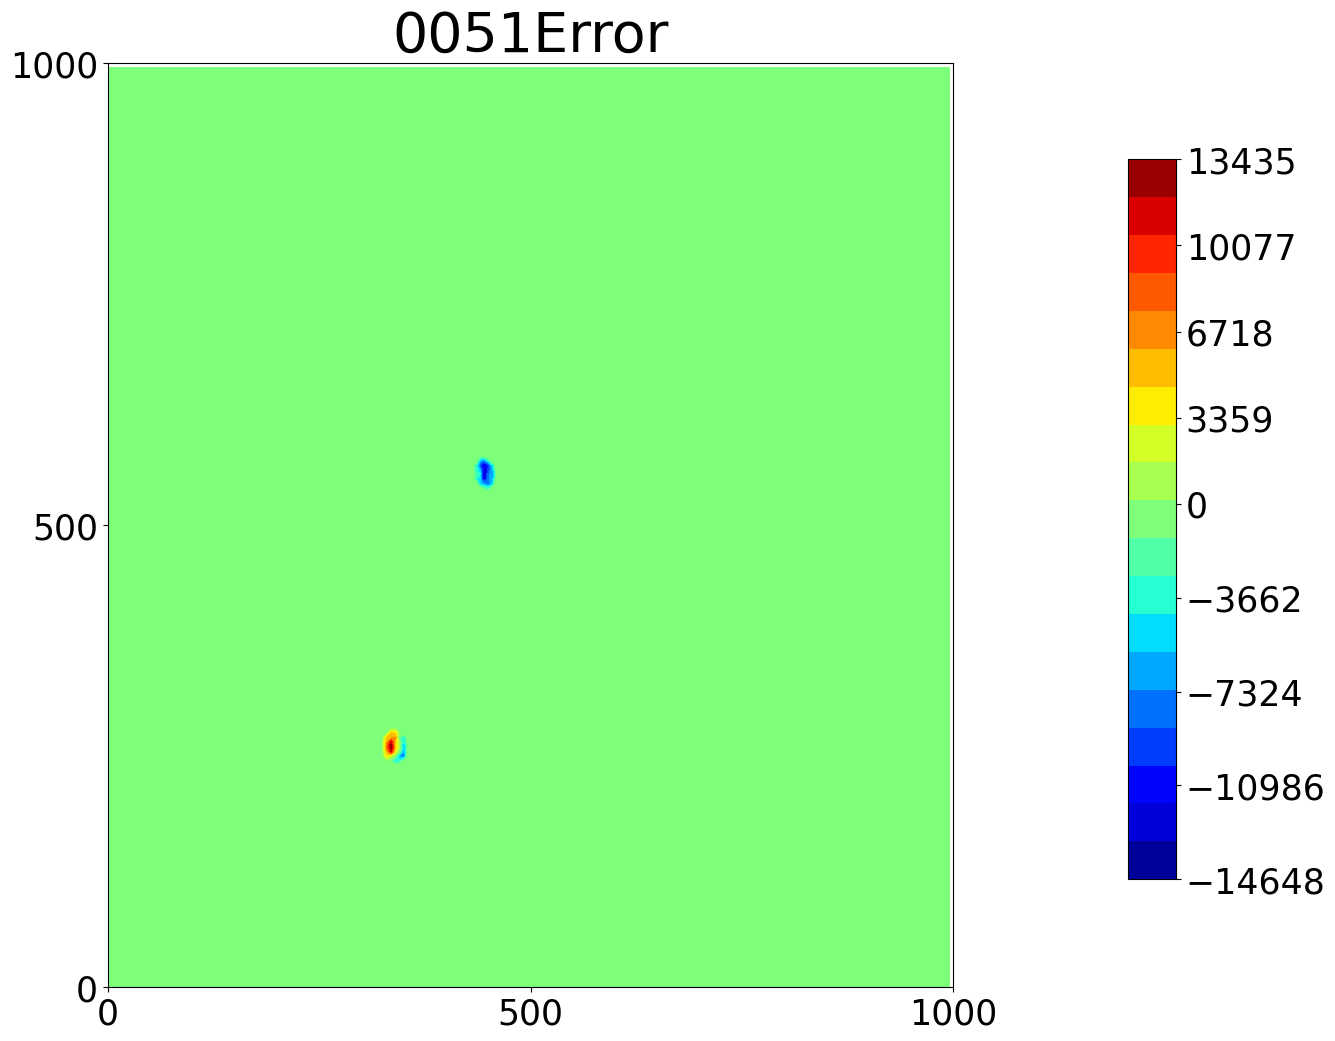

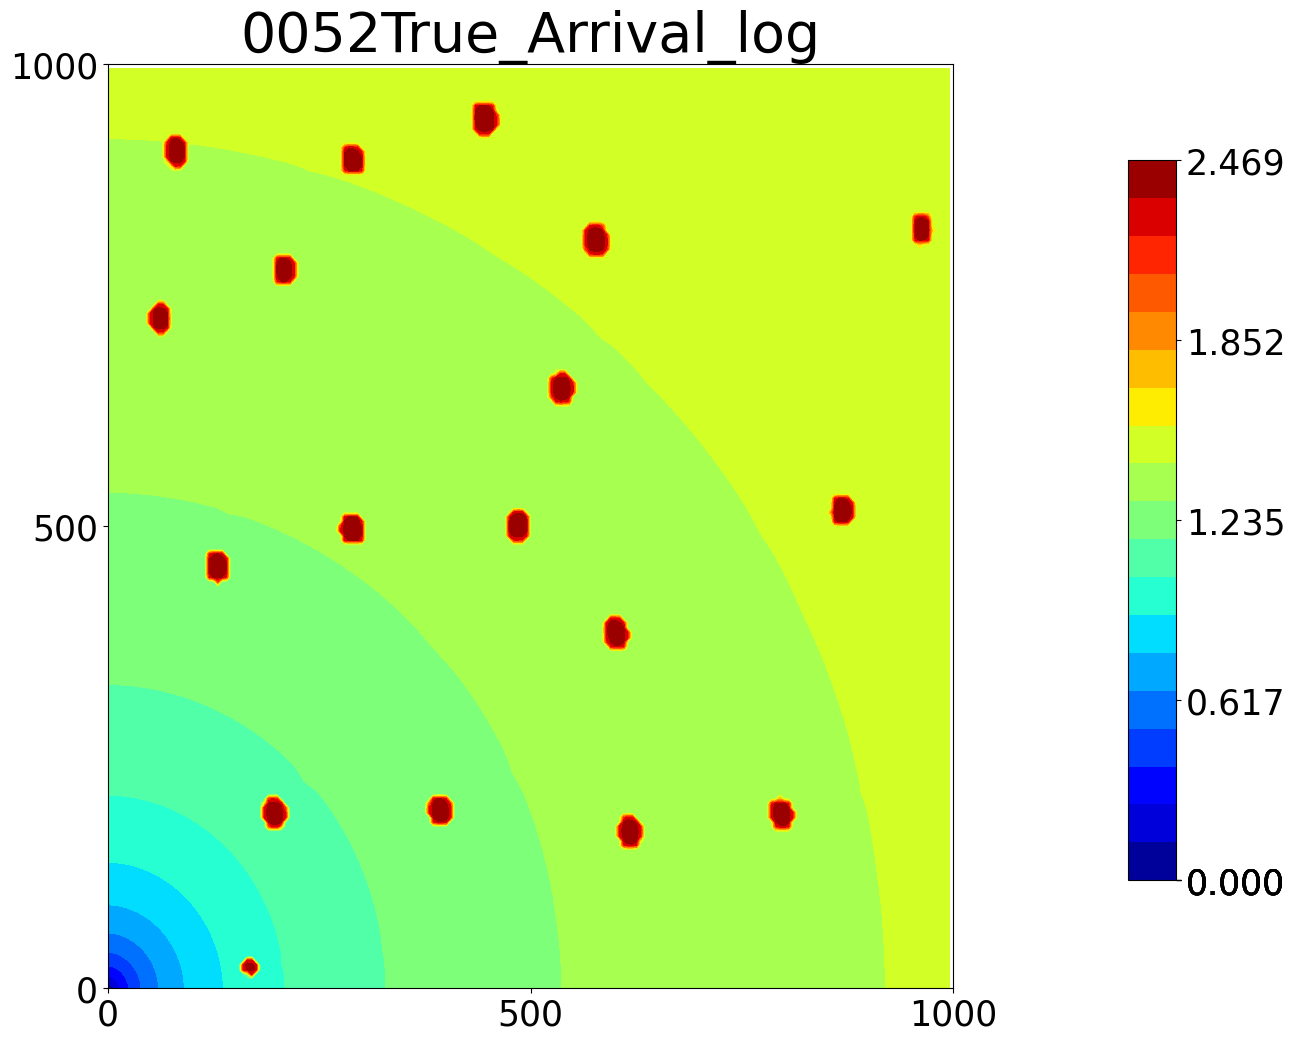

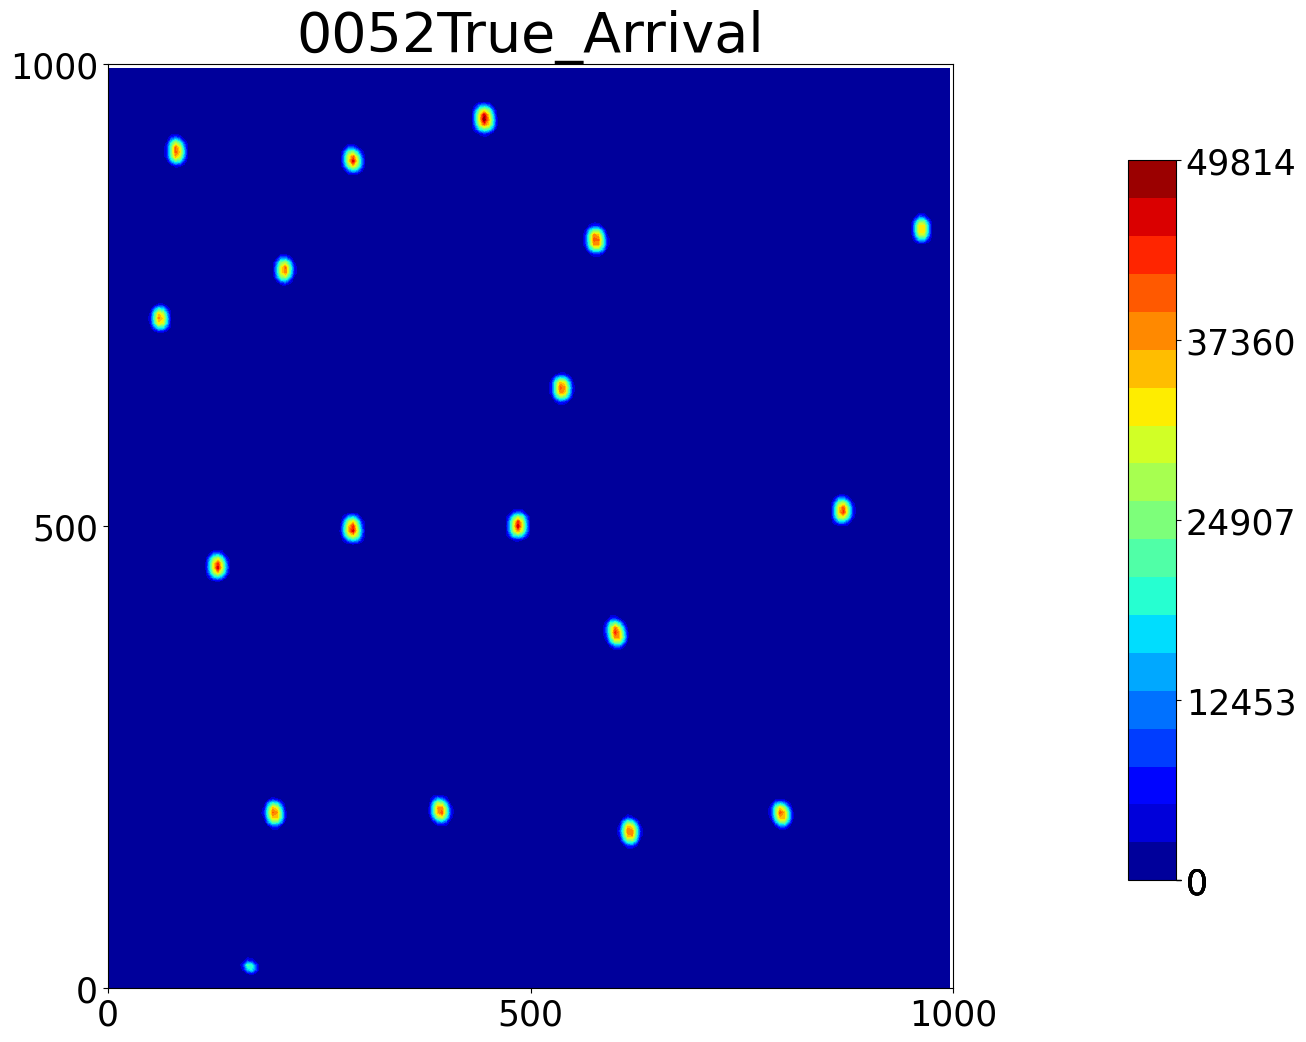

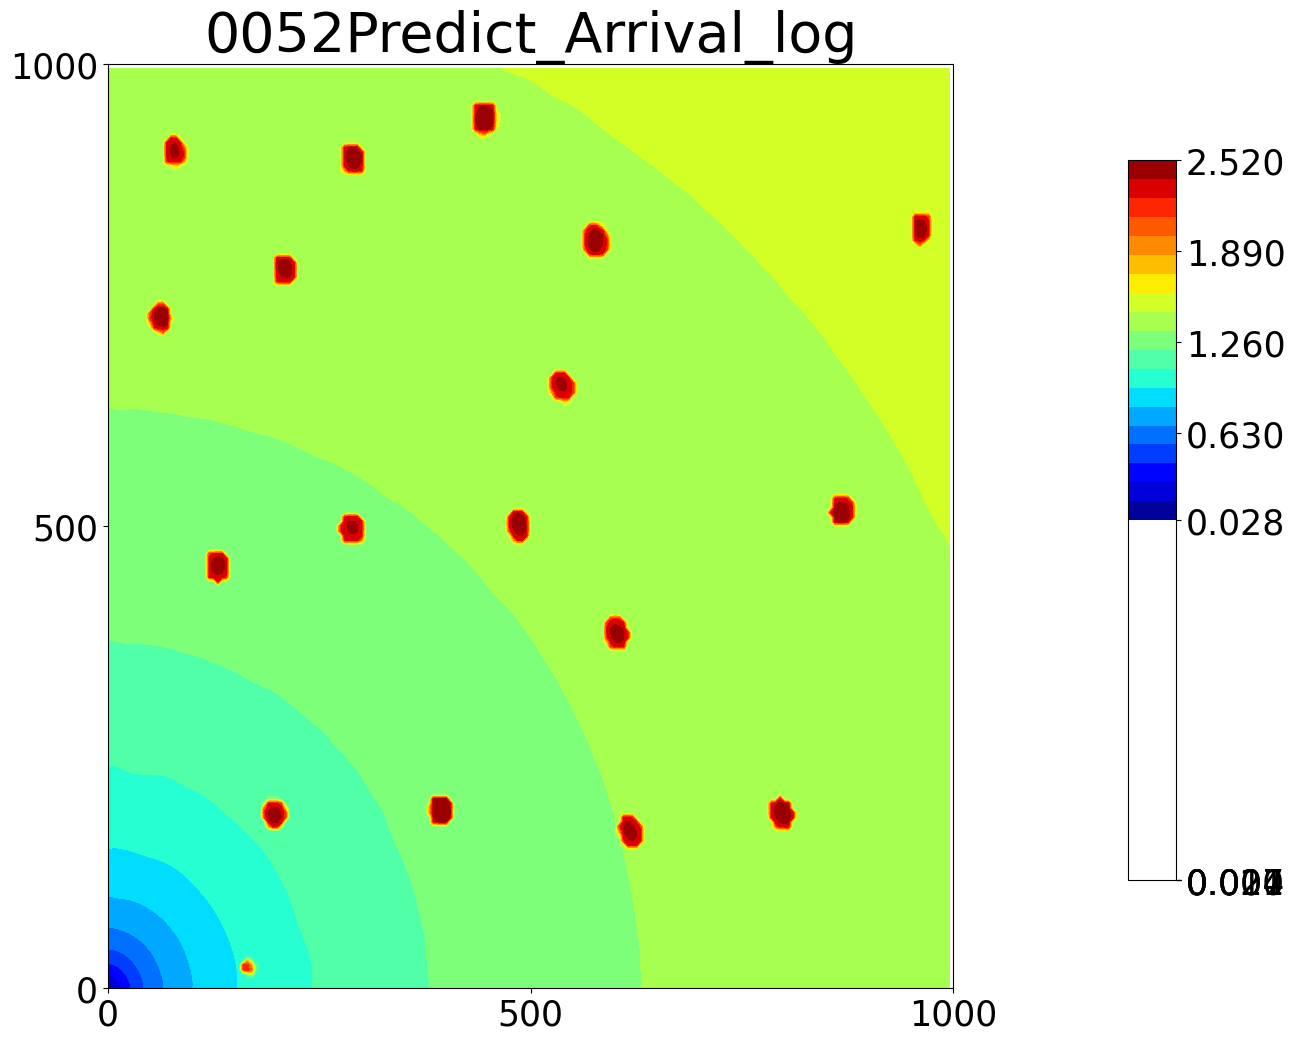

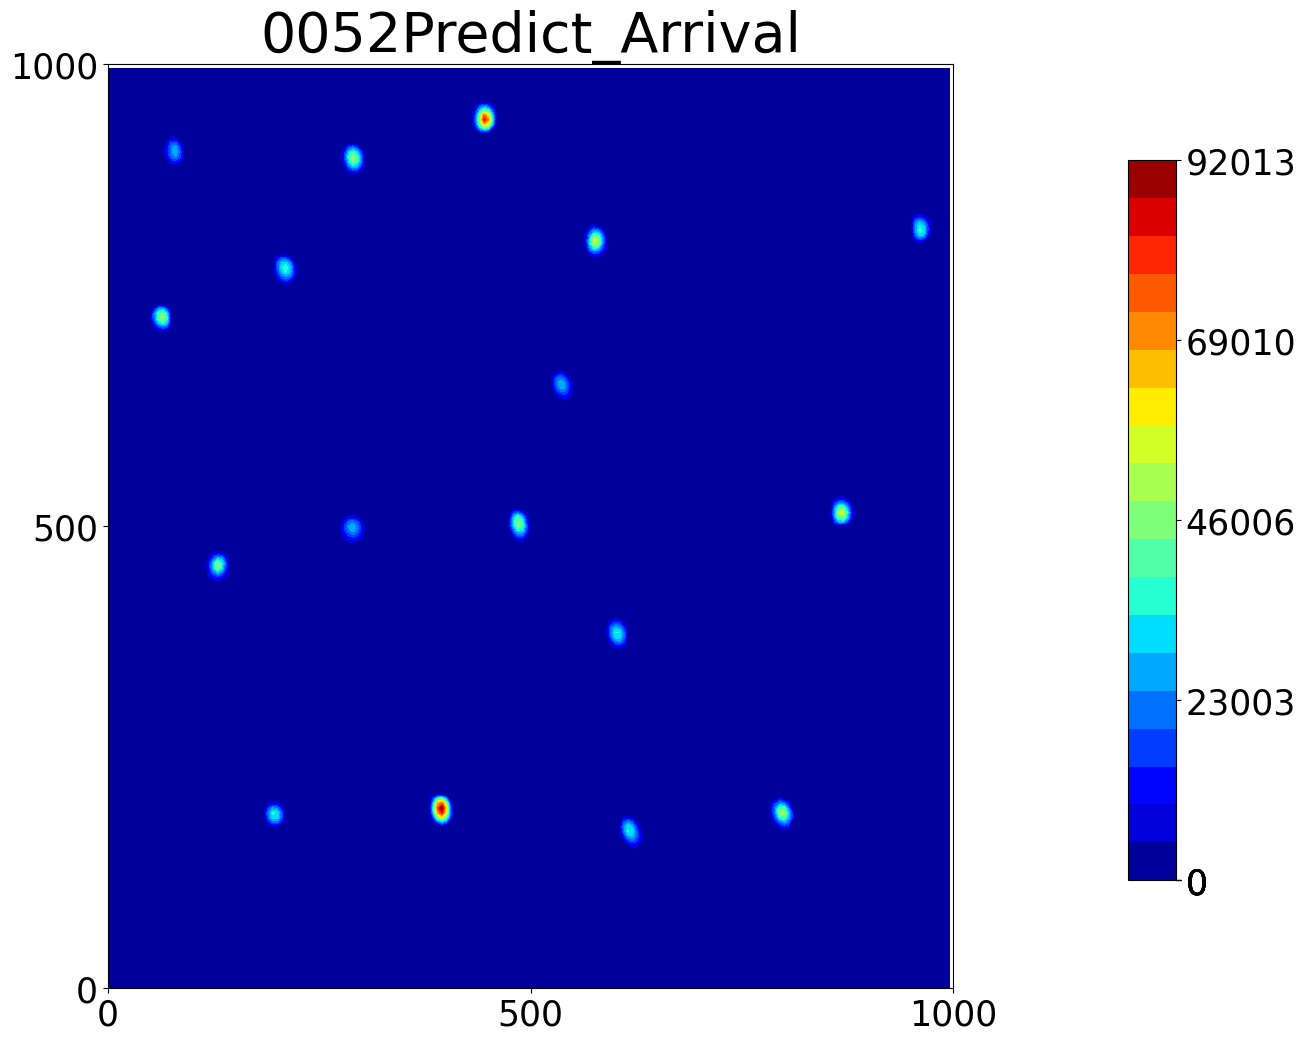

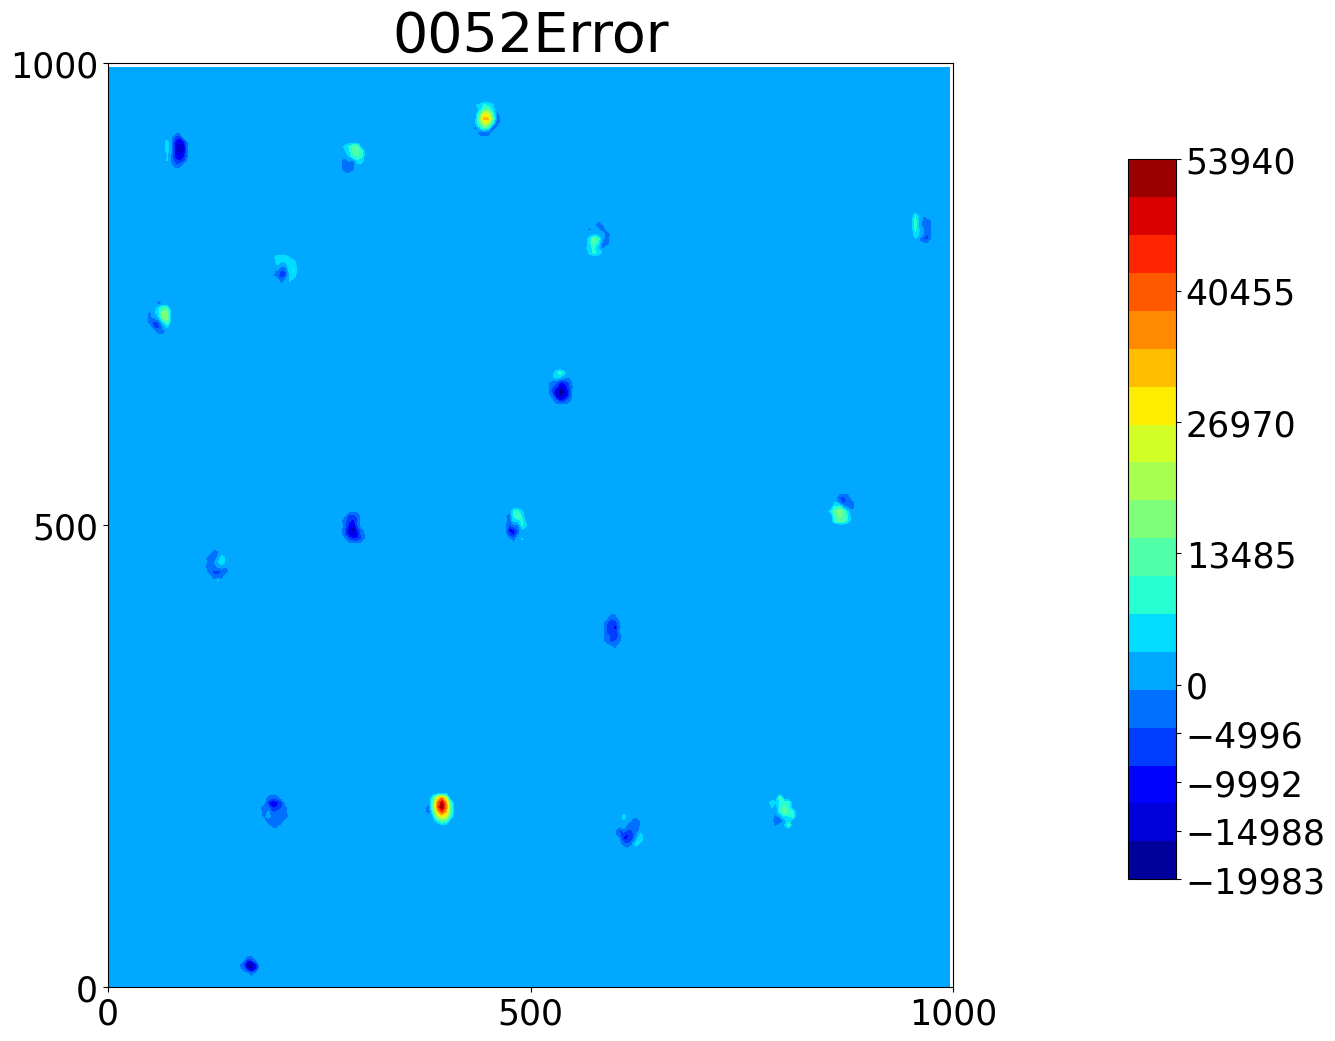

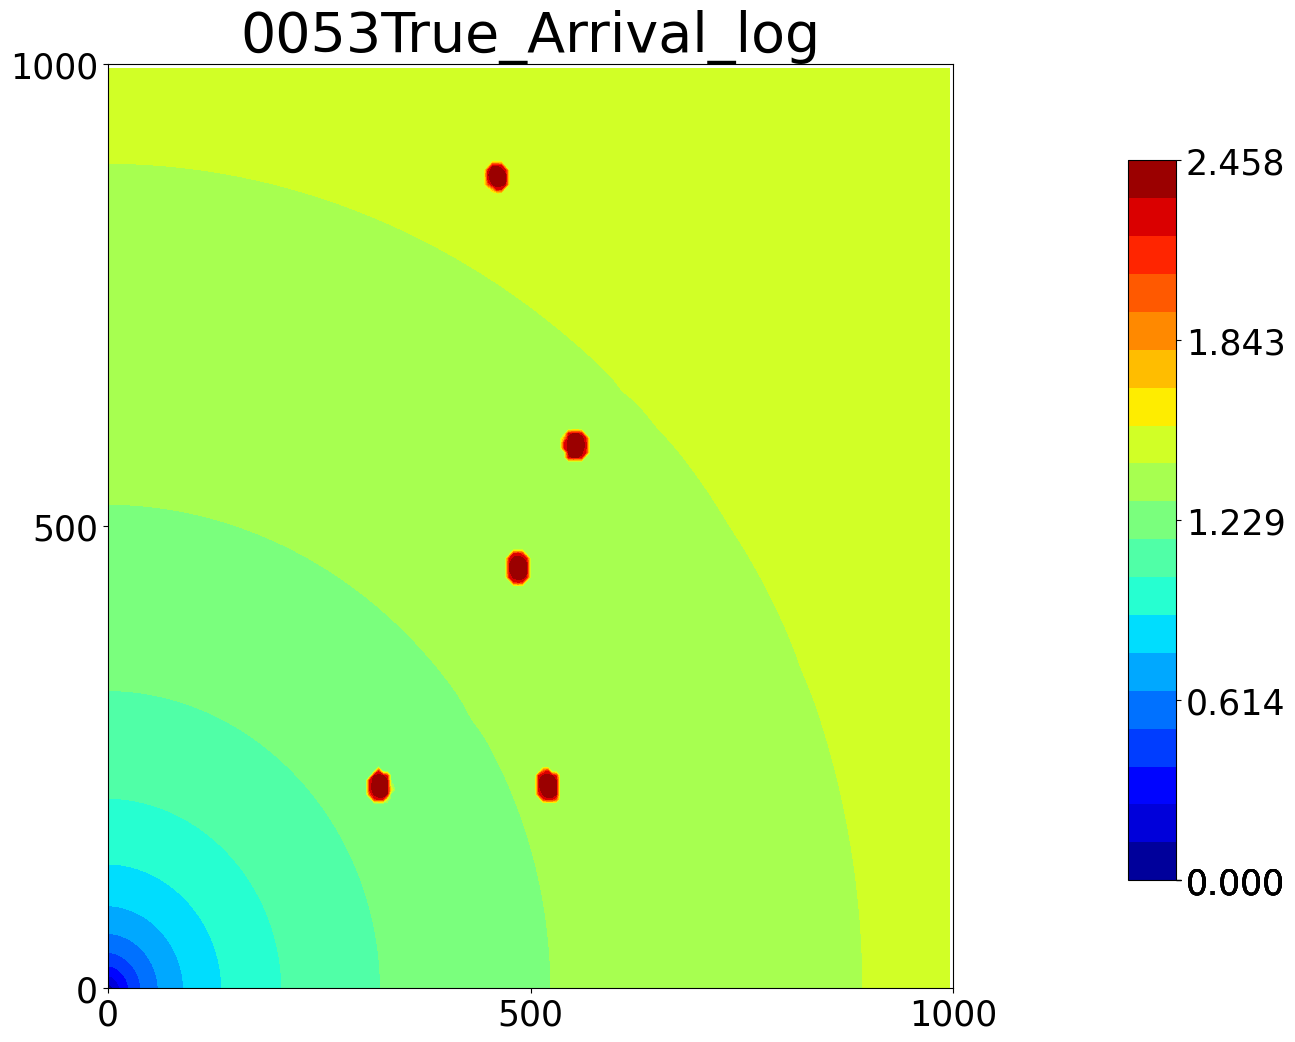

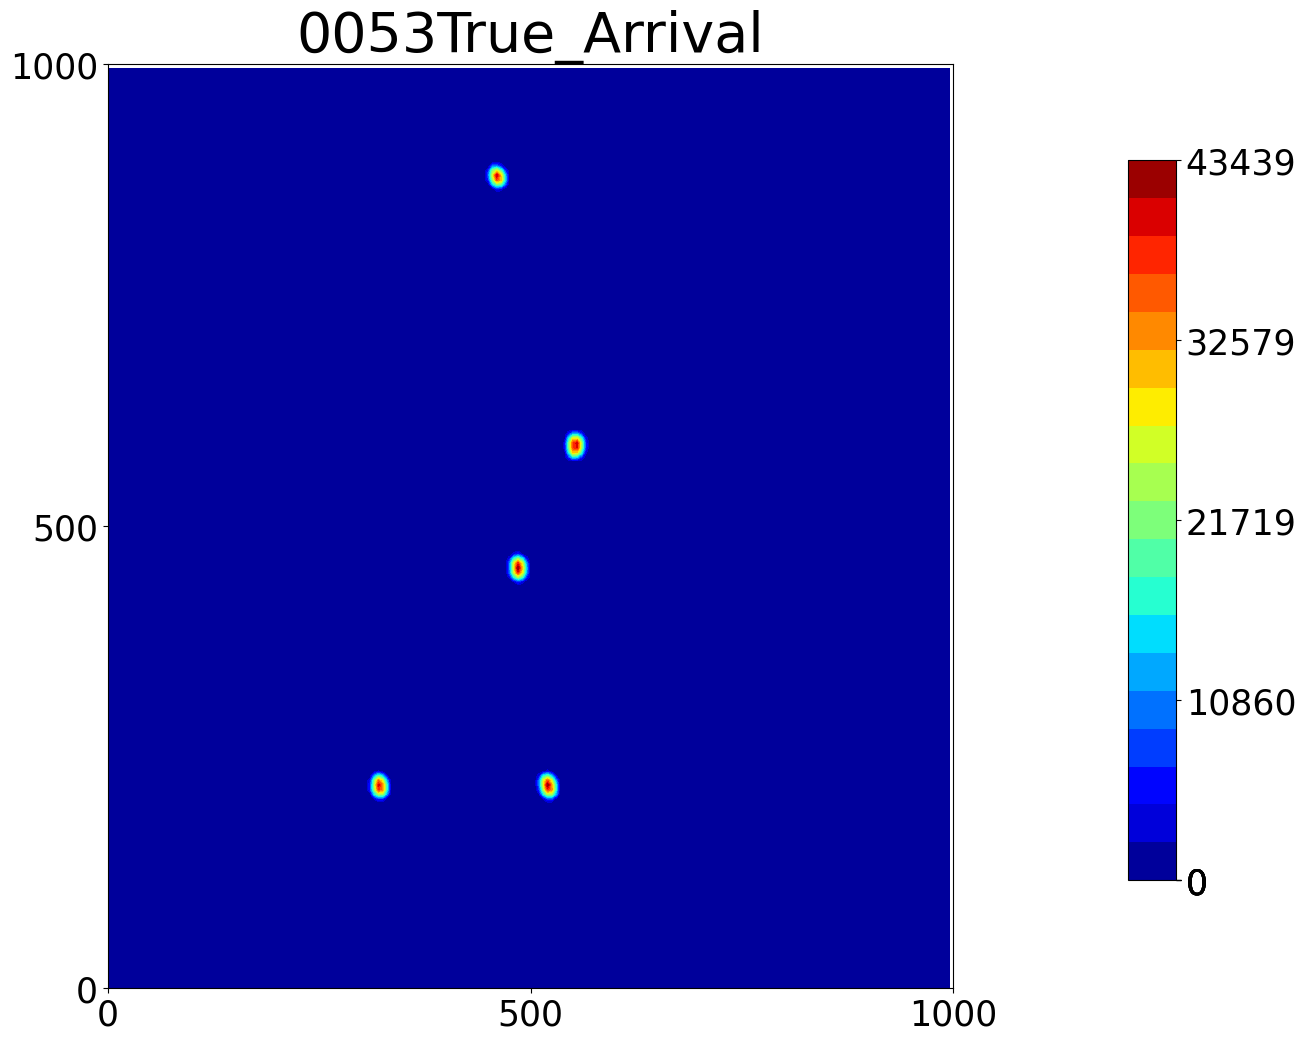

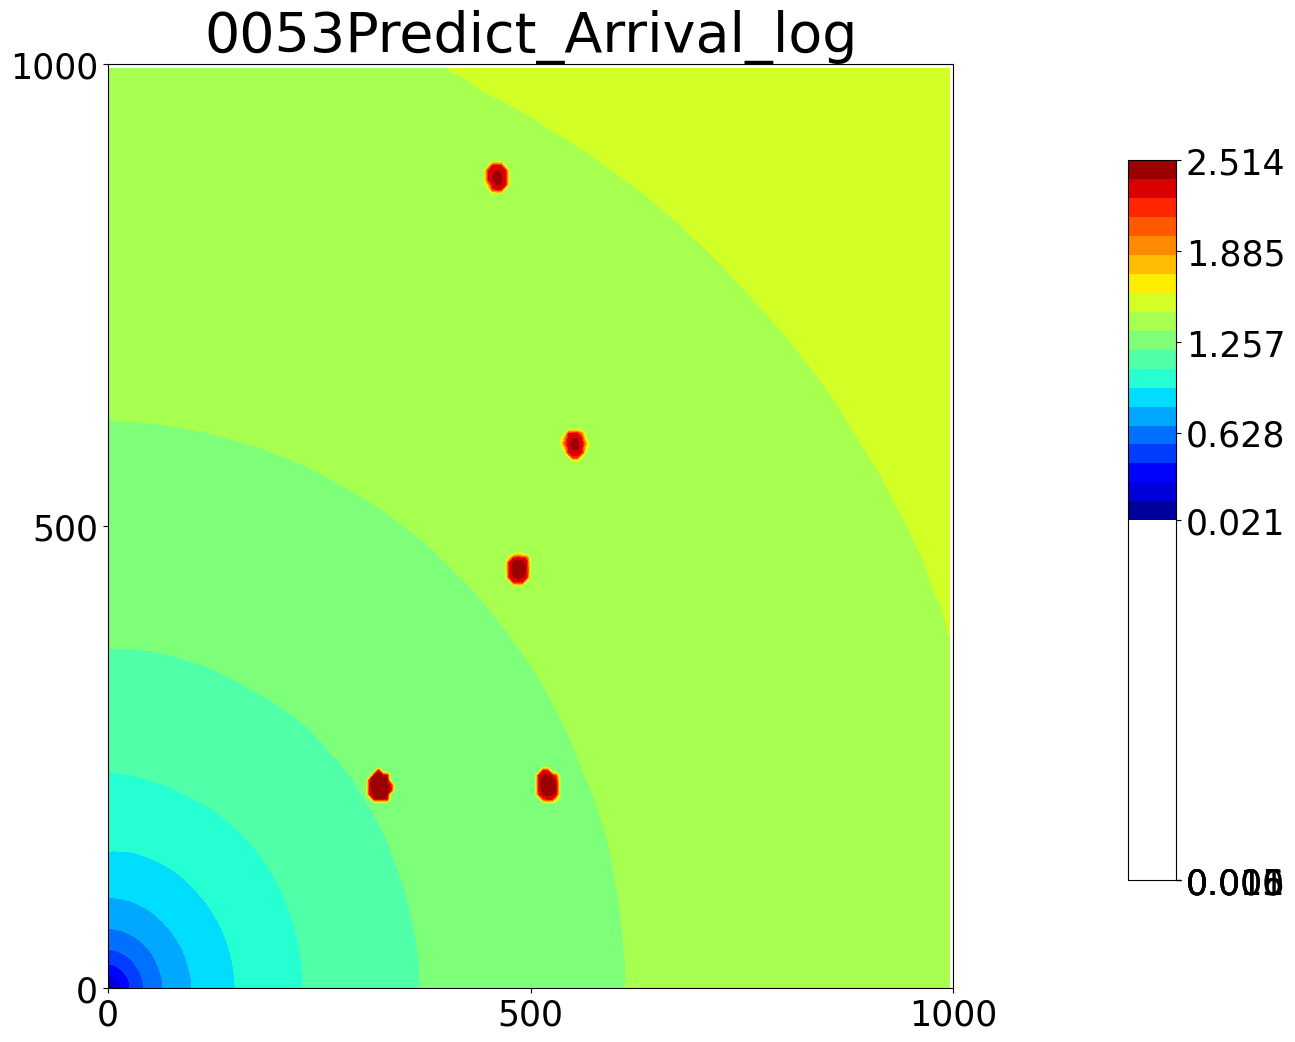

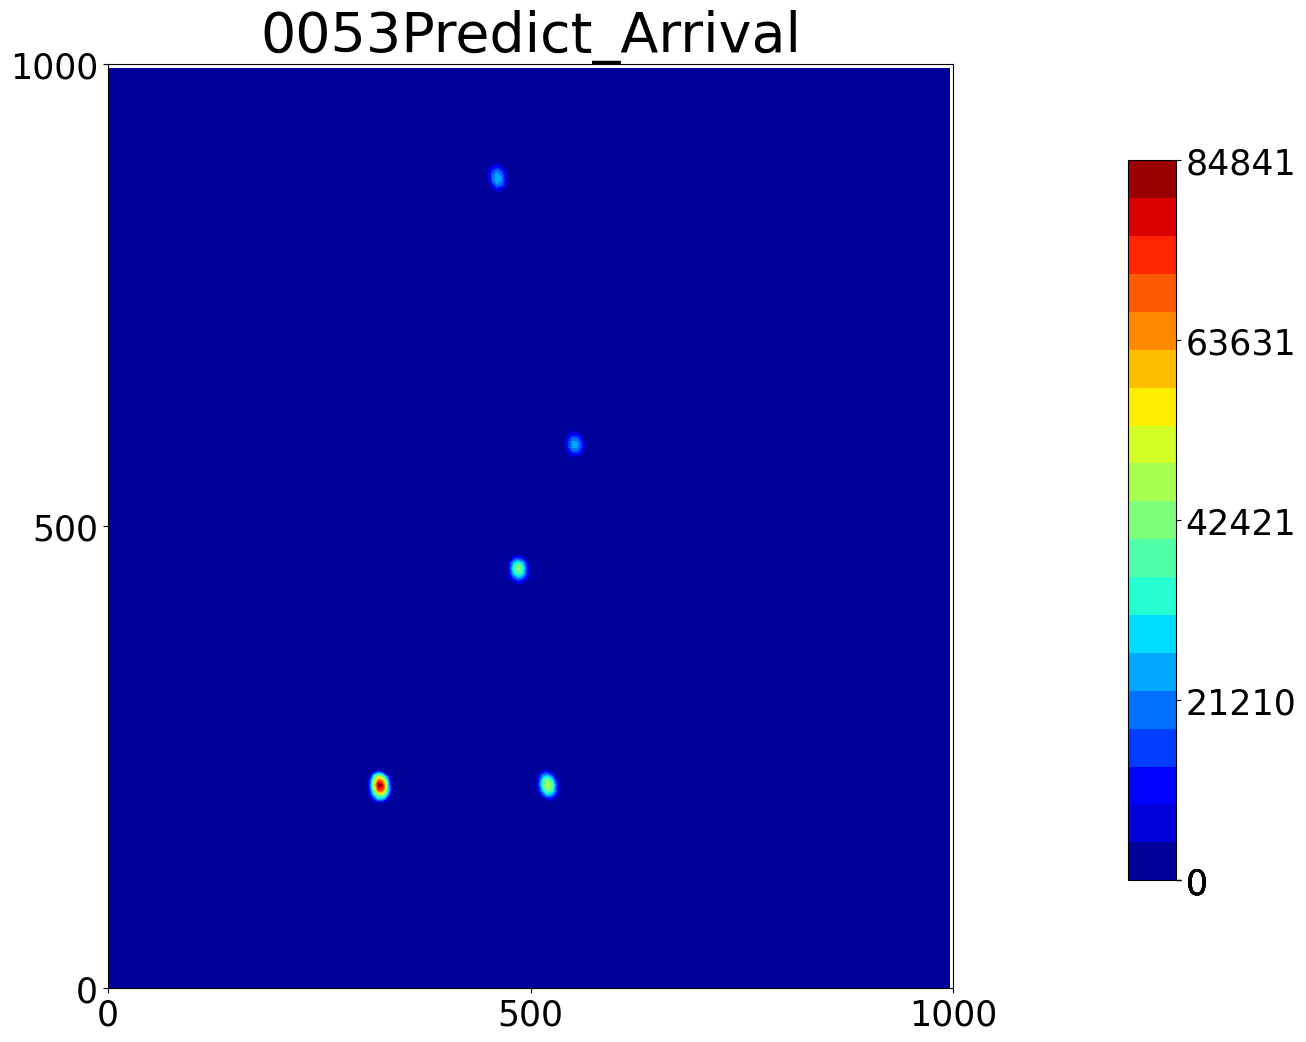

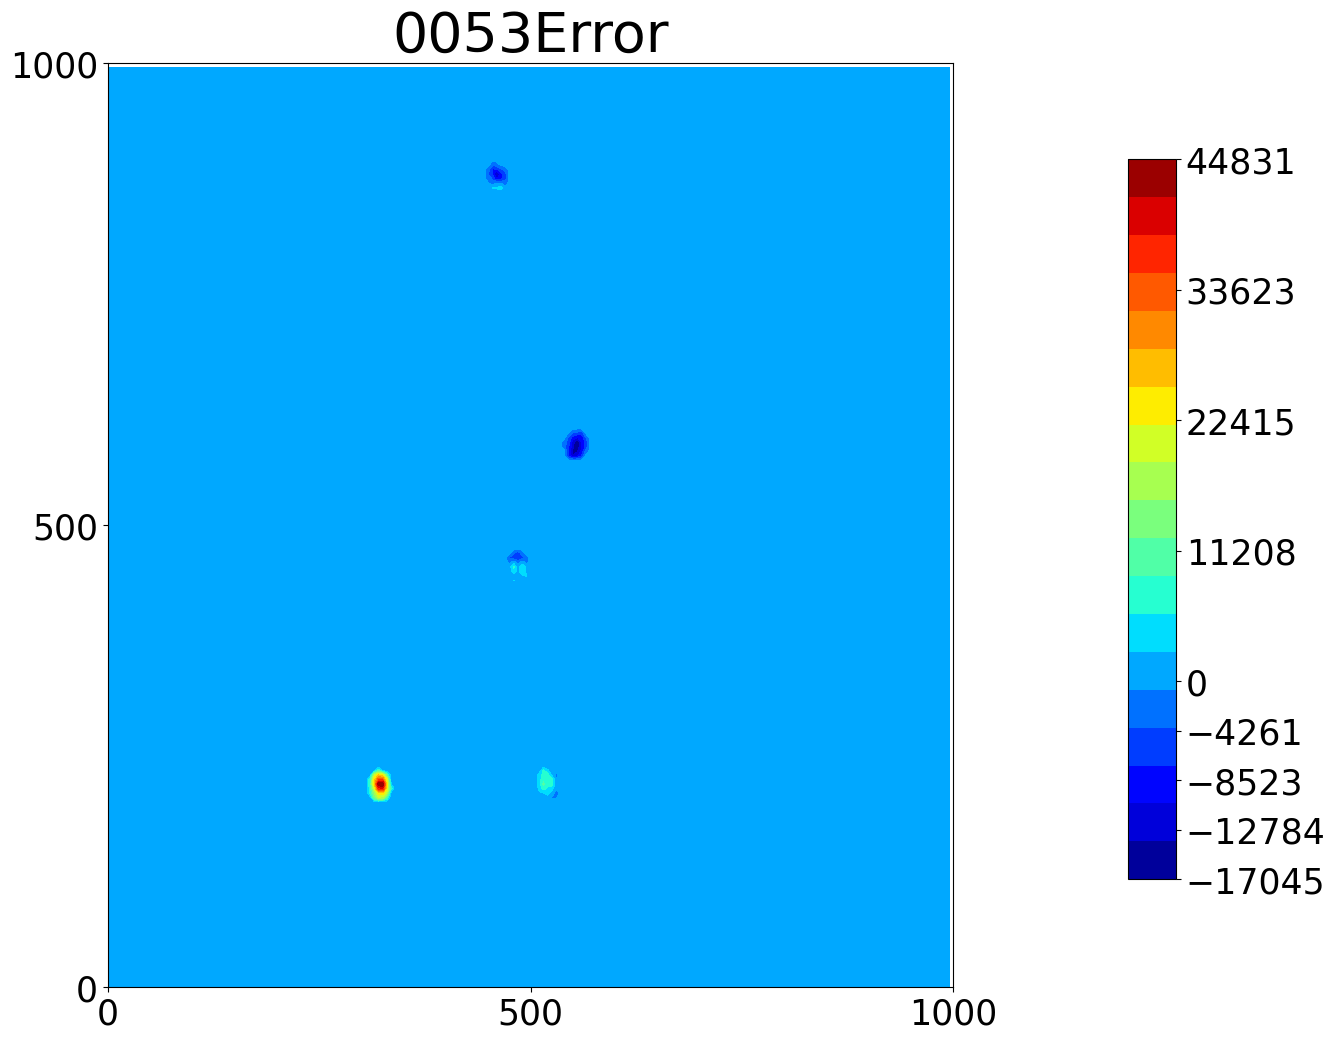

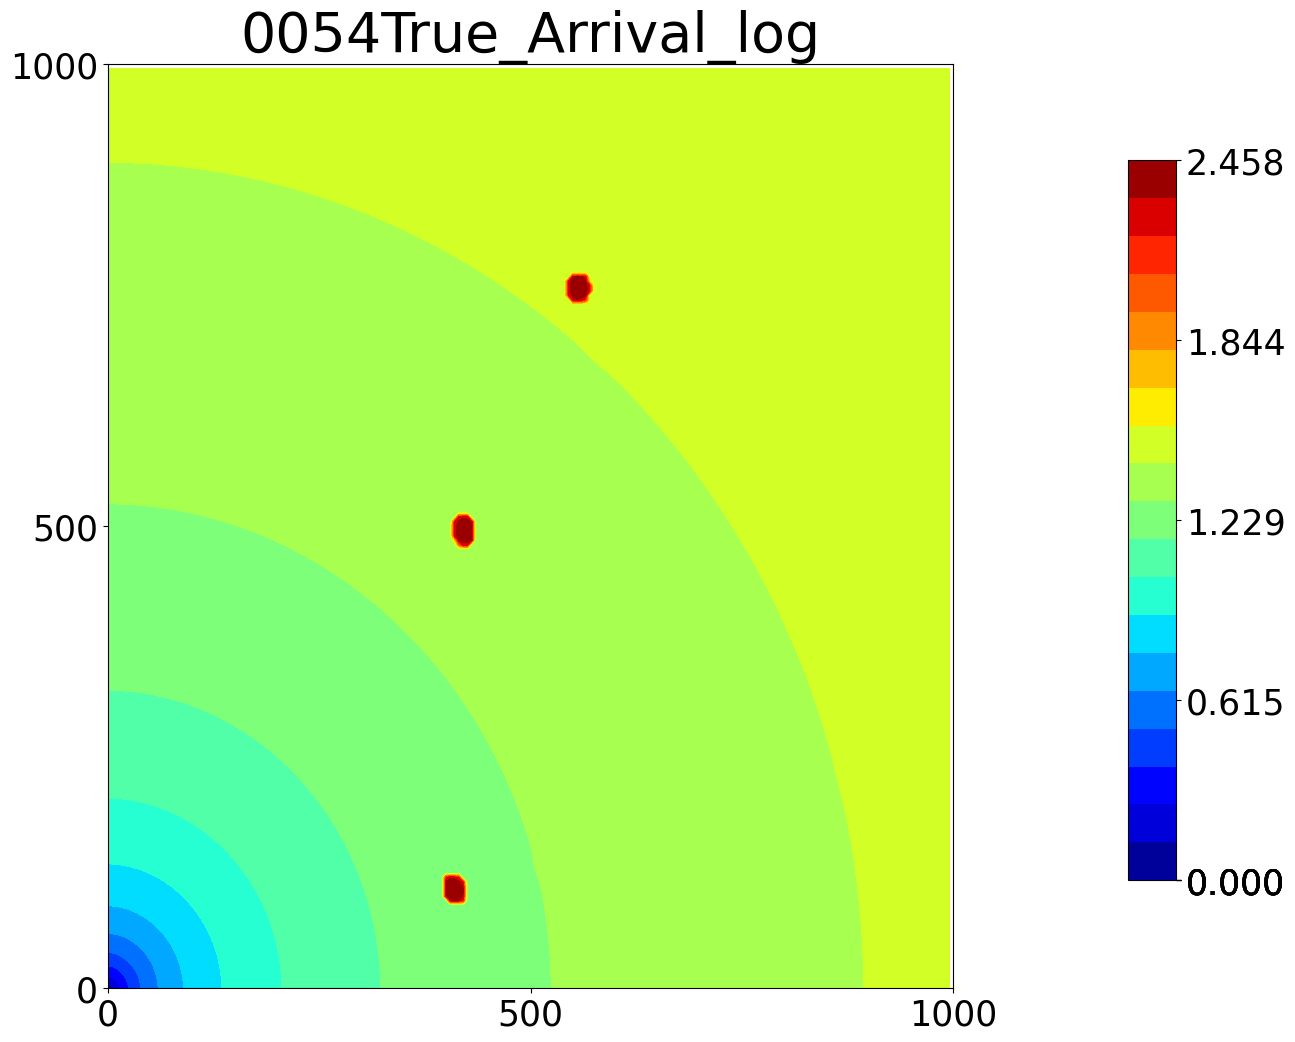

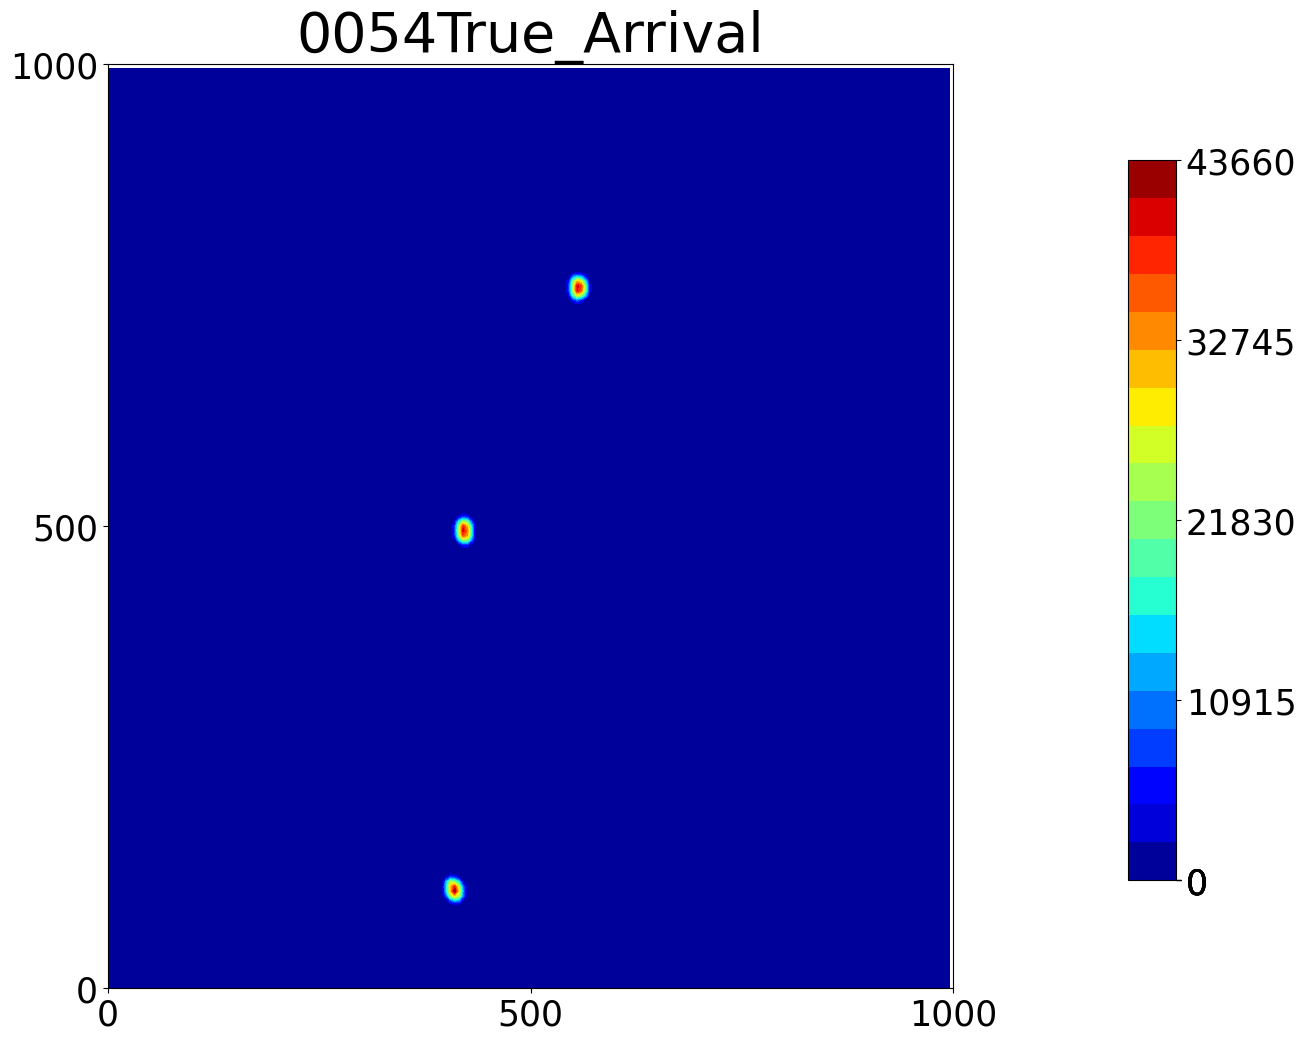

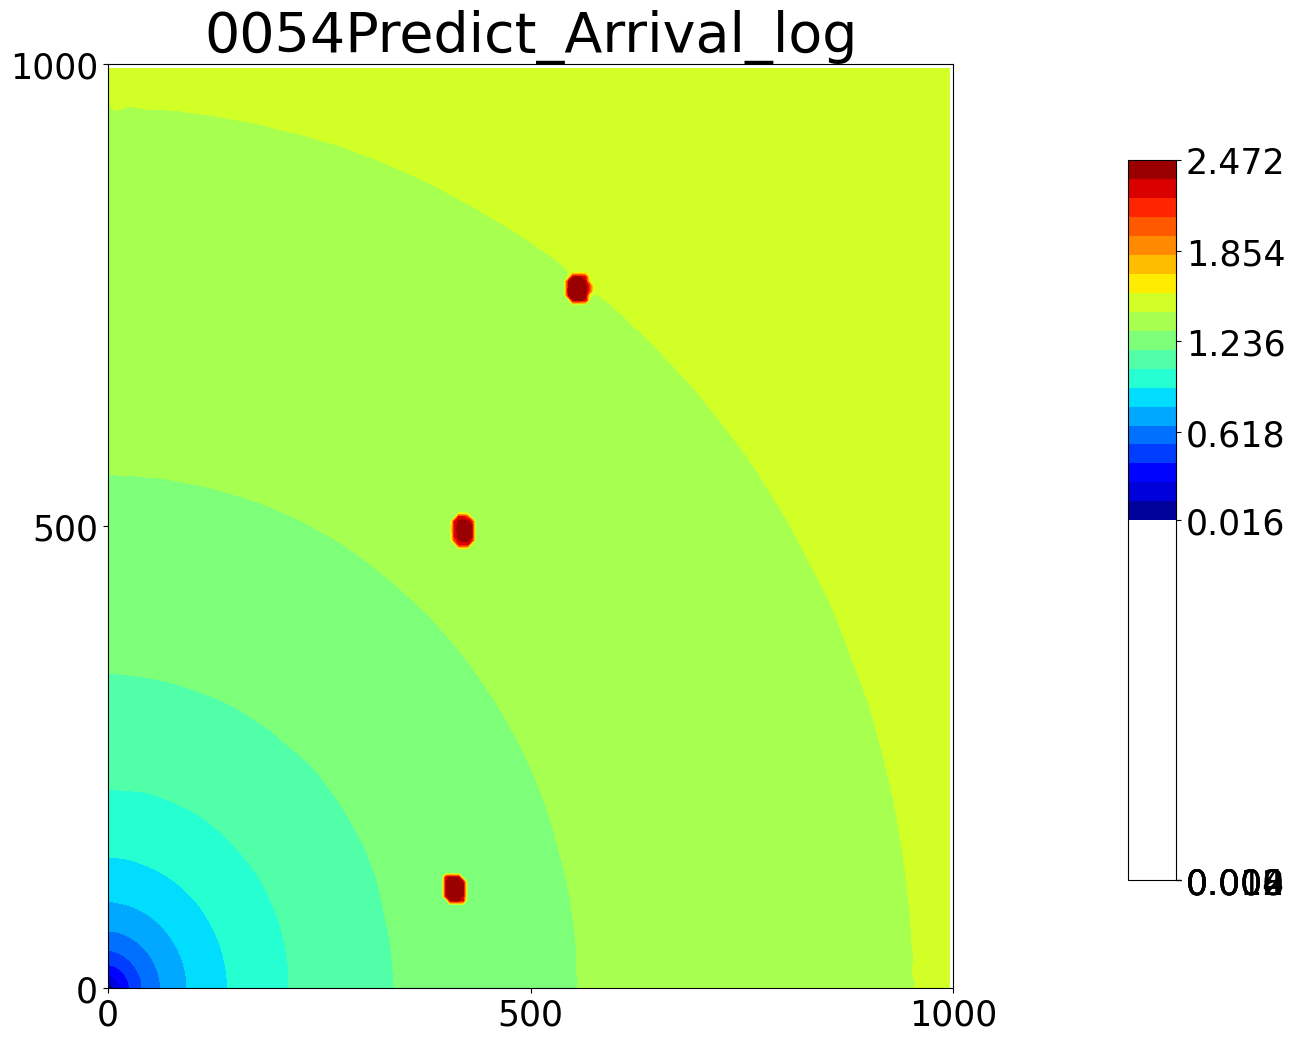

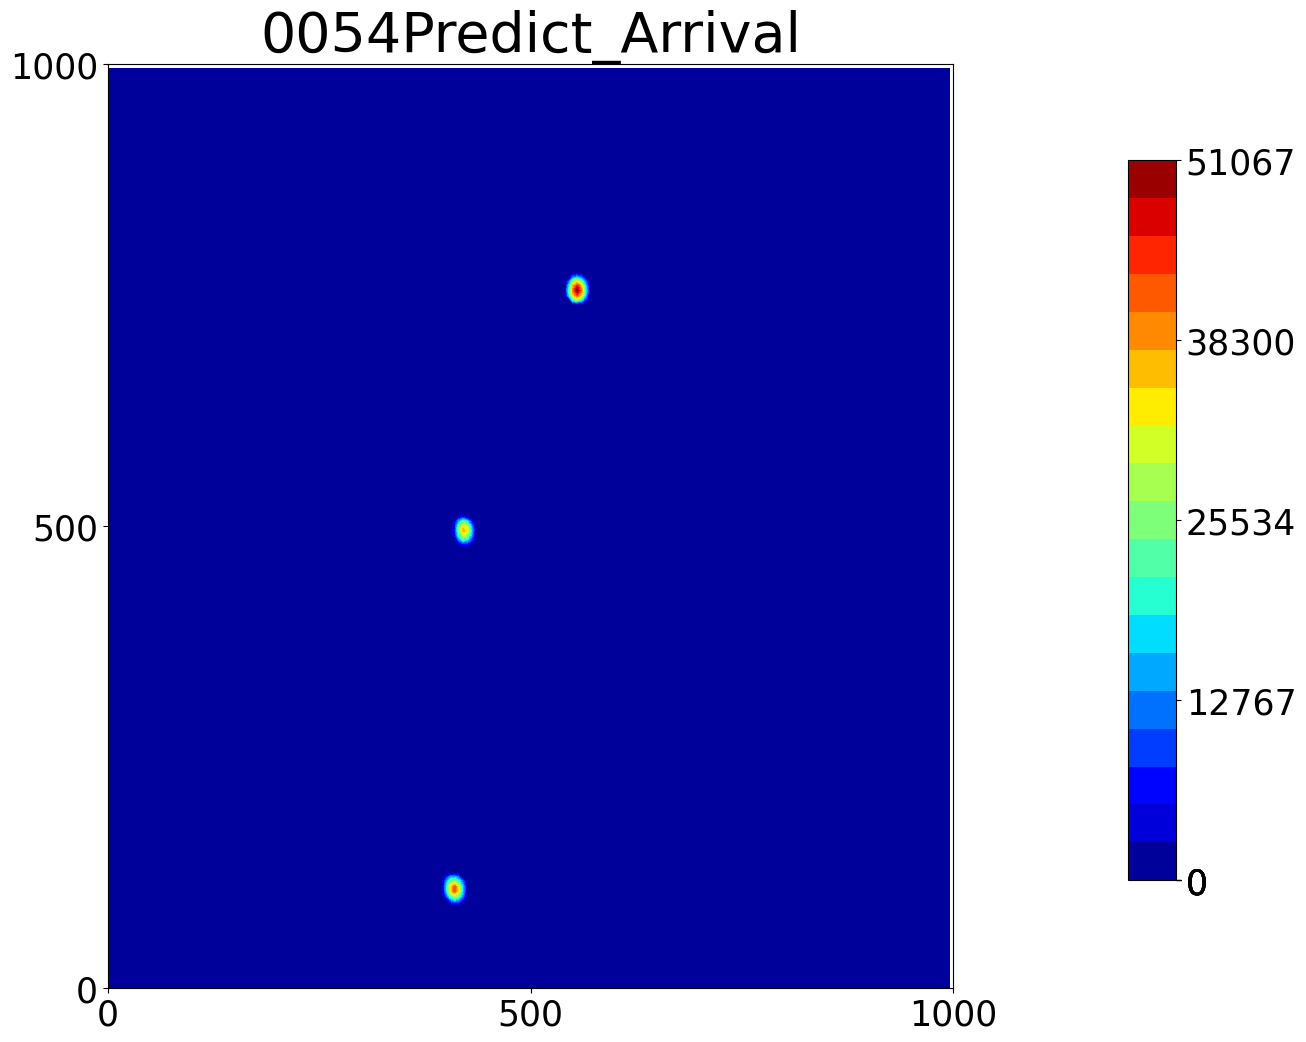

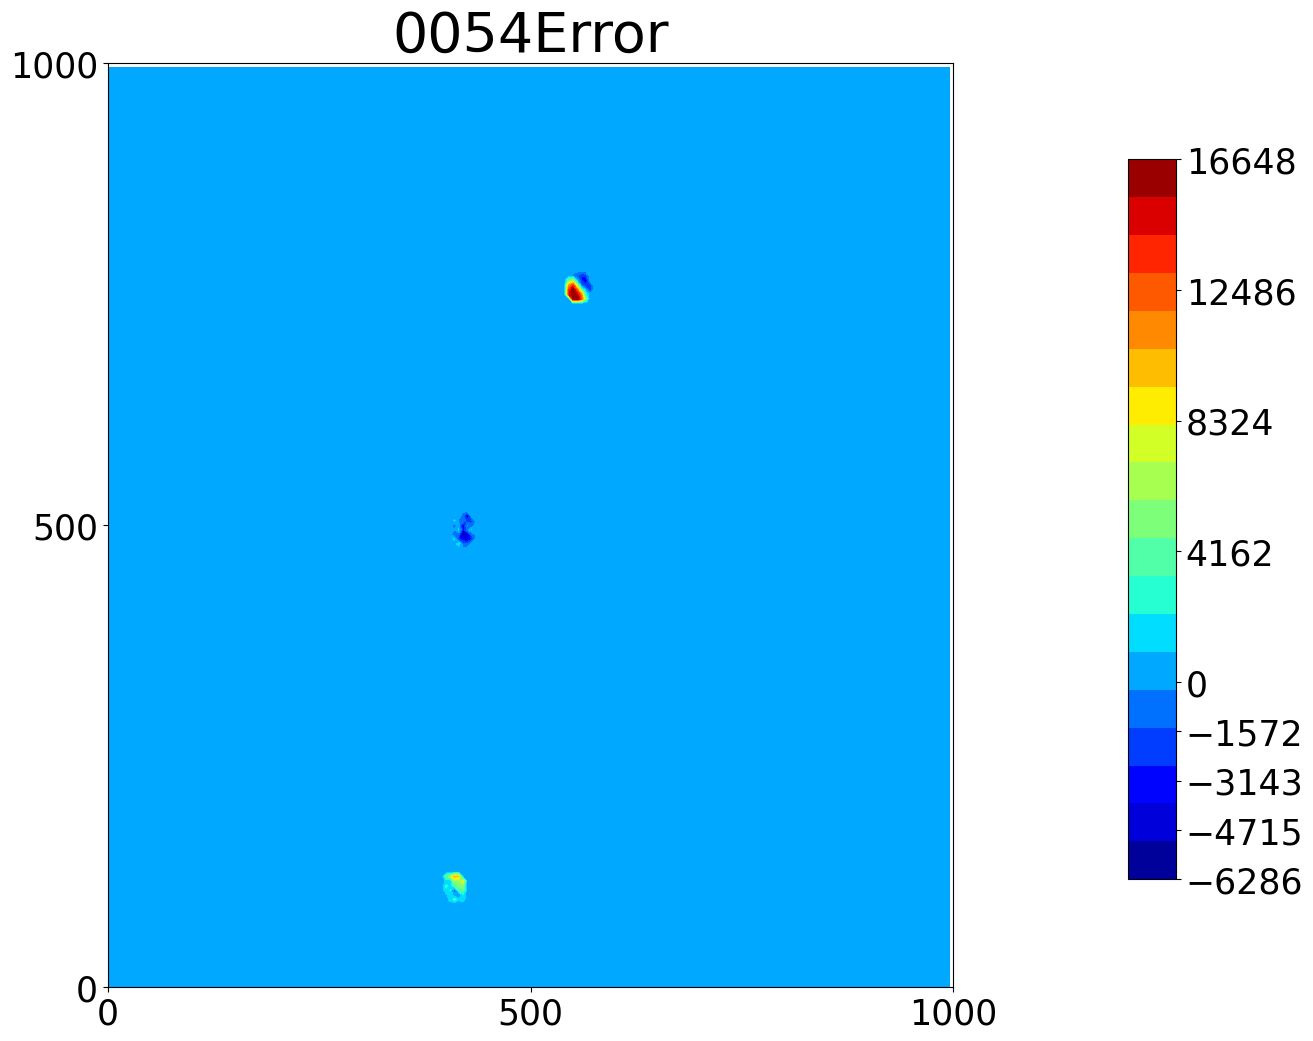

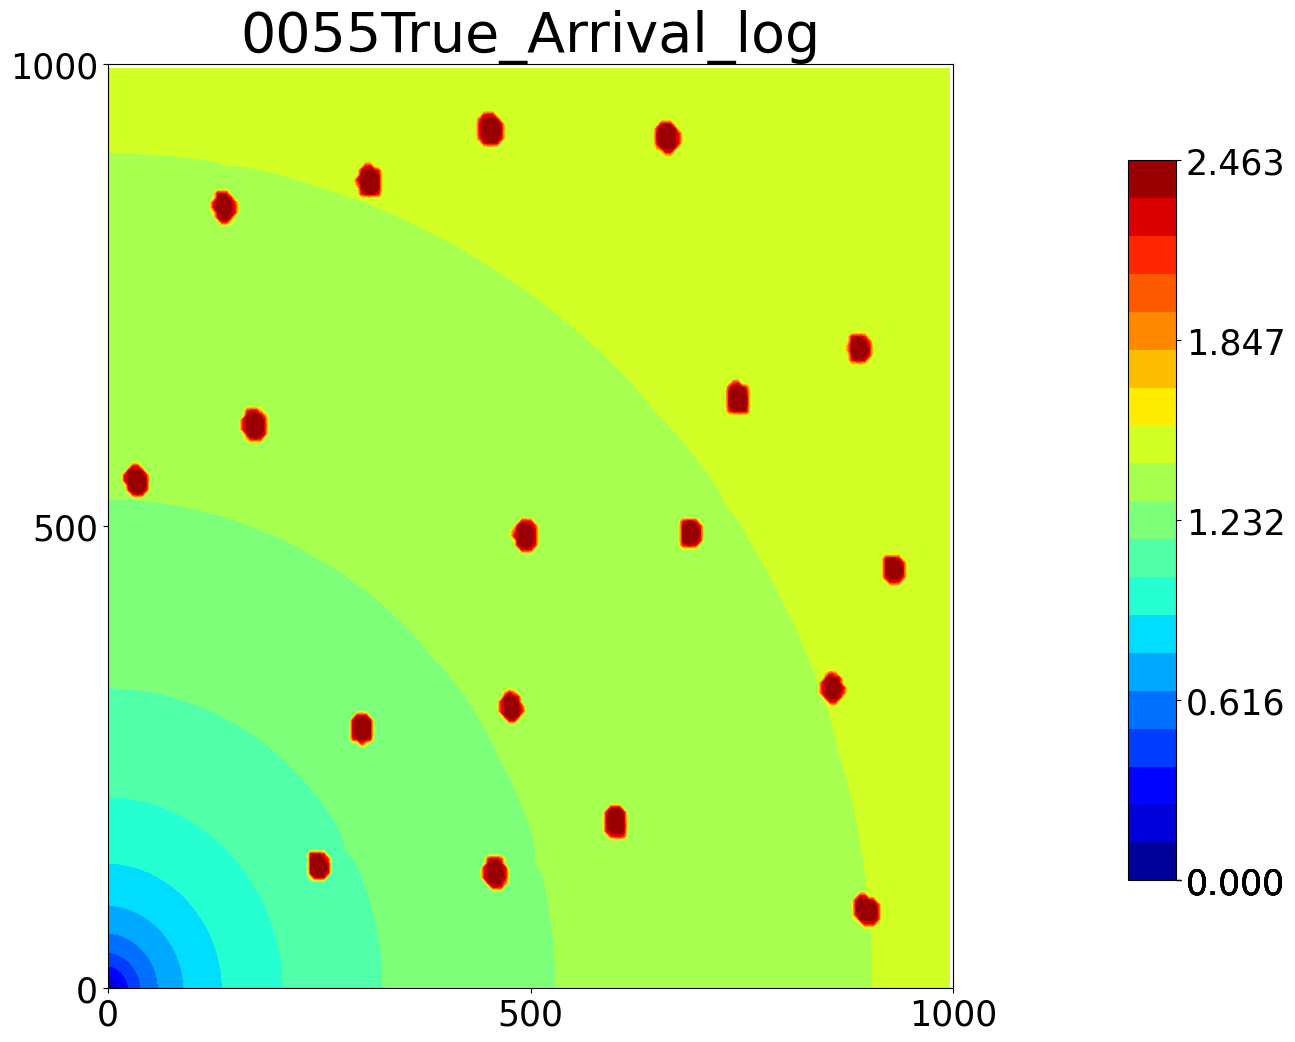

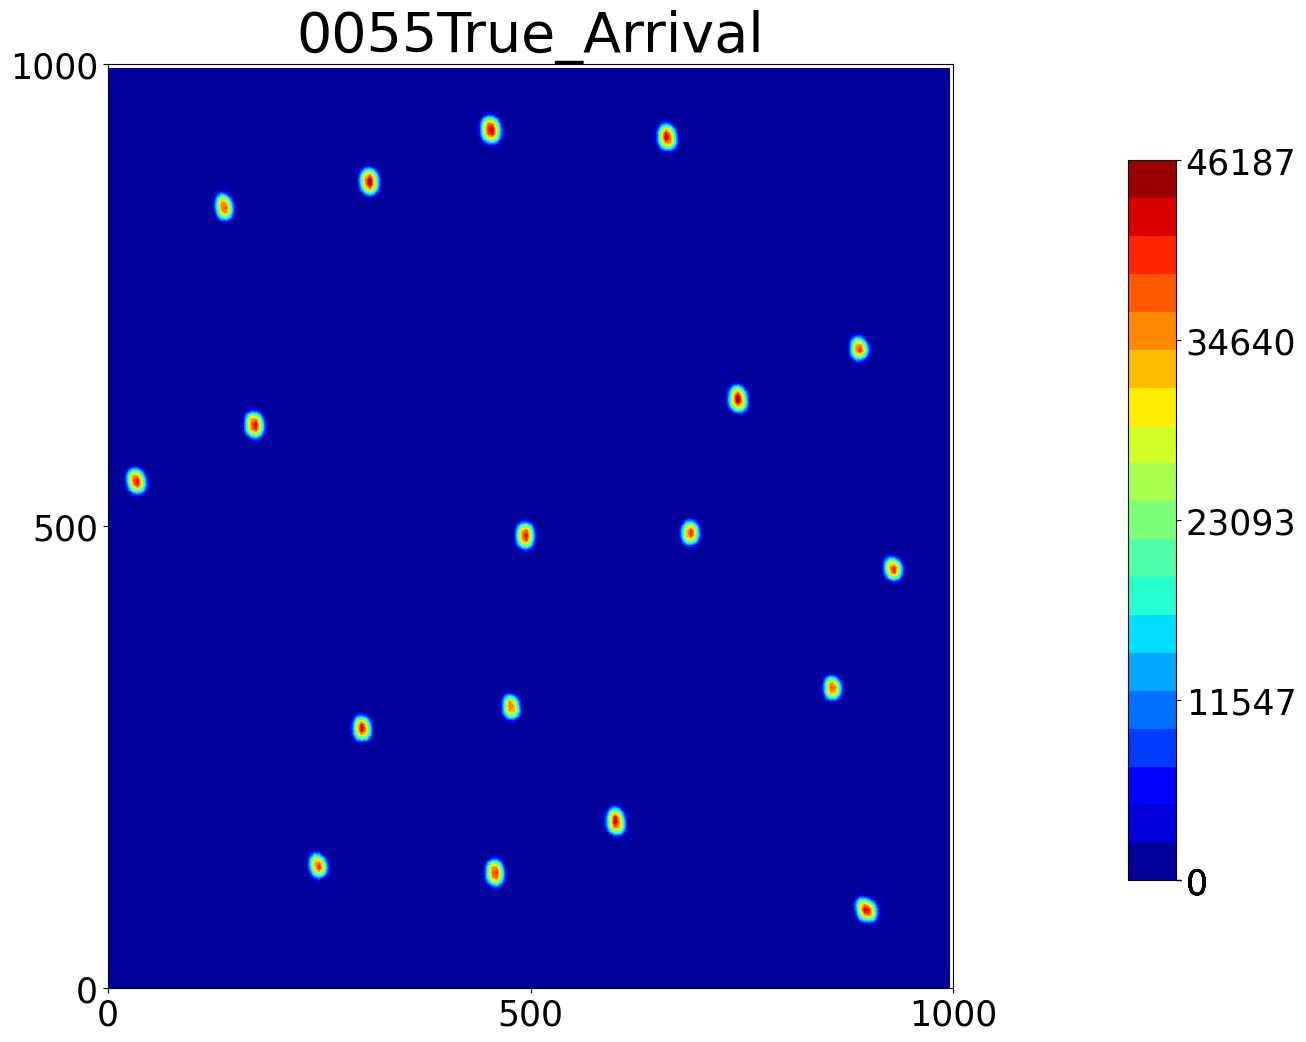

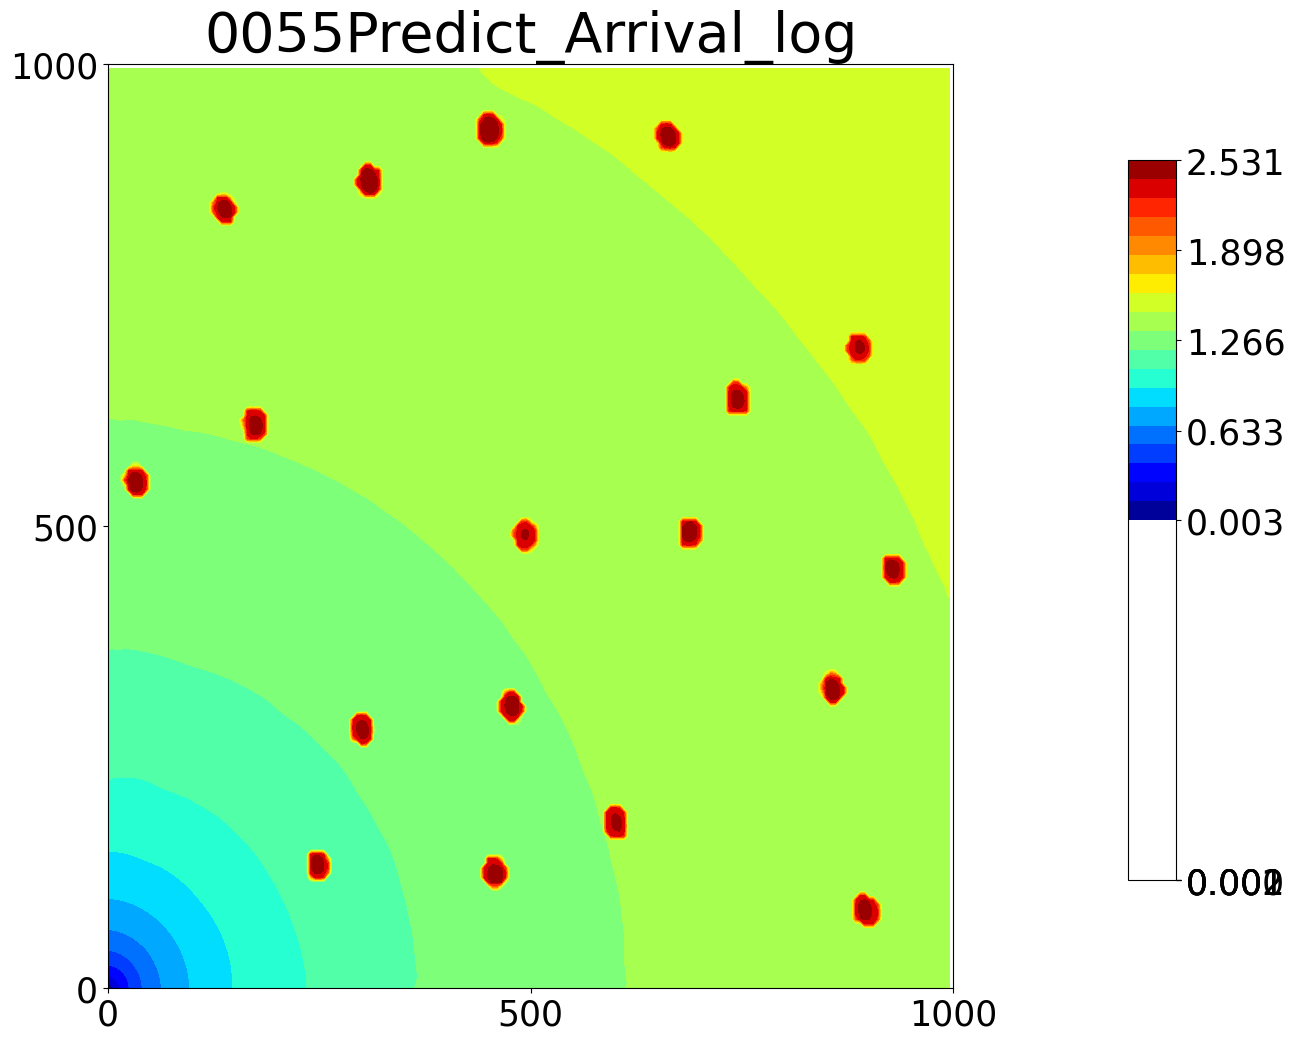

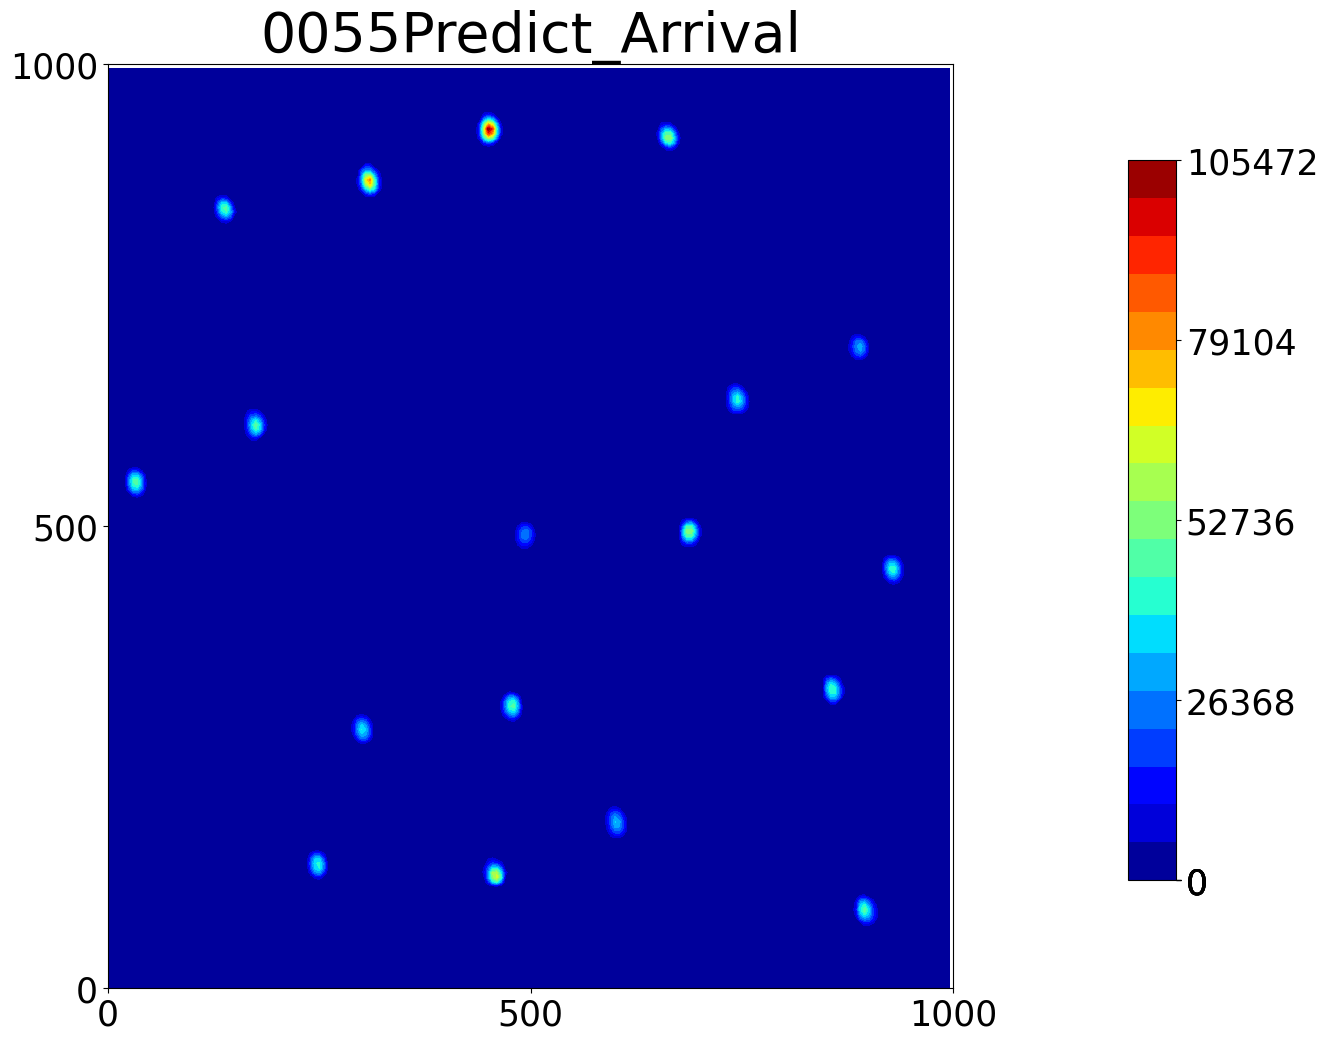

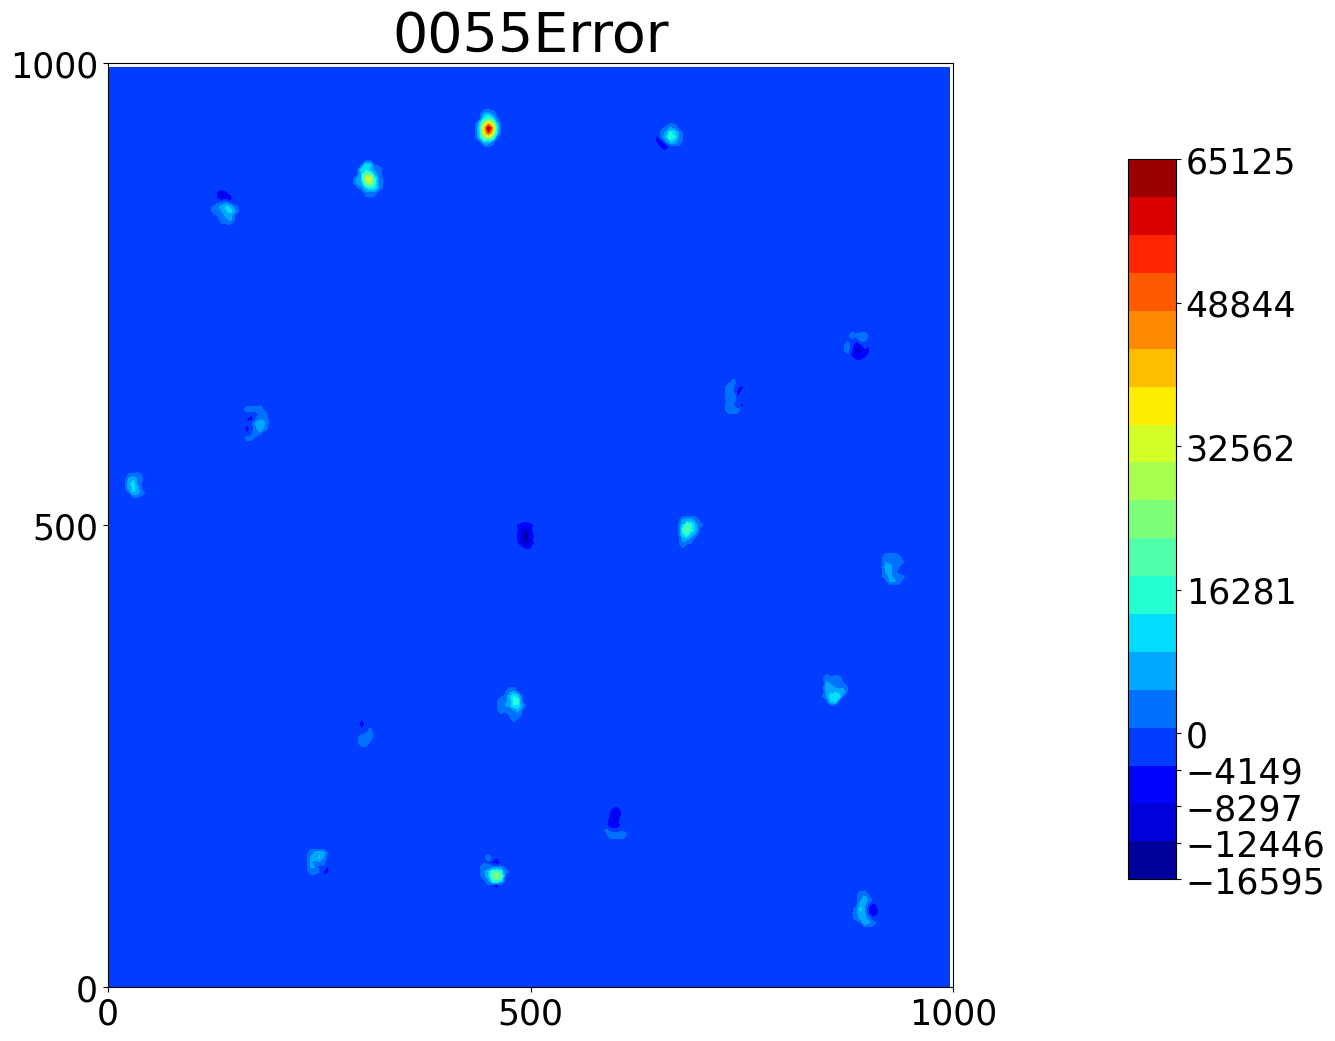

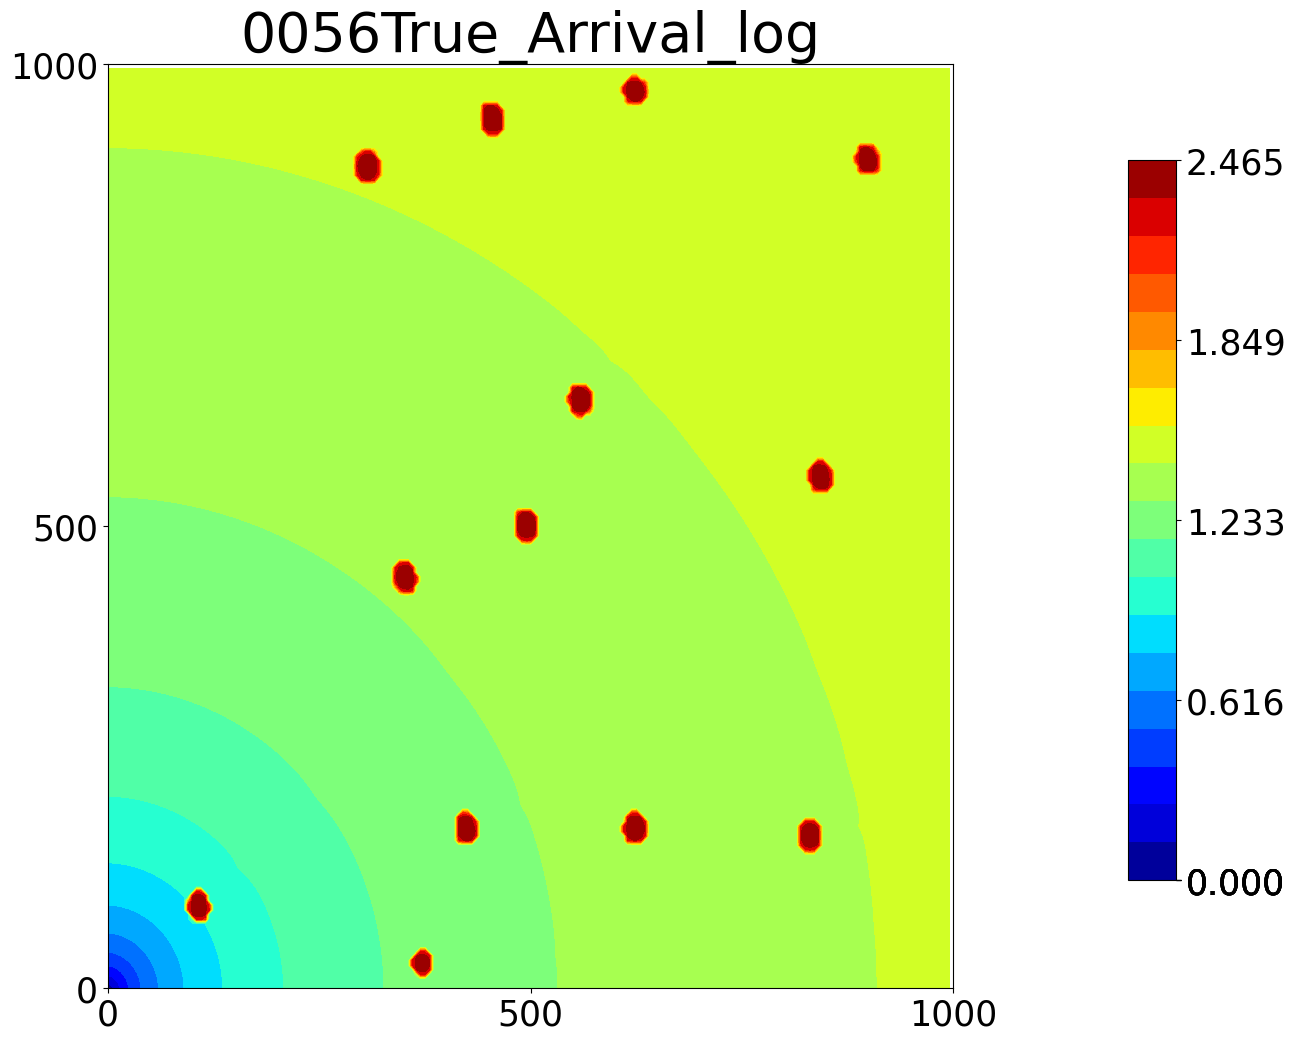

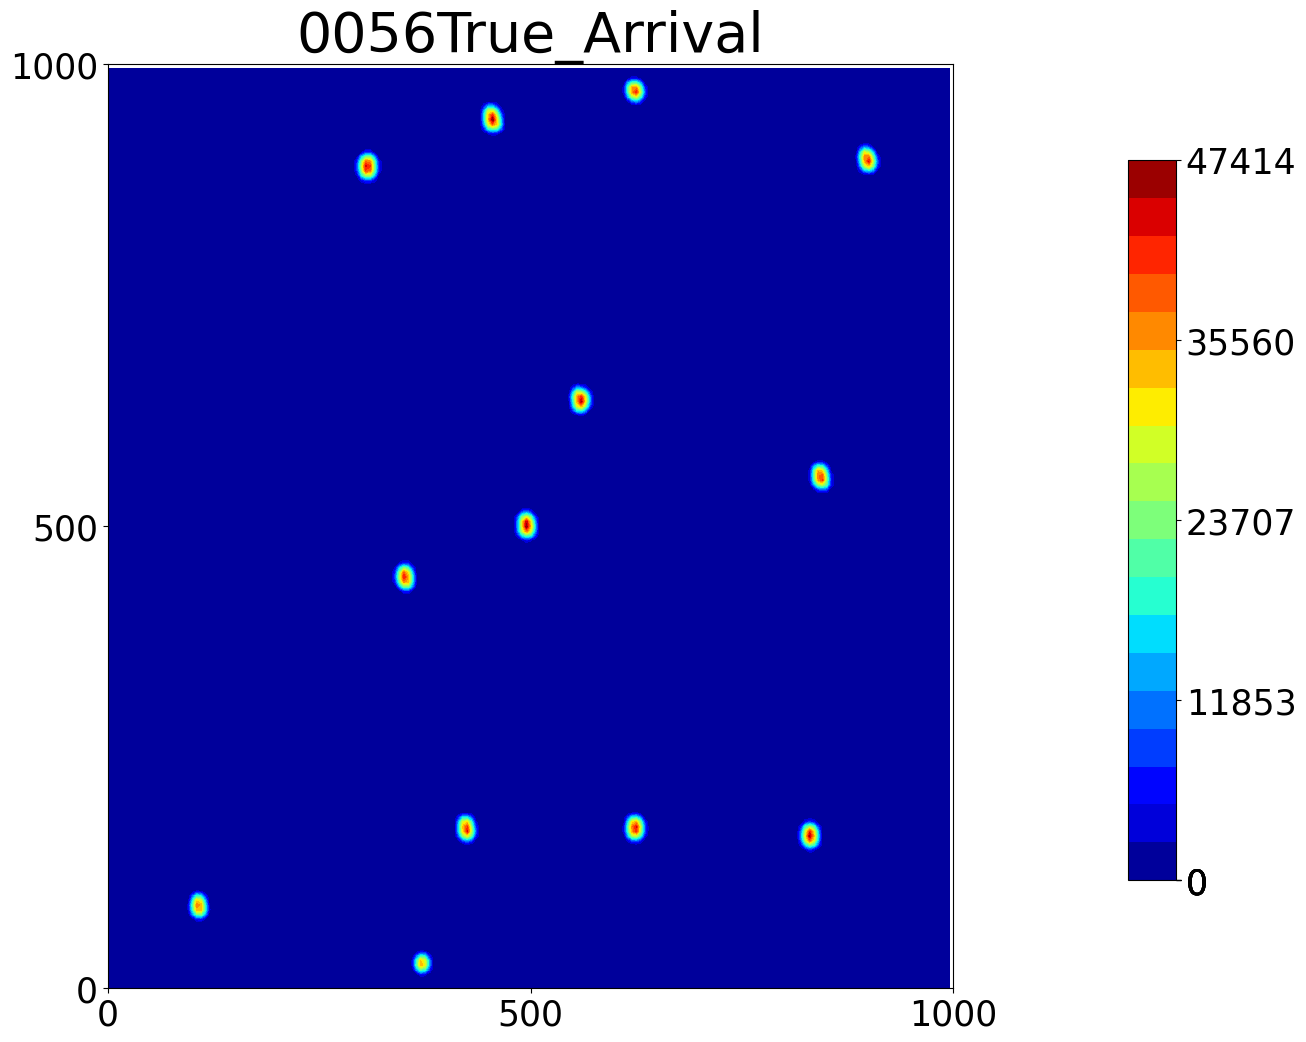

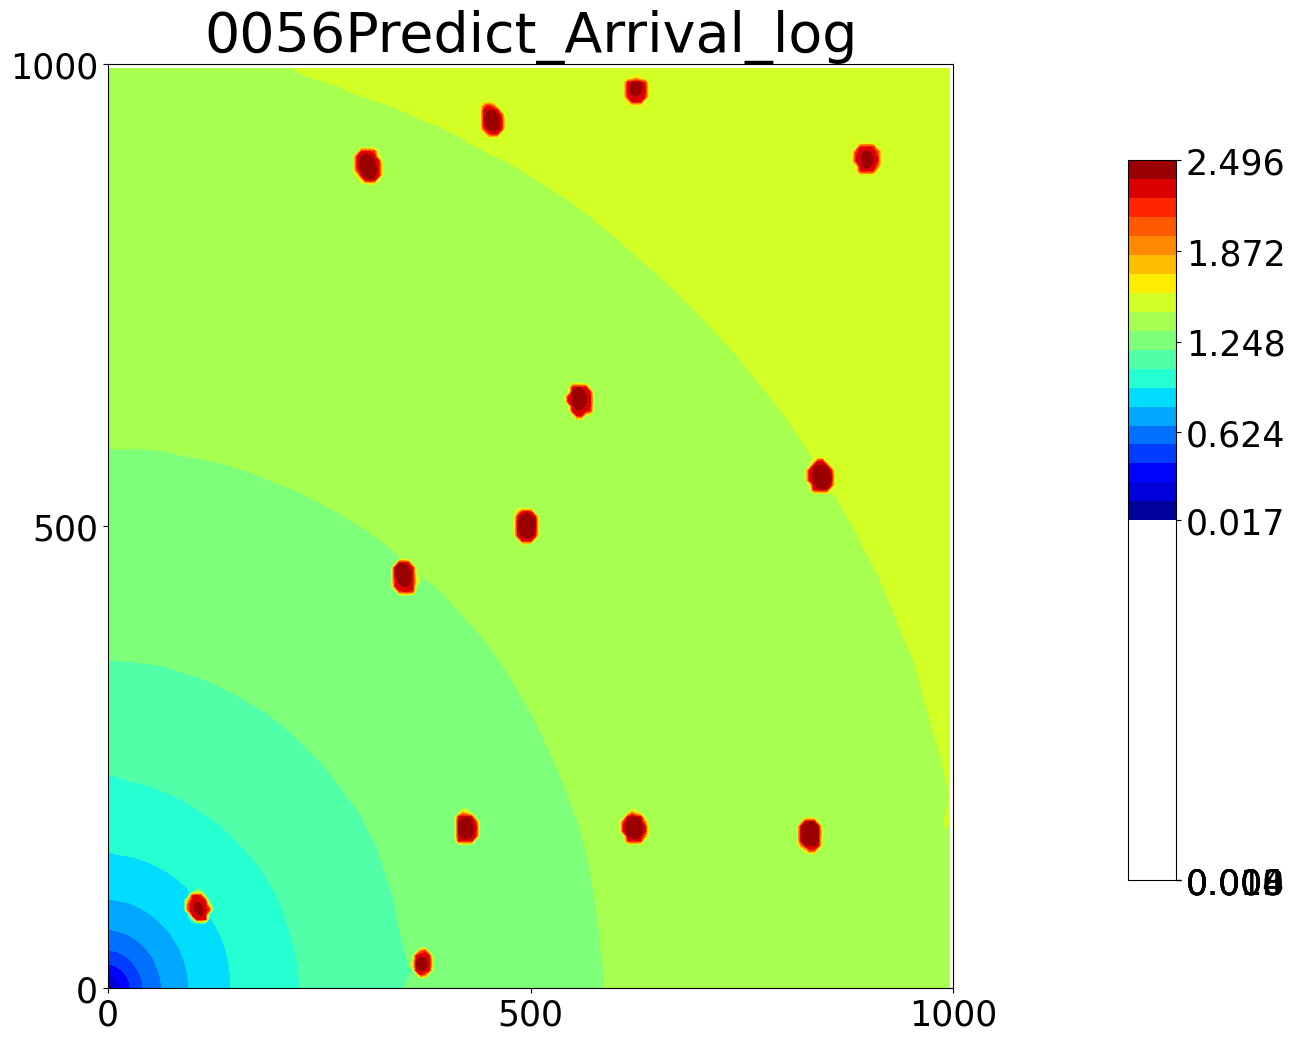

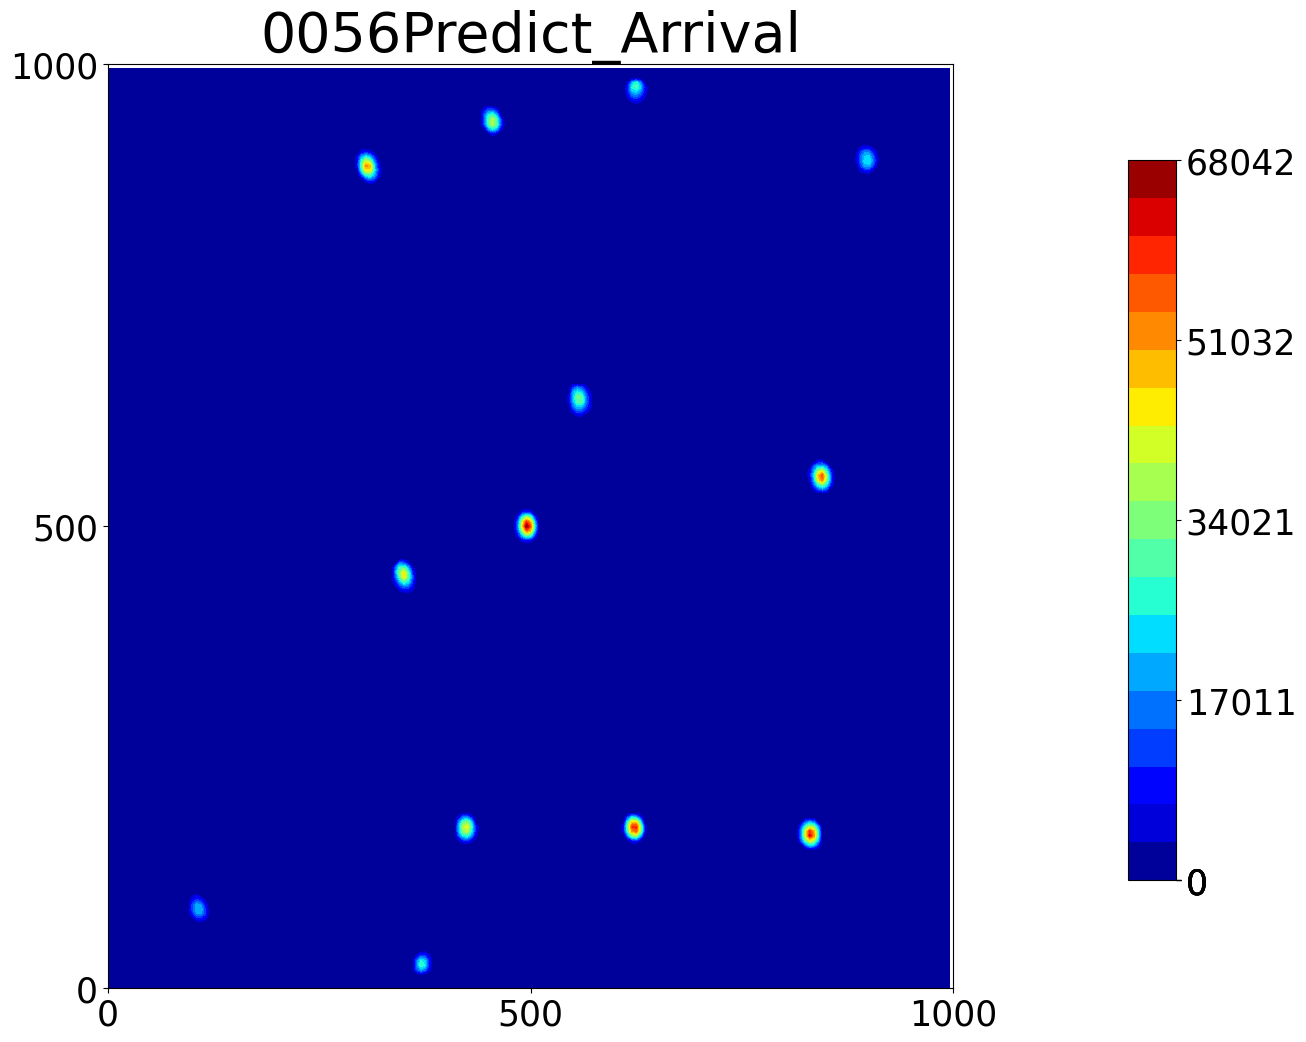

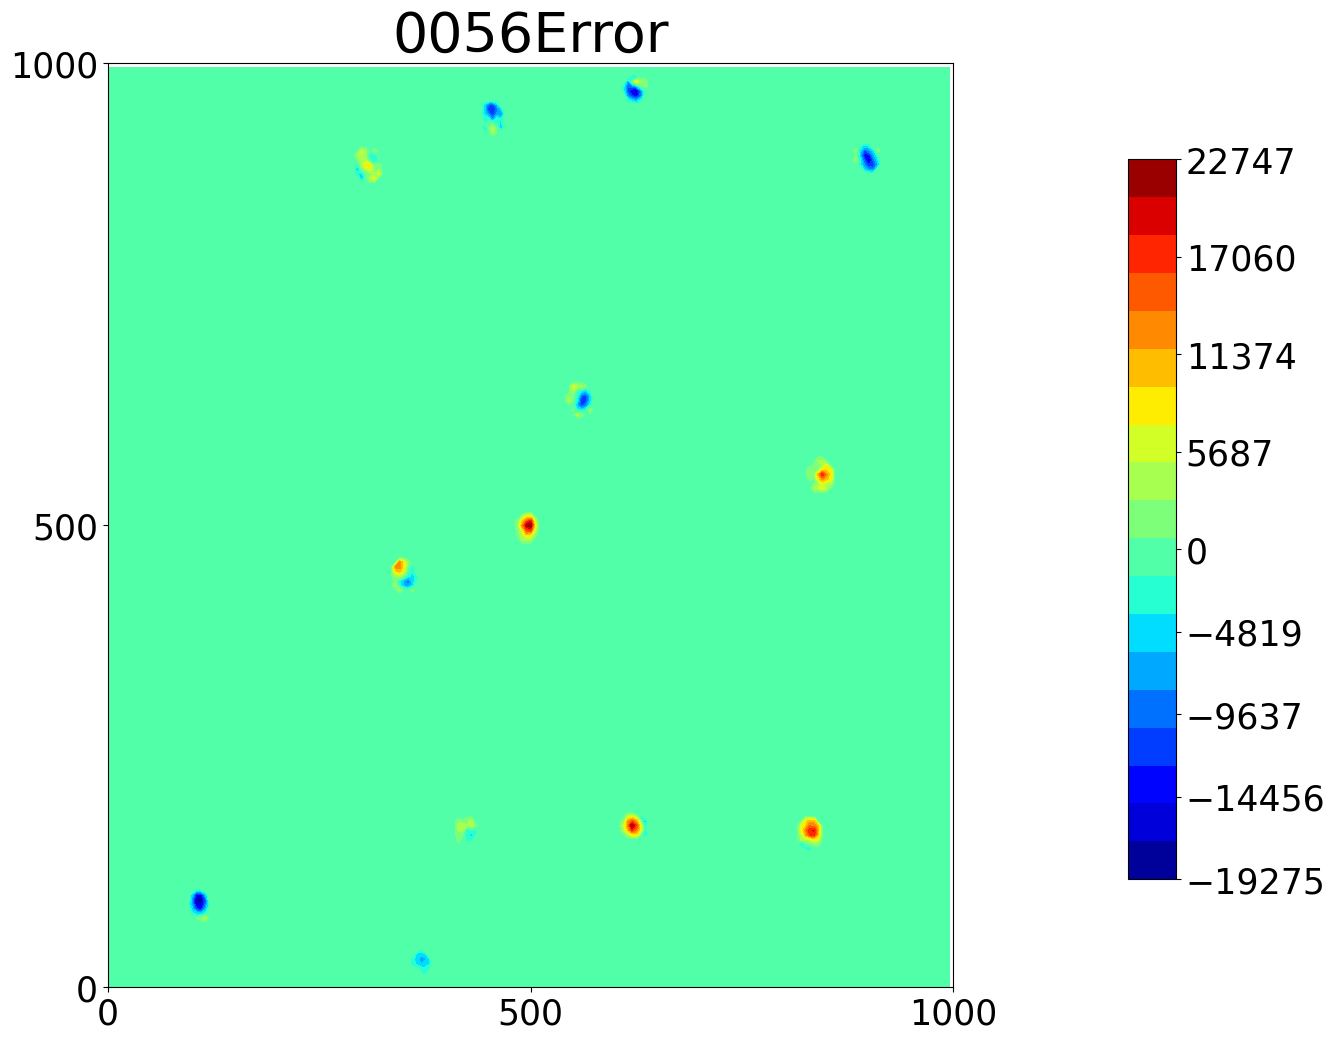

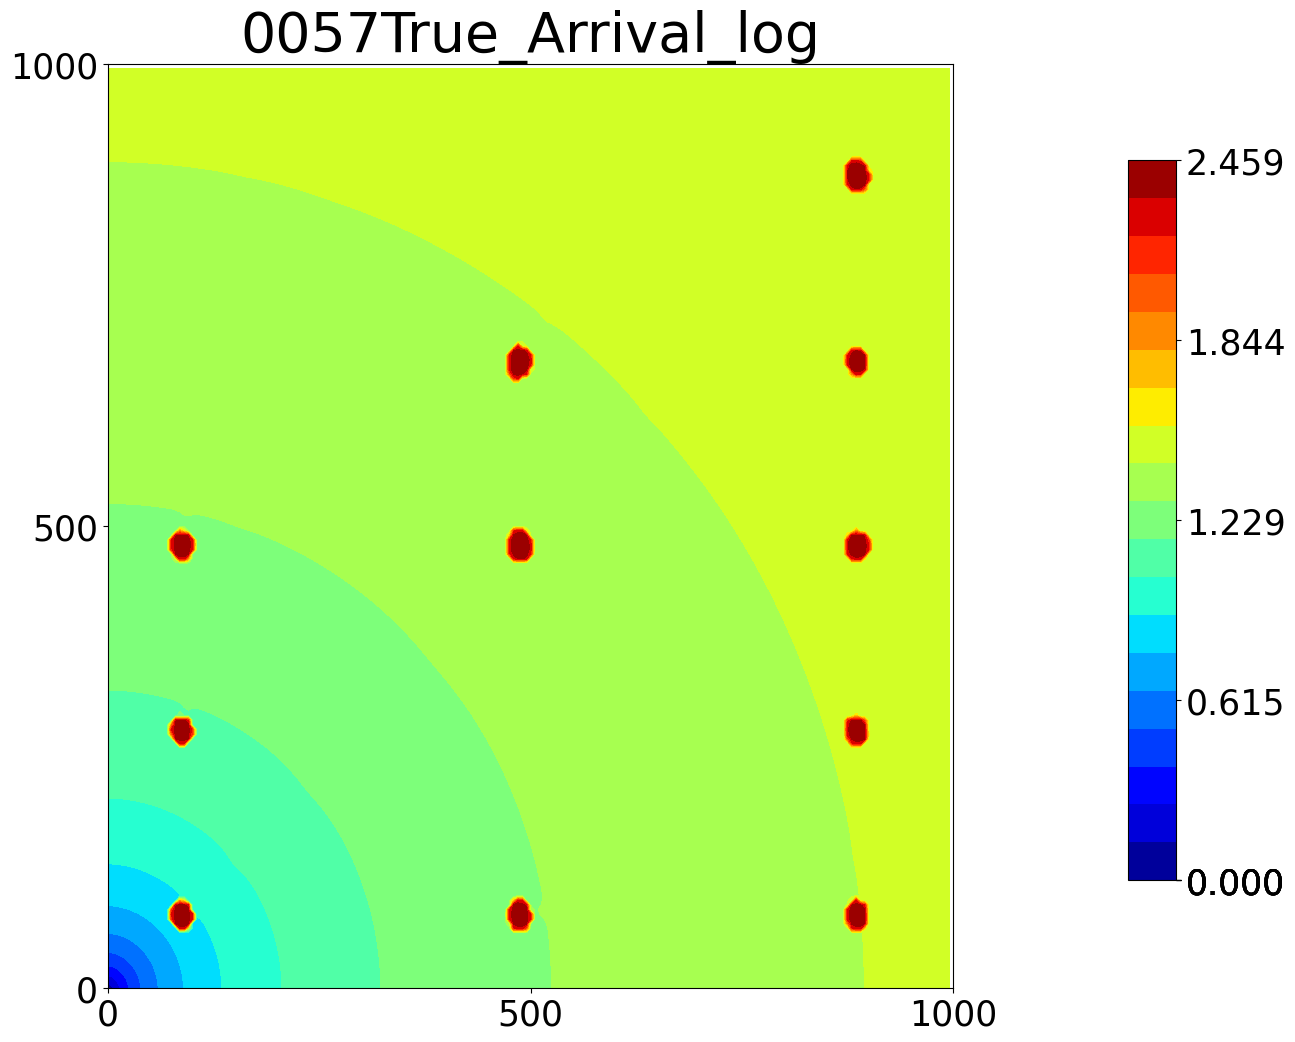

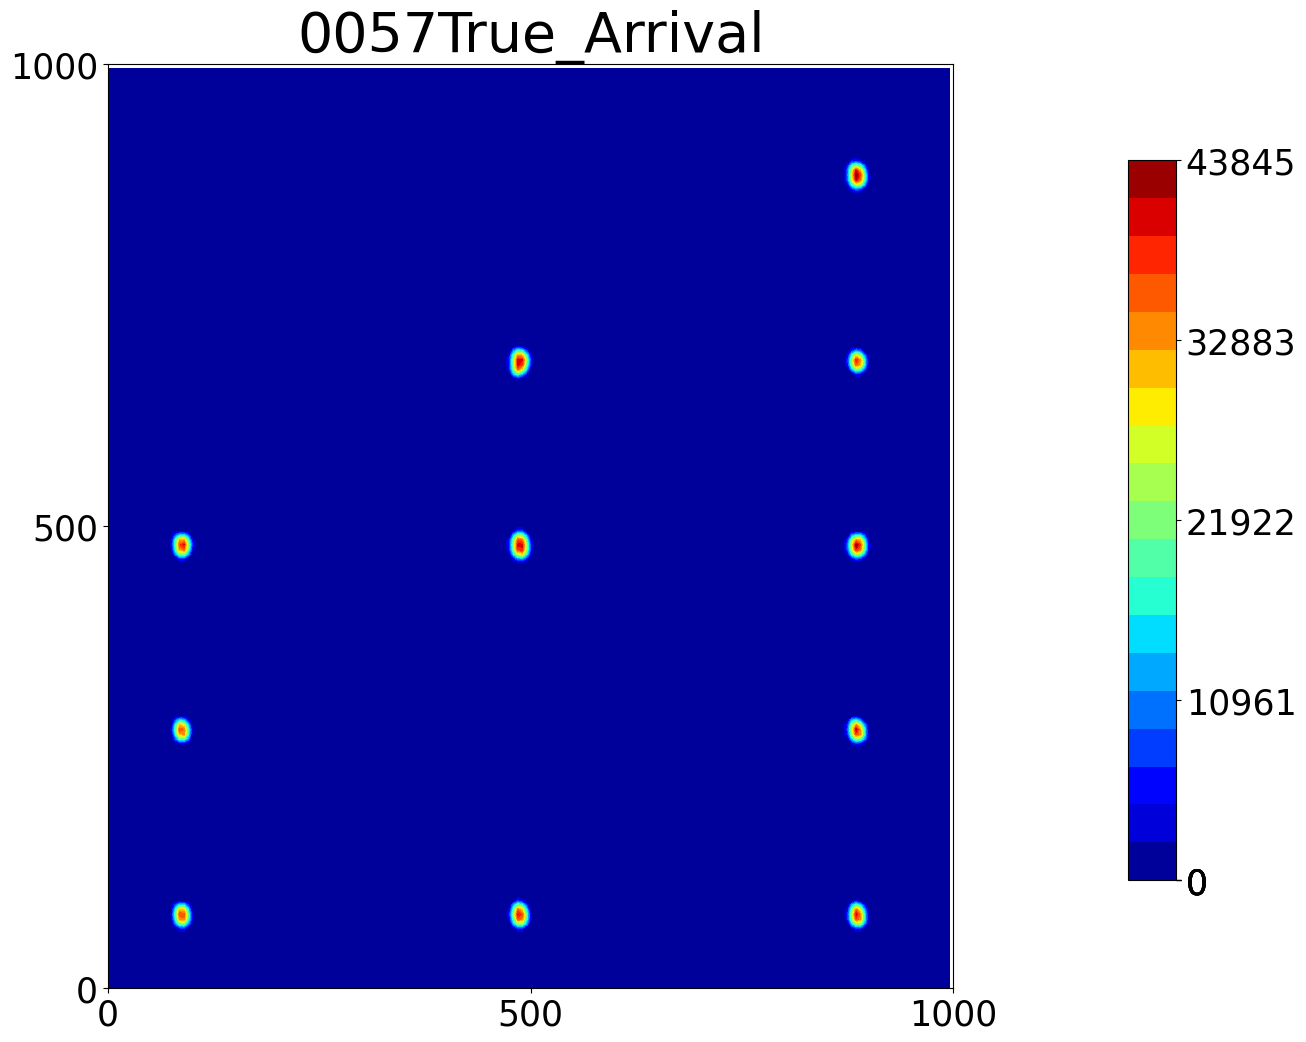

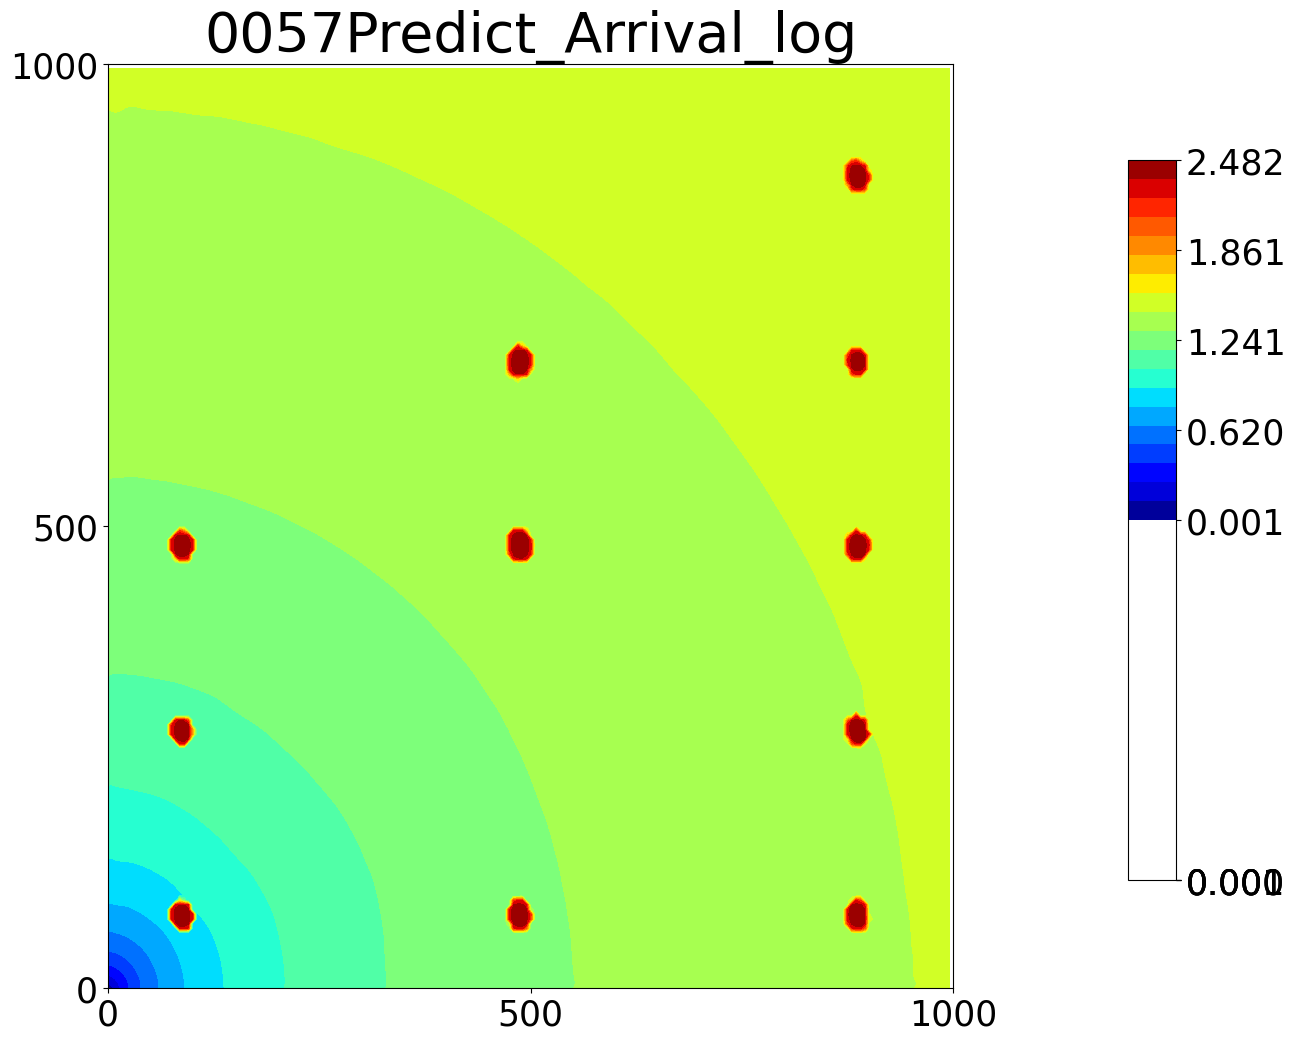

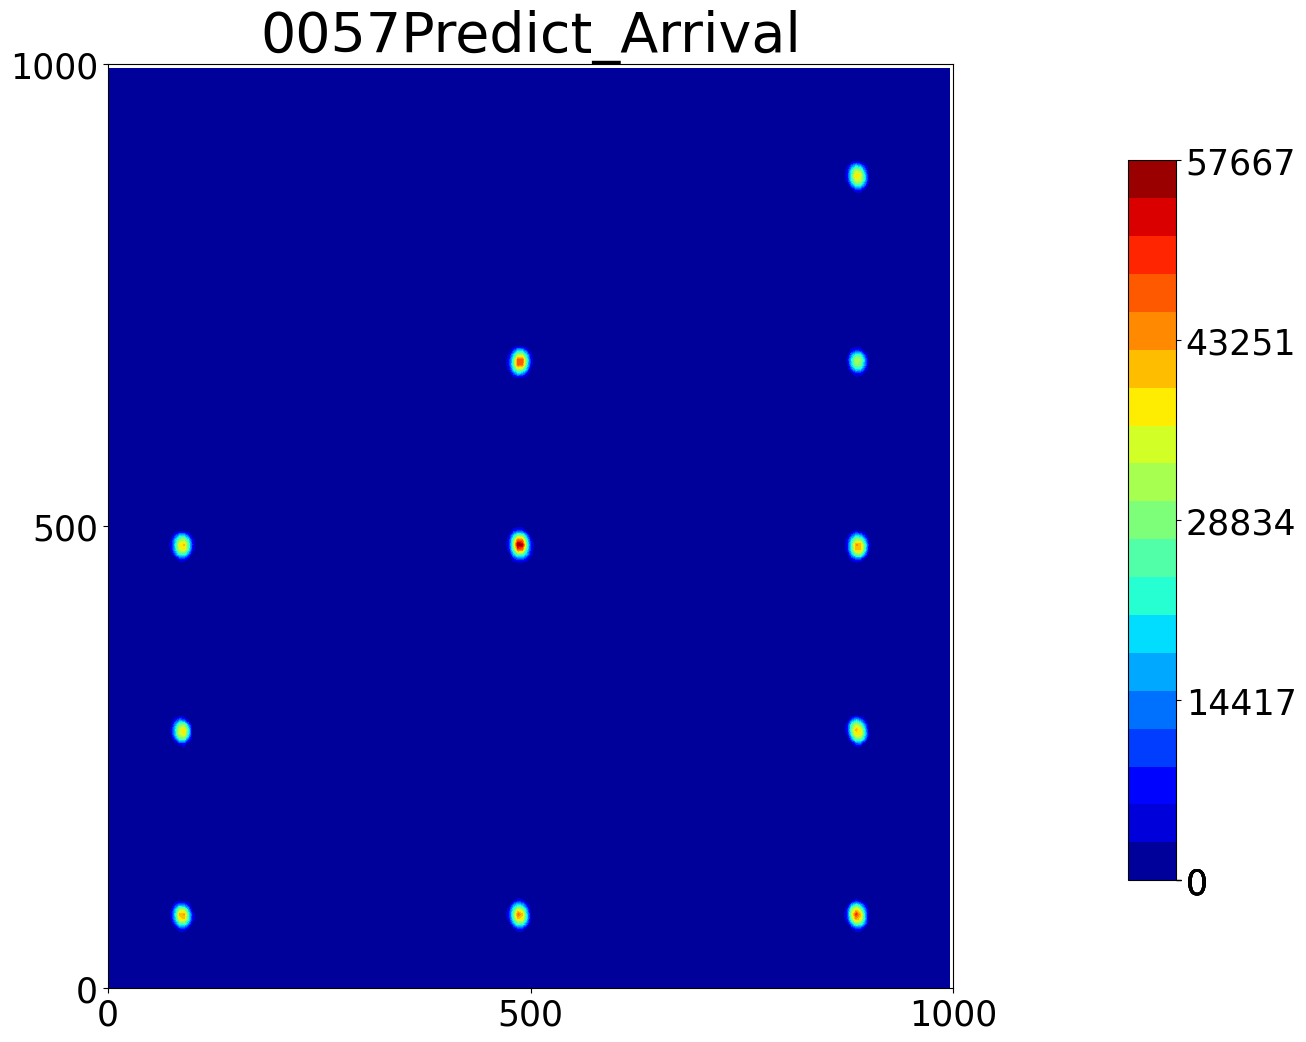

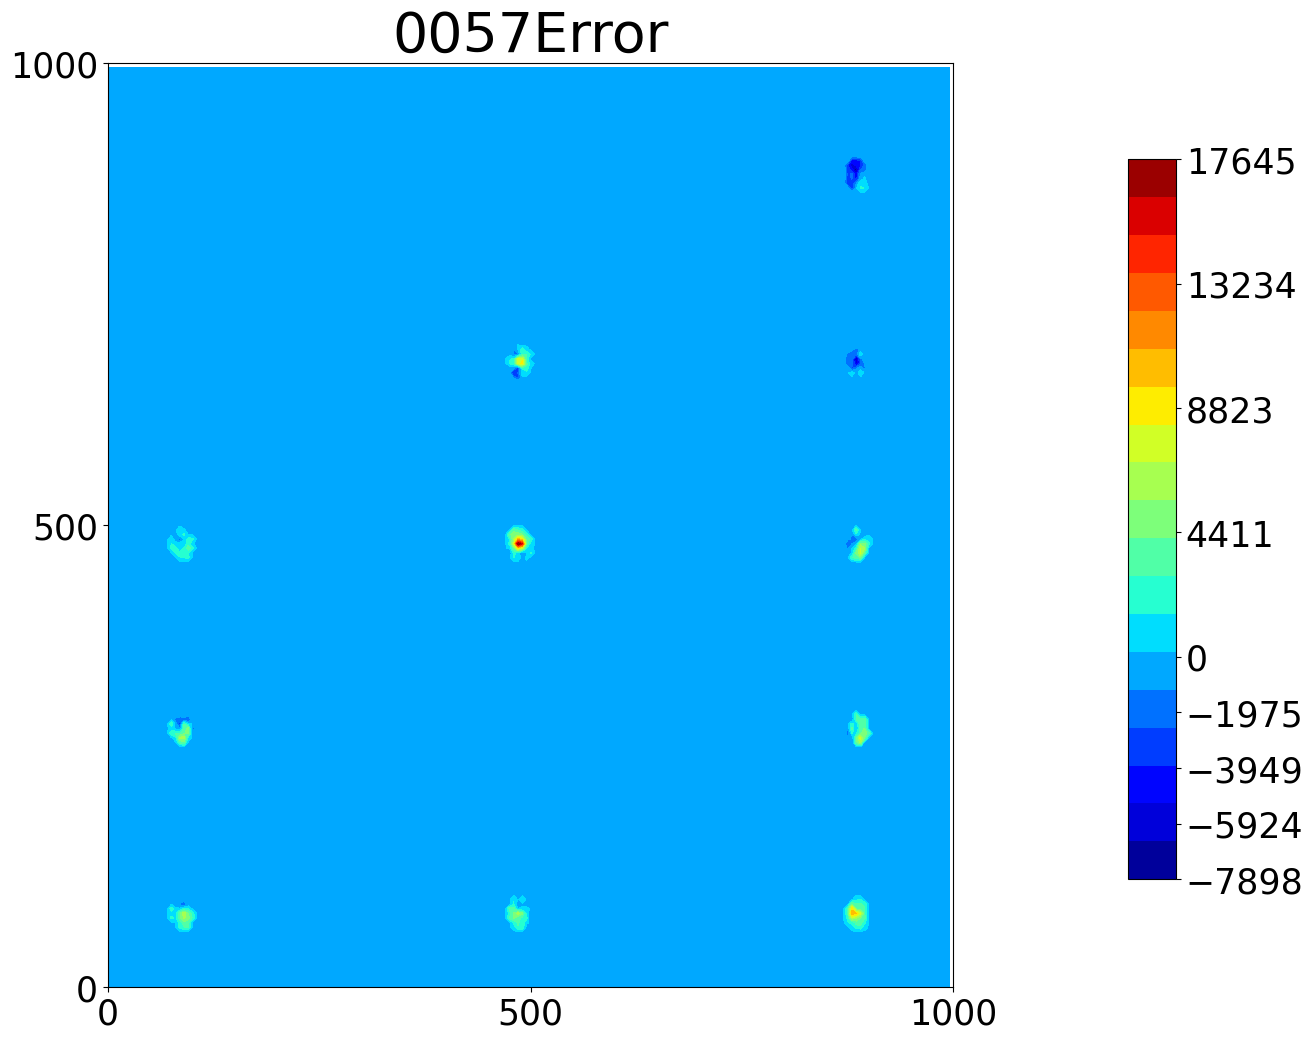

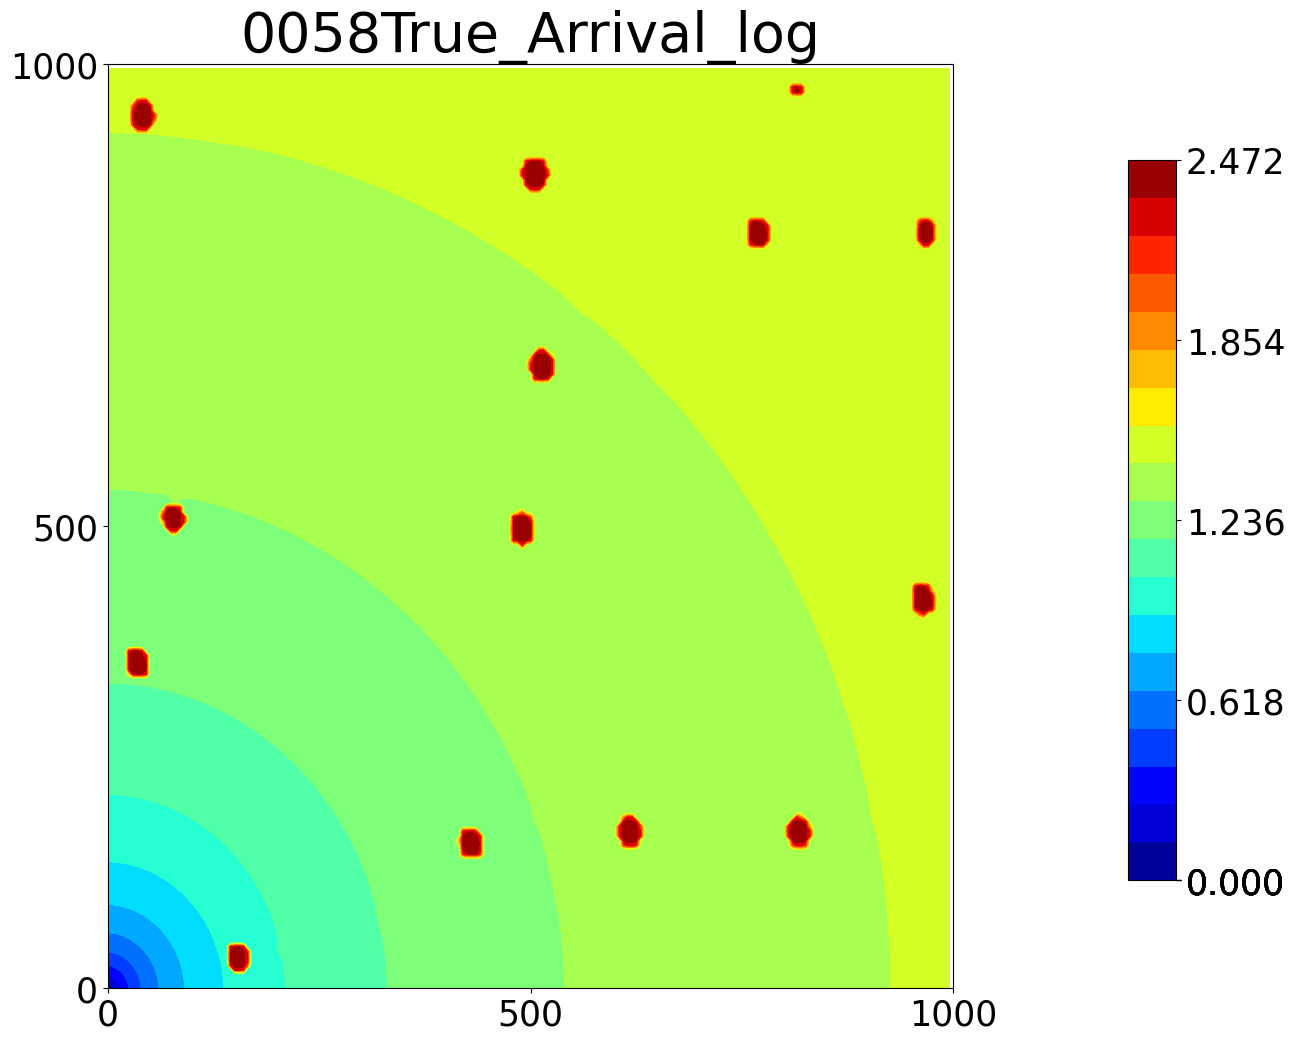

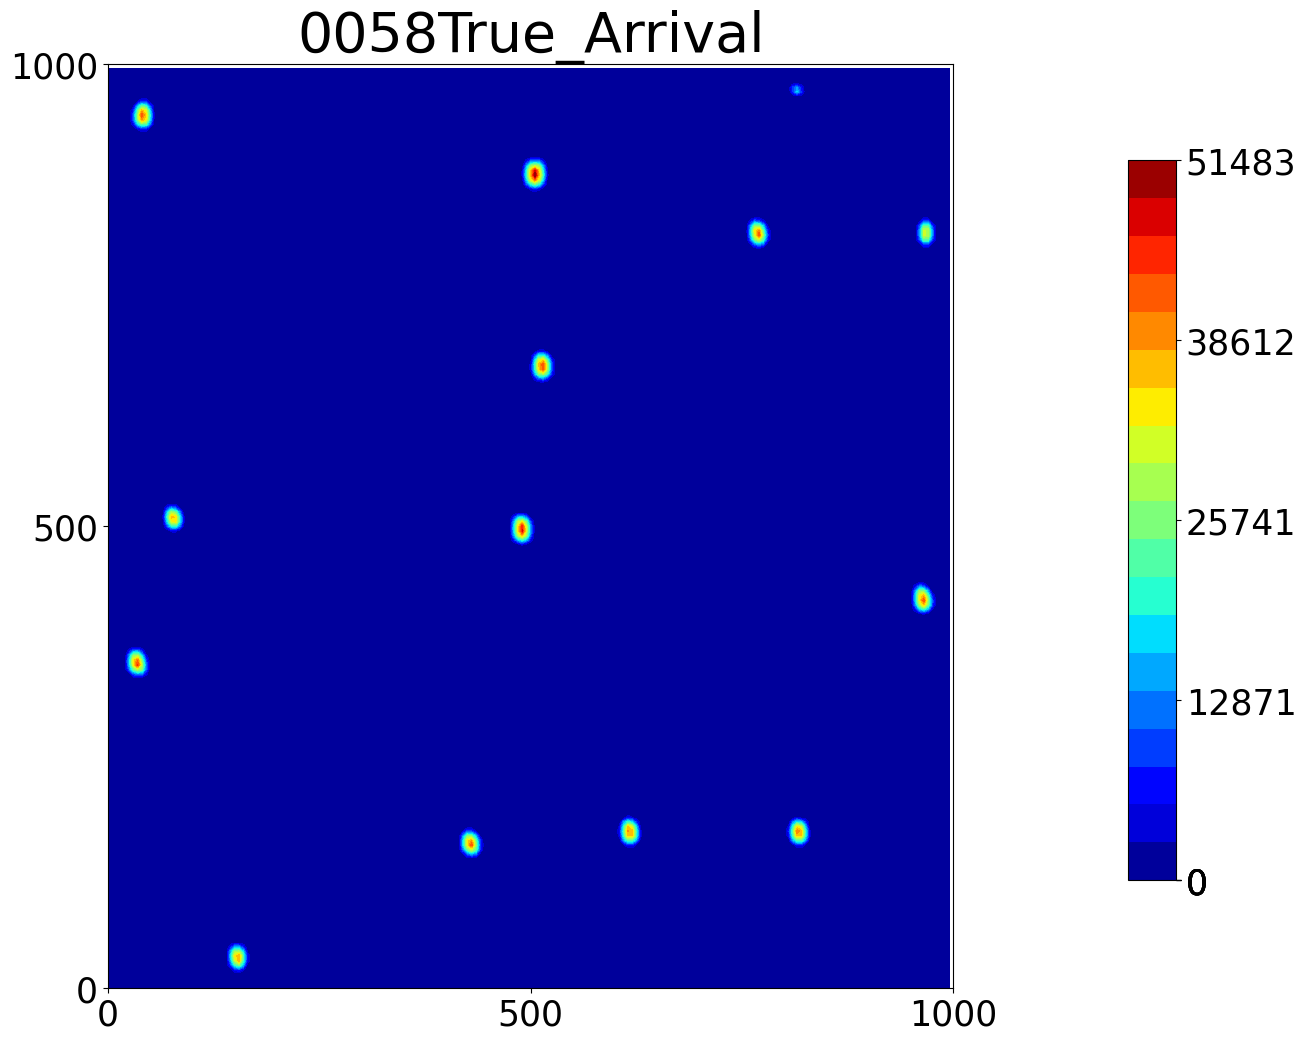

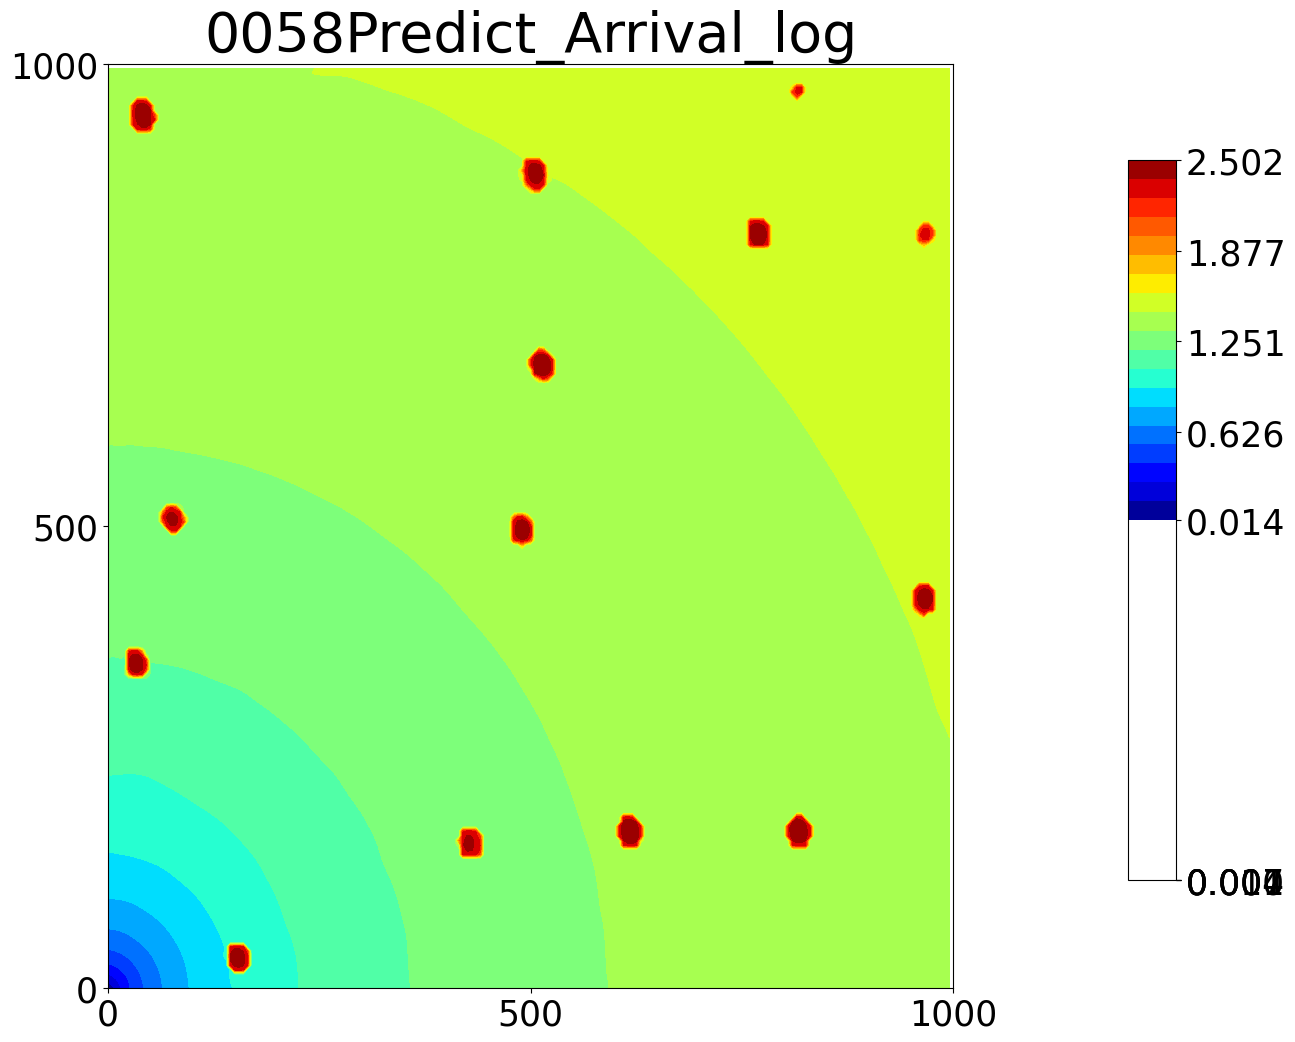

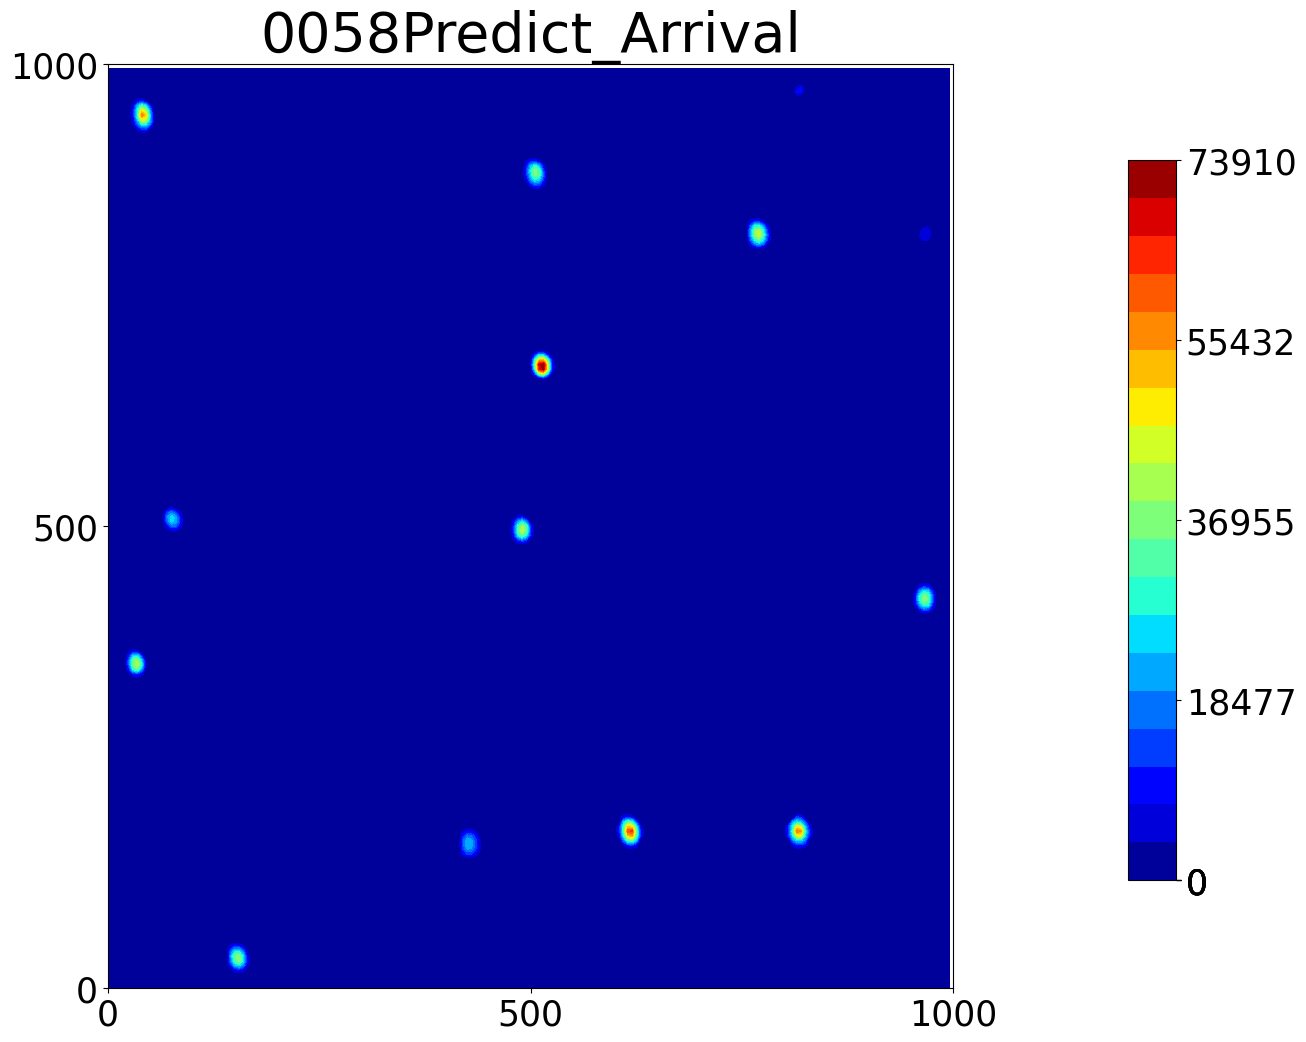

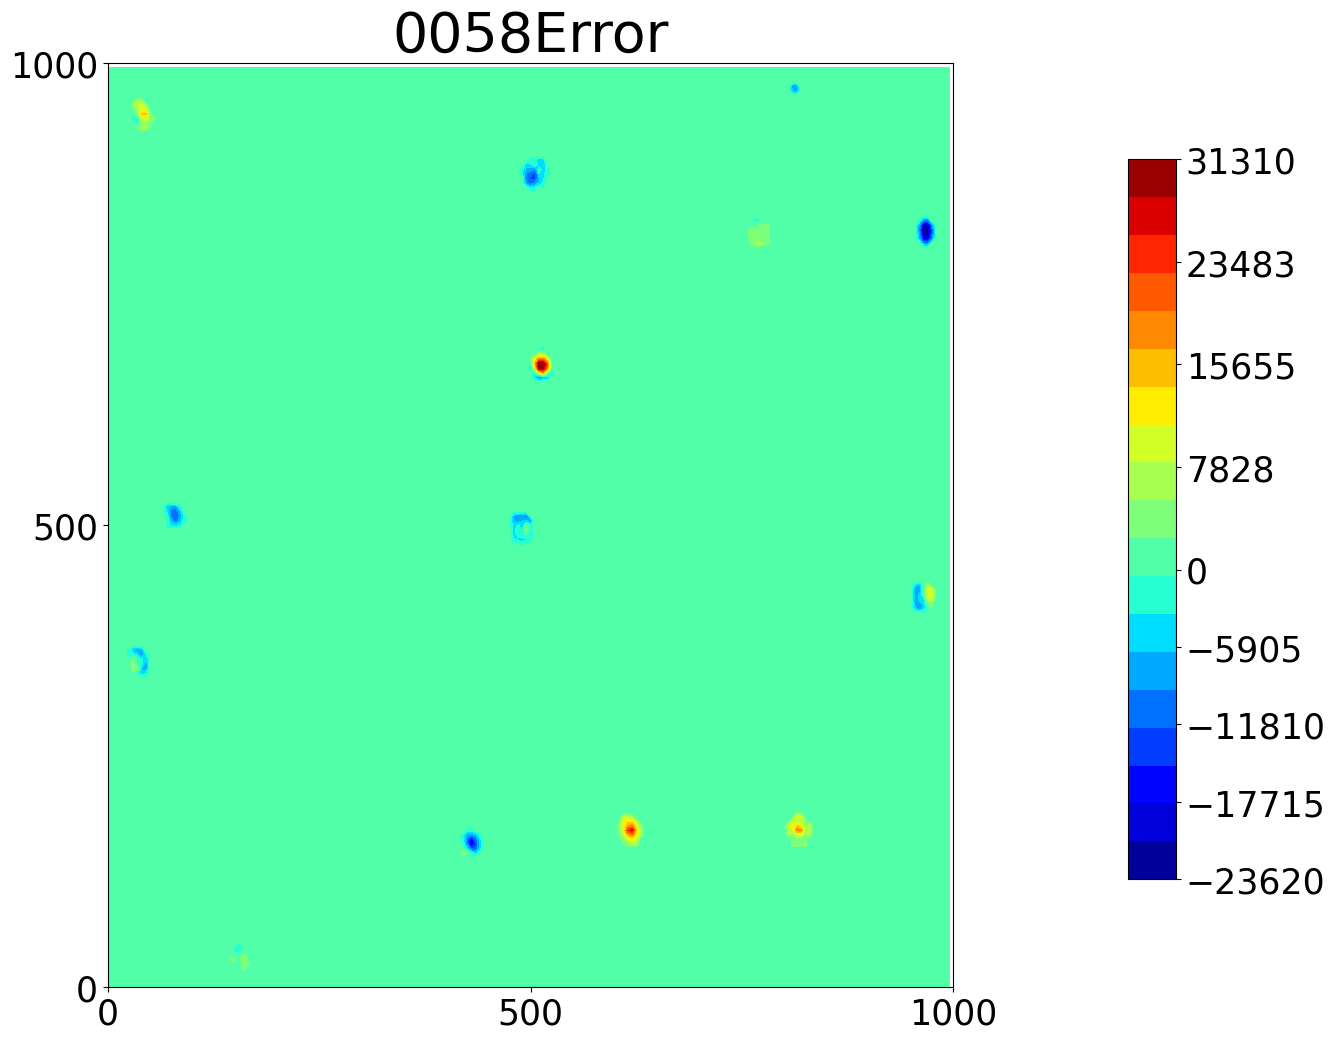

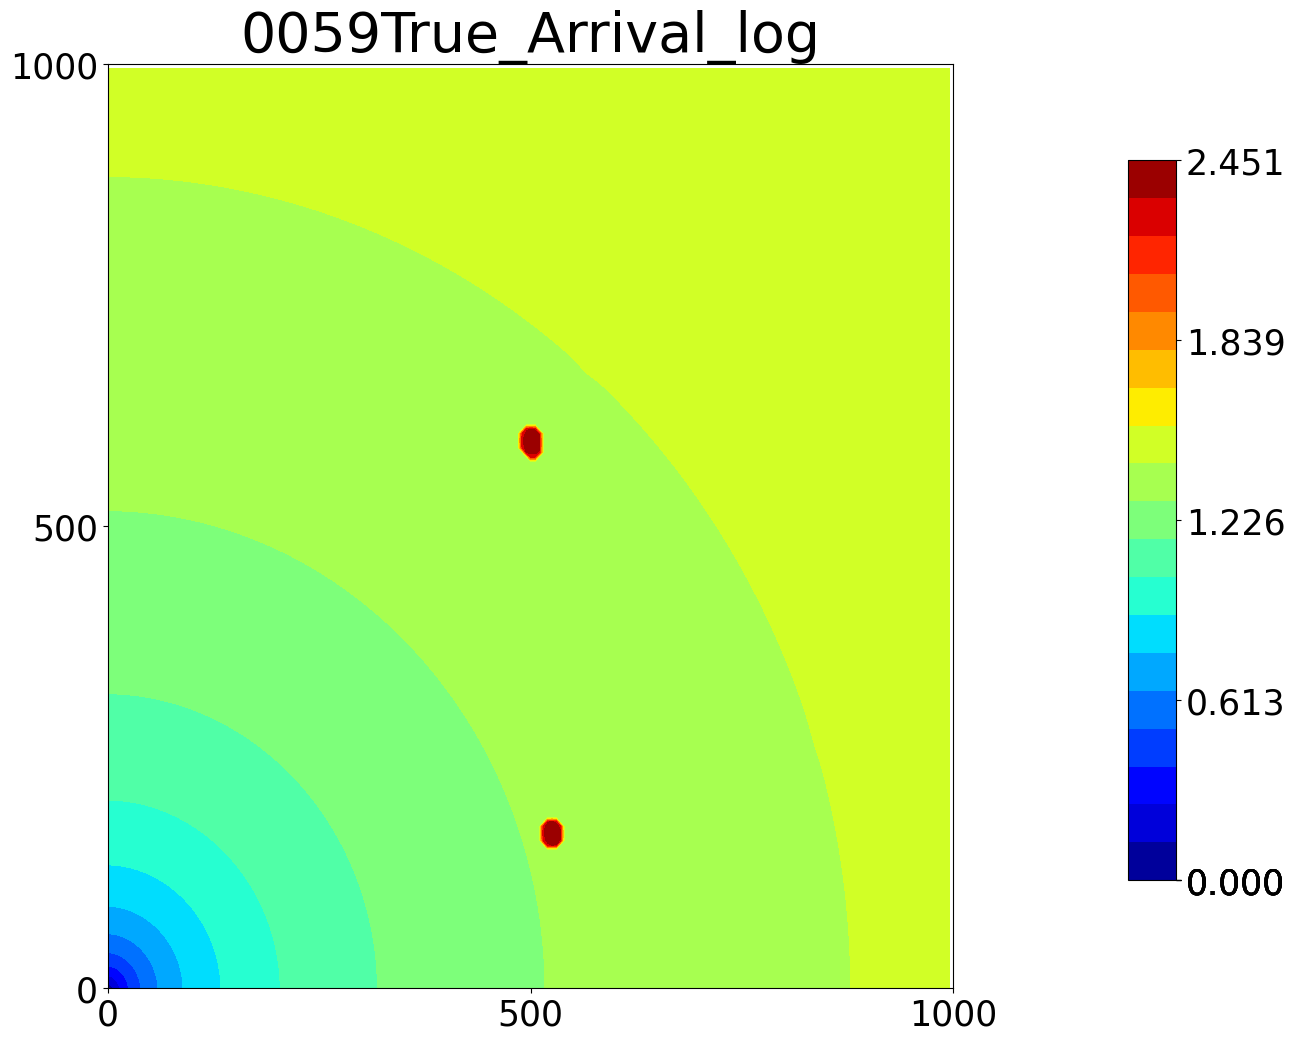

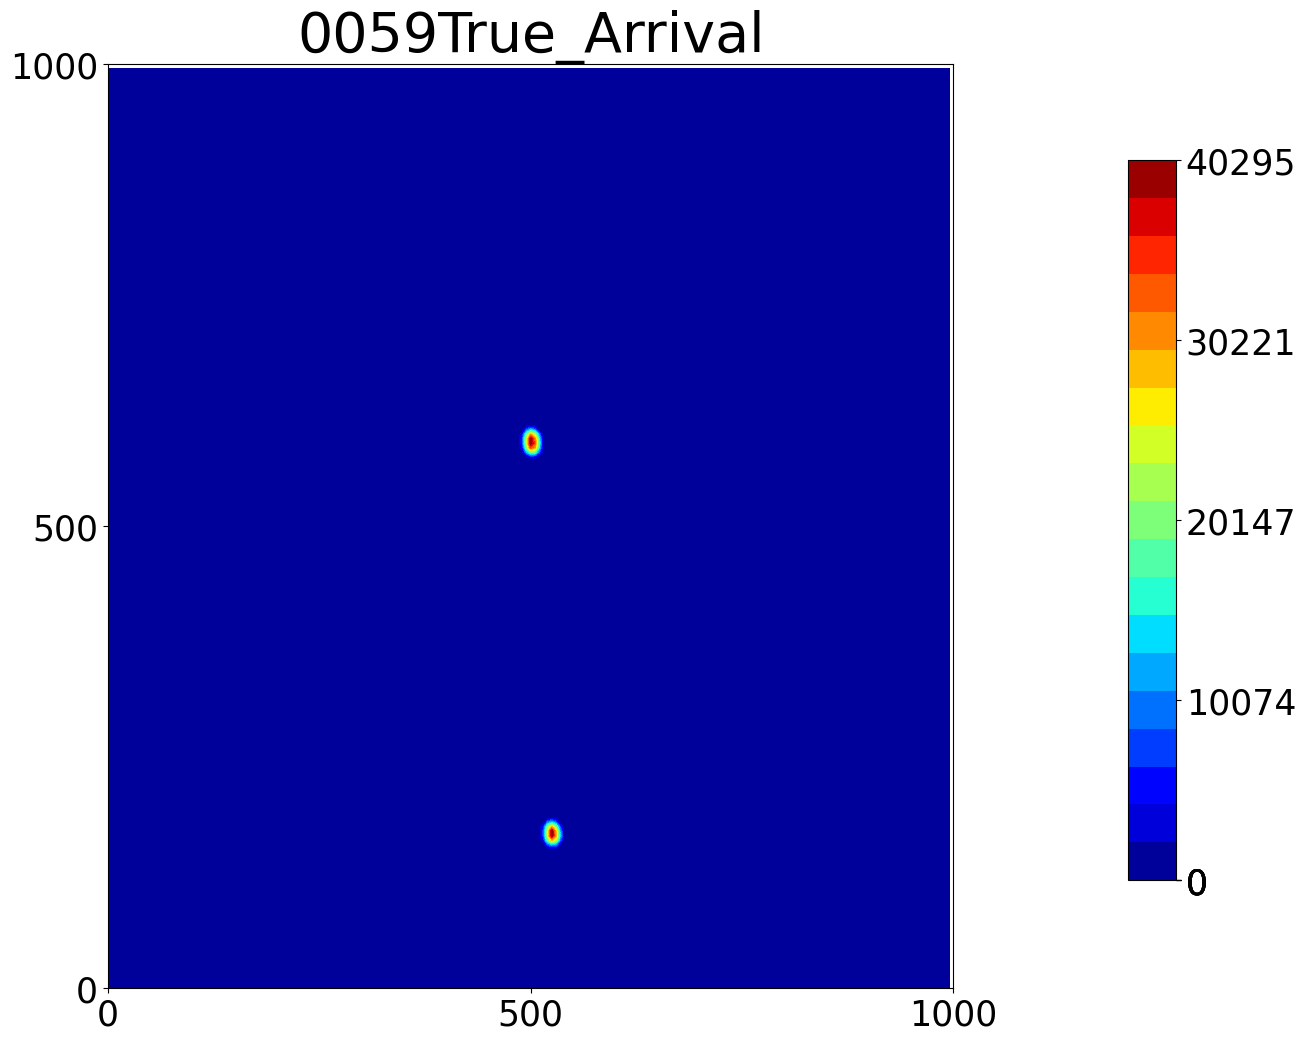

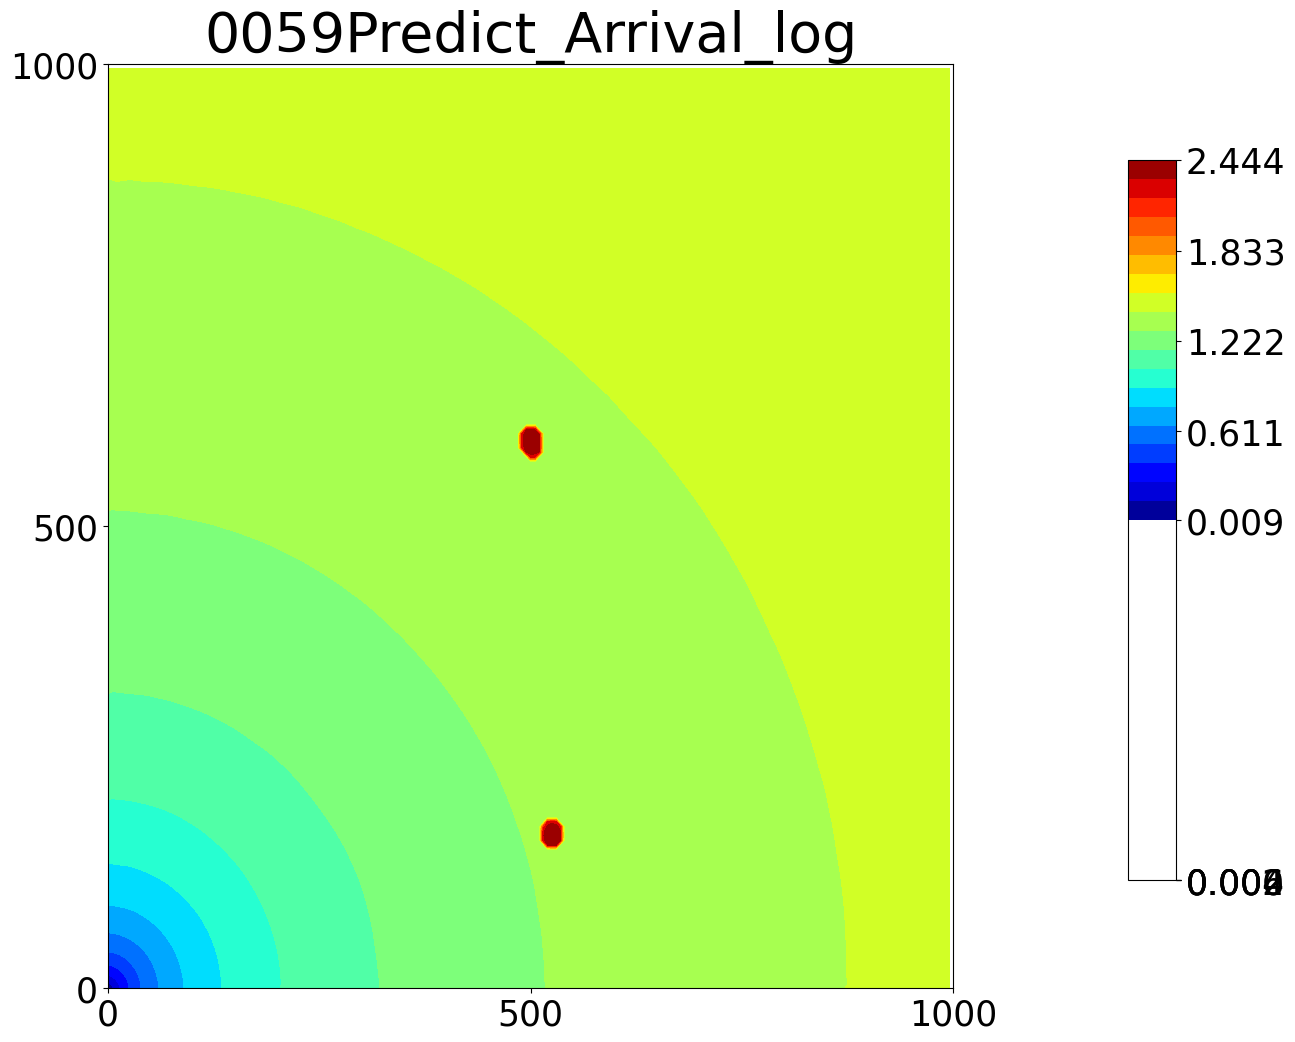

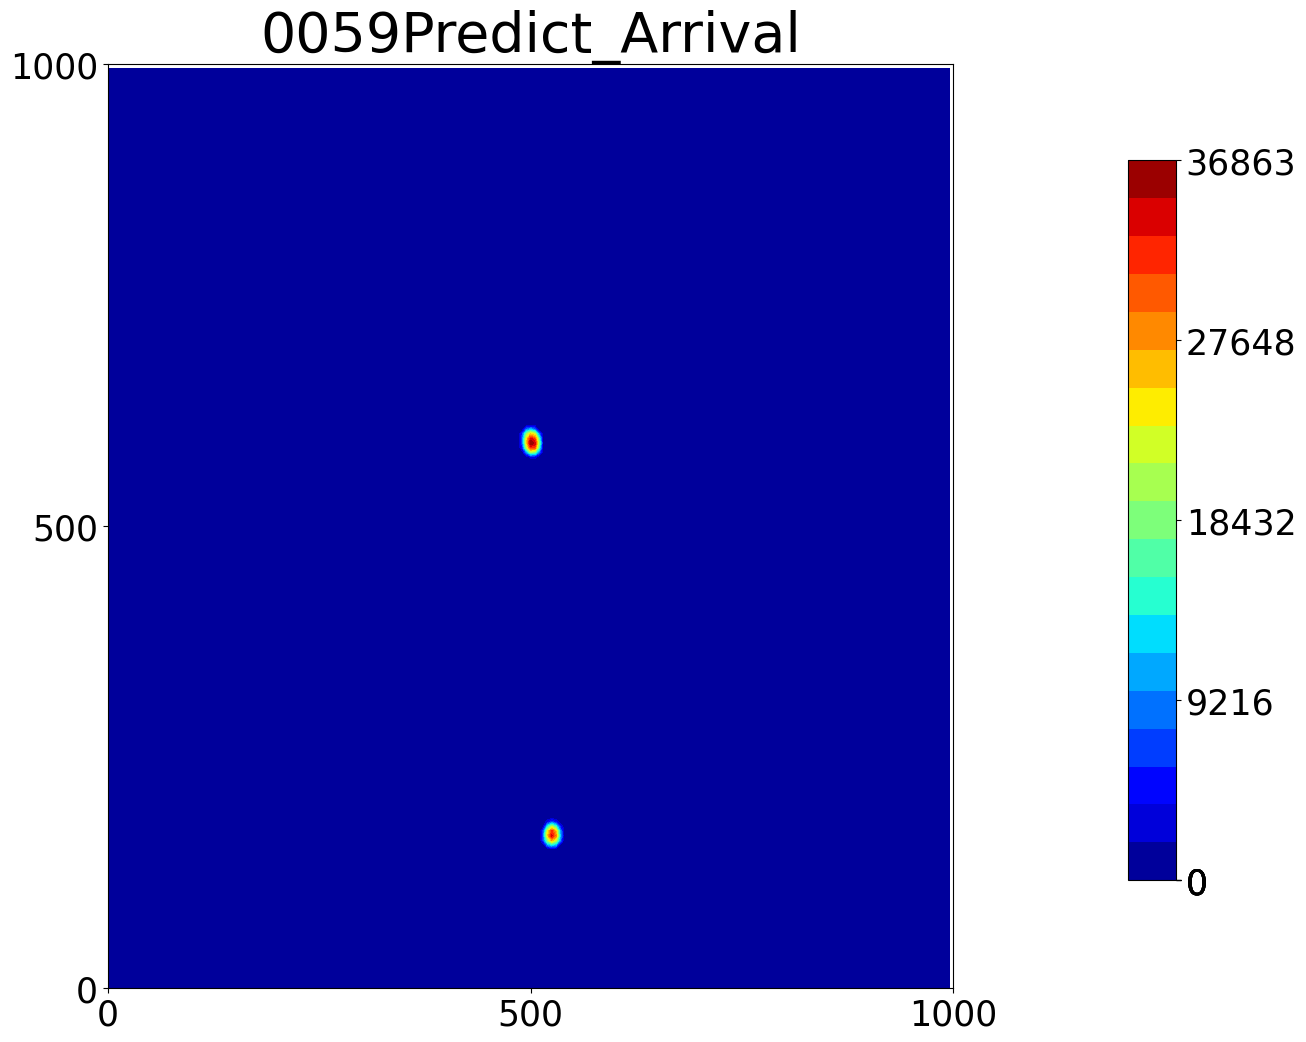

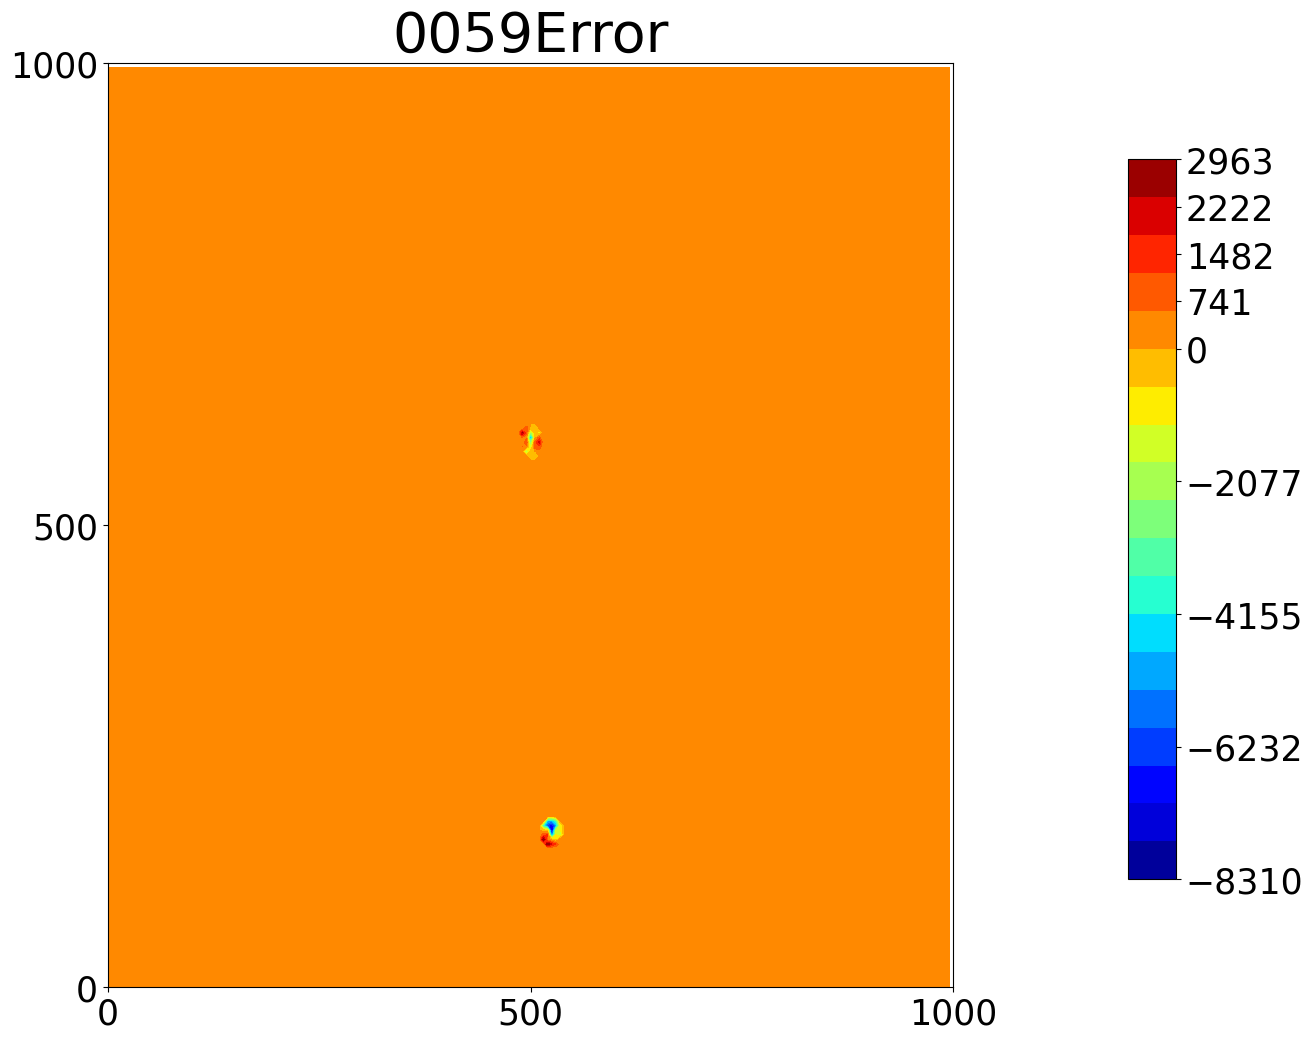

In [ ]:
print(x_fc_list.shape)

for k in range (nforecast):
    plot_test_x = x_fc_list[k:k+1,:,:,:]
    plot_test_y_log = model(plot_test_x)
    #print(plot_test_y.shape)
    plot_test_y_log = plot_test_y_log.cpu().detach().numpy()[0,:,:,0]
    #plot_test_y = plot_test_y.reshape((200,200))
    plot_test_y = de_trans(plot_test_y_log)
    plot_test_y_ref_log = y_fc_list.cpu().detach().numpy()[k,:,:,0]
    plot_test_y_ref = de_trans(plot_test_y_ref_log)
    plot_test_err = plot_test_y - plot_test_y_ref
    print("The ",k+ntrain+ntest,"st Forecast result")
    #save_time = time.strptime(now)
    
    print("True_Arrival_log")
    name1 = namepic(k, "True_Arrival_log")
    plotmesh(plot_test_y_ref_log, name1, save_time)
    
    print("True Arrival")
    name2 = namepic(k, "True_Arrival")
    plotmesh(plot_test_y_ref, name2, save_time)
    
    print("Predict Arrival log")
    name3 = namepic(k, "Predict_Arrival_log")
    plotmesh(plot_test_y_log, name3, save_time)
    
    print("Predict Arrival")
    name4 = namepic(k, "Predict_Arrival")
    plotmesh(plot_test_y, name4, save_time)
    
    print("Error")
    name5 = namepic(k, "Error")
    plotmesh(plot_test_err, name5, save_time)
    
    print("plot_test_y_ref.max(): ",abs(plot_test_y_ref).max())
    print("plot_test_err.max(): ",abs(plot_test_err).max())
    print("===================================")